<a href="https://colab.research.google.com/github/UMassIonTrappers/Introduction-to-Quantum-Computing/blob/main/labs/Lab_08_QPU_Benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 550/650

## Introduction to Quantum Computing

Robert Niffenegger (rniffenegger@umass.edu )

In [1]:
import logging
# Suppress all logging from stevedore (which is needed with QISKIT 2.0 for some reason...)
logging.getLogger("stevedore.extension").propagate = False
logging.getLogger("stevedore.extension").disabled = True

In [2]:
try:
  import qiskit
  print('Qiskit imported')
except ImportError:
  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  # !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
  
import qiskit
print('Qiskit version:', qiskit.__version__)

try:
  from qiskit_aer import QasmSimulator
  print('Qiskit Aer imported');
except ImportError:
  print('Install Qiskit-Aer')
  !pip install --quiet qiskit-aer

try:
  from qiskit_ibm_runtime import QiskitRuntimeService
  print('Qiskit-IBM-Runtime imported')

except ImportError:
  print('Install Qiskit-IBM-Runtime')
  !pip install --quiet qiskit-ibm-runtime
  !pip install --quiet qiskit_ibm_provider[visualization]

# !pip install --quiet graphviz
# !apt-get install graphviz

Qiskit imported
Qiskit version: 1.4.2
Qiskit Aer imported
Qiskit-IBM-Runtime imported


### Initialize

In [3]:
%matplotlib inline
from IPython.display import display, Math, Image
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos
from scipy import constants
from scipy.optimize import curve_fit

import math
import time
import random

#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

#Qisket imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city, array_to_latex
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

#Qisket imports
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.ibmq import least_busy
# from qiskit.providers.basicaer import BasicAer
# from qiskit.providers.aer.noise import *

from qiskit.circuit.library import *
from qiskit.quantum_info.operators import Operator

# """Show ALL outputs, not just last expression"""
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# Lab 8 - Benchmarking QPUs

# Topics covered:

 * T1 - qubit lifetime
 * T2* - qubit phase coherence time 
 * T2 - qubit phase coherence with echo
 * Gate fidelity benchmarking
 * Randomized Gate Benchmarking
 * GHZ states - multi-particle entangled states
 * GHZ parity contrast decay vs. number of qubits
 * Quantum Volume metric
 * QV computational complexity analysis



# Benchmarking QPUs



https://learning.quantum.ibm.com/tutorial/real-time-benchmarking-for-qubit-selection

In [11]:
# Check if token needs to be set
token = "INSERT YOUR TOKEN HERE"

if token == "INSERT YOUR TOKEN HERE":
    token = input("Please enter your IBM Quantum token: ")

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True,
  set_as_default=True
)

In [13]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

service = QiskitRuntimeService()

backend = FakeBrisbane()
backend.refresh(service)

## T2 - Phase Coherence time

Let's measure the phase coherence time (T2 time) of the qubits on ibm_brisbane

In [7]:
# Parallel Ramsey function
def parallel_Ramsey(delay, backend, num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        # qc.x(q)
        qc.h(q)
        qc.delay(delay , q, unit="s")
        qc.h(q)
        qc.measure(q, q)
    return qc


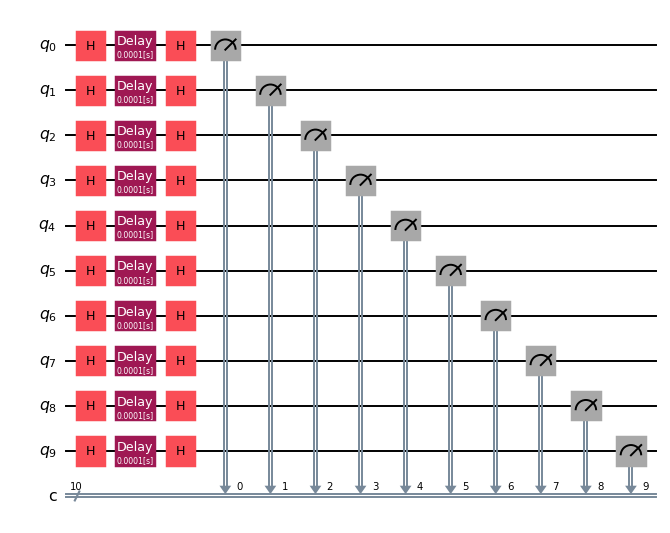

In [8]:
circuit = parallel_Ramsey( 100e-6, backend, num_qubits=10)
circuit.draw('mpl',scale=0.7)

In [12]:
backend = FakeBrisbane()
num_qubits = 10
shots = 1000

# Define delays in microseconds (converted to seconds)
delays_us = [1, 50, 100, 200, 300 ,400, 500]
delay_times = [d * 1.0e-6 for d in delays_us]

# Store probabilities per qubit
probs_per_qubit_Ramsey = {q: [] for q in range(num_qubits)}

# Run simulations
for delay in delay_times:
    print(round(delay,6))
    circuit = parallel_Ramsey(delay, backend, num_qubits)
    transpiled = transpile(circuit, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()

    for qubit in range(num_qubits):
        one_count = 0
        for bitstring, count in counts.items():
            if bitstring[::-1][qubit] == '1':
                one_count += count
        prob = 1-one_count / shots
        probs_per_qubit_Ramsey[qubit].append(prob)


1e-06
5e-05
0.0001
0.0002
0.0003
0.0004
0.0005



Estimated T₂ values (in µs):
Qubit 0: T₂ ≈ 126.43 µs
Qubit 1: T₂ ≈ 132.78 µs
Qubit 2: T₂ ≈ 32.18 µs
Qubit 3: T₂ ≈ 150.70 µs
Qubit 4: T₂ ≈ 60.46 µs
Qubit 5: T₂ ≈ 363.76 µs
Qubit 6: T₂ ≈ 226.48 µs
Qubit 7: T₂ ≈ 80.55 µs
Qubit 8: T₂ ≈ 129.14 µs
Qubit 9: T₂ ≈ 62.59 µs


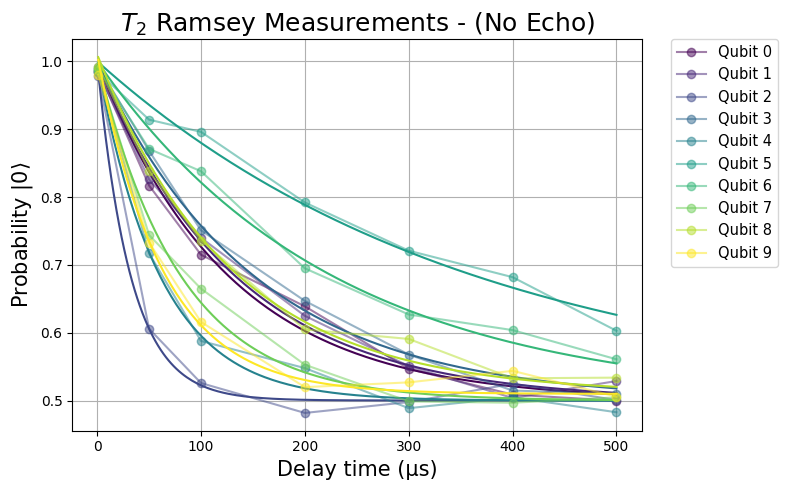

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define exponential decay function
def exp_decay(t, A, T2, B):
    return A * np.exp(-t / T2) + B

# Fit T2 per qubit and store estimates
t2_estimates_Ramsey = {}

for q in range(num_qubits):
    try:
        # Initial parameter guesses and bounds
        popt, _ = curve_fit(
            exp_decay,
            delays_us,
            probs_per_qubit_Ramsey[q],
            p0=[0.5, 50, 0.5],
            bounds=([0.5, 0, 0.5], [0.51, 1000, 0.51])
        )
        t2_estimates_Ramsey[q] = popt  # Store full fit parameters
    except RuntimeError:
        t2_estimates_Ramsey[q] = None

# Print estimated T2 values
print("\nEstimated T₂ values (in µs):")
for q in range(num_qubits):
    params = t2_estimates_Ramsey[q]
    if params is not None:
        print(f"Qubit {q}: T₂ ≈ {params[1]:.2f} µs")
    else:
        print(f"Qubit {q}: Fit failed")

# Plotting
plt.figure(figsize=(8, 5))
fs = 15
colors = plt.cm.viridis(np.linspace(0, 1, num_qubits))

for q in range(num_qubits):
    # Plot raw data
    plt.plot(
        delays_us,
        probs_per_qubit_Ramsey[q],
        '-o',
        label=f"Qubit {q}",
        color=colors[q],
        alpha=0.5
    )

    # Plot fitted curve if available
    params = t2_estimates_Ramsey[q]
    if params is not None:
        A, T2, B = params
        t_fit = np.linspace(min(delays_us), max(delays_us), 200)
        plt.plot(
            t_fit,
            exp_decay(t_fit, A, T2, B),
            '-',
            color=colors[q]
            )

plt.xlabel("Delay time (µs)", fontsize=fs)
plt.ylabel(r'Probability $|0\rangle$', fontsize=fs)
plt.title(r'$T_2$ Ramsey Measurements - (No Echo)', fontsize=fs * 1.2)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=fs * 0.7)
plt.tight_layout()
plt.show()


In [15]:
# Parallel Hahn echo function
def parallel_hahn_echo(delay, backend, num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        # qc.x(q)
        qc.h(q)
        qc.delay(delay / 2, q, unit="s")
        qc.x(q)
        qc.delay(delay / 2, q, unit="s")
        qc.h(q)
        qc.measure(q, q)
    return qc

# Exponential decay function
def exp_decay(t, A, T2, B):
    return A * np.exp(-t / T2) + B

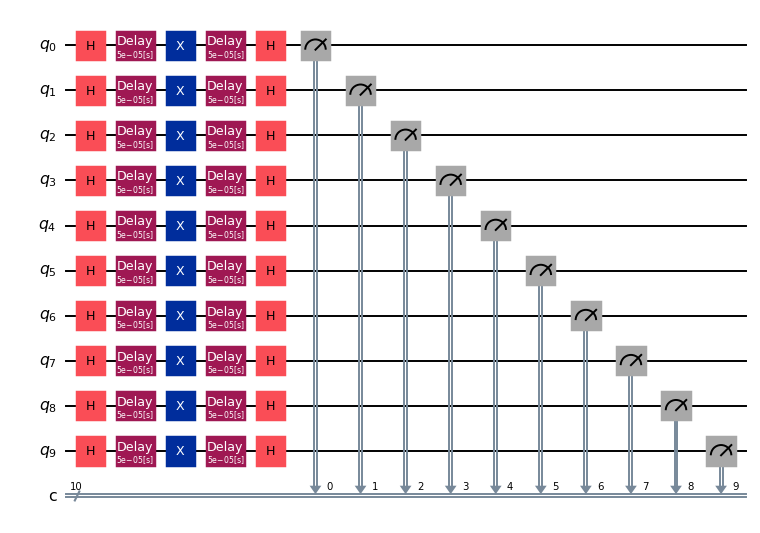

In [16]:
circuit = parallel_hahn_echo( 100e-6, backend, num_qubits=10)
circuit.draw('mpl',scale=0.7)

In [18]:
backend = FakeBrisbane()
num_qubits = 10

# Define delays in microseconds (converted to seconds)
delays_us = [1, 50, 100, 200, 300 ,400, 500]
delay_times = [d * 1.0e-6 for d in delays_us]

# Store probabilities per qubit
probs_per_qubit = {q: [] for q in range(num_qubits)}

shots = 1000

# Run simulations
for delay in delay_times:
    print(round(delay,6))
    circuit = parallel_hahn_echo(delay, backend, num_qubits)
    transpiled = transpile(circuit, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()

    for qubit in range(num_qubits):
        one_count = 0
        for bitstring, count in counts.items():
            if bitstring[::-1][qubit] == '1':
                one_count += count
        prob = 1-one_count / shots
        probs_per_qubit[qubit].append(prob)


1e-06
5e-05
0.0001
0.0002
0.0003
0.0004
0.0005



Estimated T₂ values (in µs):
Qubit 0: T₂ ≈ 131.42 µs
Qubit 1: T₂ ≈ 159.08 µs
Qubit 2: T₂ ≈ 32.08 µs
Qubit 3: T₂ ≈ 126.56 µs
Qubit 4: T₂ ≈ 69.18 µs
Qubit 5: T₂ ≈ 397.72 µs
Qubit 6: T₂ ≈ 273.47 µs
Qubit 7: T₂ ≈ 81.96 µs
Qubit 8: T₂ ≈ 153.07 µs
Qubit 9: T₂ ≈ 68.38 µs


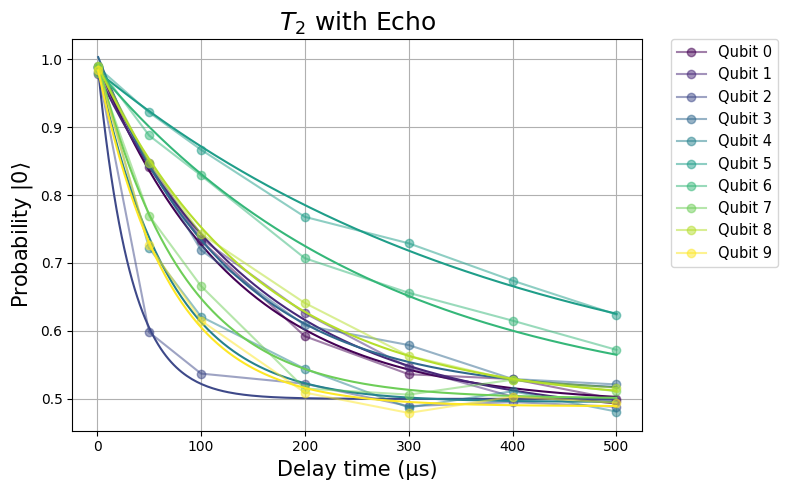

In [19]:
from scipy.optimize import curve_fit

# Define exponential decay function
def exp_decay(t, A, T2, B):
    return A * np.exp(-t / T2) + B

# Fit T2 per qubit and store estimates
t2_estimates = {}

for q in range(num_qubits):
    try:
        # Initial parameter guesses and bounds
        popt, _ = curve_fit(
            exp_decay,
            delays_us,
            probs_per_qubit[q],
            p0=[0.5, 50, 0.5],
            bounds=([0.5, 0, 0.2], [0.51, 1000, 0.7])
        )
        t2_estimates[q] = popt  # Store full fit parameters
    except RuntimeError:
        t2_estimates[q] = None

# Print estimated T2 values
print("\nEstimated T₂ values (in µs):")
for q in range(num_qubits):
    params = t2_estimates[q]
    if params is not None:
        print(f"Qubit {q}: T₂ ≈ {params[1]:.2f} µs")
    else:
        print(f"Qubit {q}: Fit failed")

# Plotting
plt.figure(figsize=(8, 5))
fs = 15
colors = plt.cm.viridis(np.linspace(0, 1, num_qubits))

for q in range(num_qubits):
    # Plot raw data
    plt.plot(
        delays_us,
        probs_per_qubit[q],
        '-o',
        label=f"Qubit {q}",
        color=colors[q],
        alpha=0.5
    )

    # Plot fitted curve if available
    params = t2_estimates[q]
    if params is not None:
        A, T2, B = params
        t_fit = np.linspace(min(delays_us), max(delays_us), 200)
        plt.plot(
            t_fit,
            exp_decay(t_fit, A, T2, B),
            '-',
            color=colors[q]
            )

plt.xlabel("Delay time (µs)", fontsize=fs)
plt.ylabel(r'Probability $|0\rangle$', fontsize=fs)
plt.title(r'$T_2$ with Echo', fontsize=fs * 1.2)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=fs * 0.7)
plt.tight_layout()
plt.show()


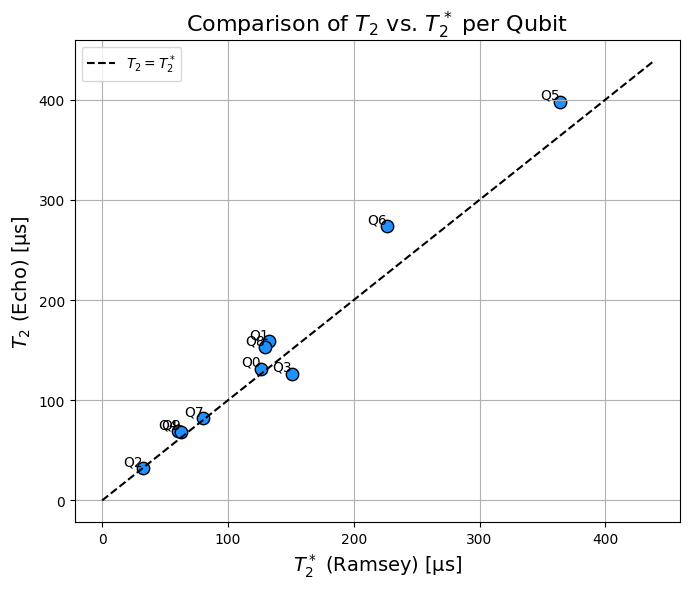

In [20]:
import matplotlib.pyplot as plt

def plot_t2_vs_t2star(t2_estimates, t2_ramsey_estimates):
    t2_vals = []
    t2star_vals = []
    labels = []

    for q in range(len(t2_estimates)):
        t2_fit_echo = t2_estimates[q][1]
        t2_fit = t2_ramsey_estimates[q][1]


        t2_vals.append(t2_fit_echo)
        t2star_vals.append(t2_fit)  # T2* is the second param in [A, T2*, B]
        labels.append(q)

    if len(t2_vals) != len(t2star_vals):
        raise ValueError(f"Mismatch: {len(t2_vals)} echo values vs {len(t2star_vals)} Ramsey values")

    plt.figure(figsize=(7, 6))
    plt.scatter(t2star_vals, t2_vals, c='dodgerblue', edgecolors='k', s=80)

    max_val = max(max(t2_vals), max(t2star_vals)) * 1.1
    plt.plot([0, max_val], [0, max_val], 'k--', label=r"$T_2 = T_2^*$")

    for x, y, q in zip(t2star_vals, t2_vals, labels):
        plt.text(x, y, f"Q{q}", fontsize=10, ha='right', va='bottom')

    plt.xlabel(r"$T_2^*$ (Ramsey) [µs]", fontsize=14)
    plt.ylabel(r"$T_2$ (Echo) [µs]", fontsize=14)
    plt.title(r"Comparison of $T_2$ vs. $T_2^*$ per Qubit", fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_t2_vs_t2star(t2_estimates, t2_estimates_Ramsey)


C:\Users\bobni\AppData\Local\Temp\ipykernel_10228\1115440334.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='T2 (µs)', data=data, width=0.5, fliersize=0, palette="pastel")
C:\Users\bobni\AppData\Local\Temp\ipykernel_10228\1115440334.py:21: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='Method', y='T2 (µs)', data=data, jitter=True, size=8,


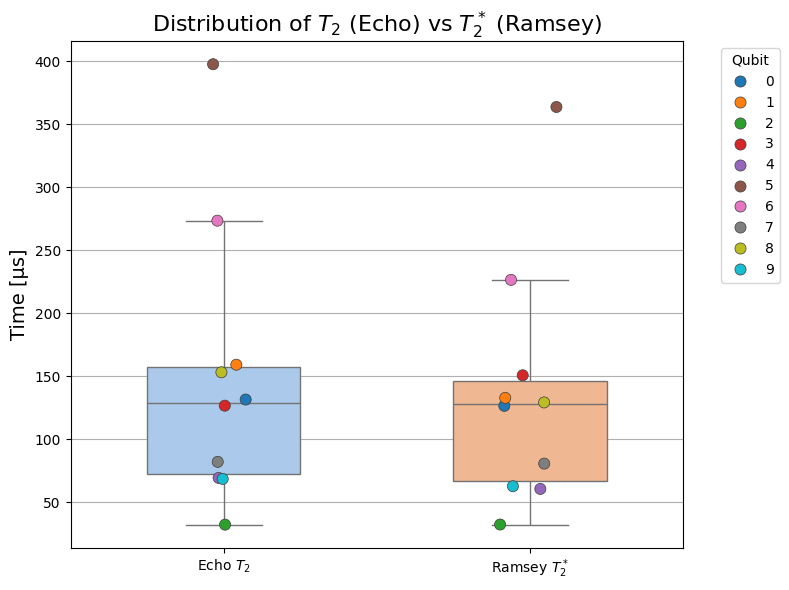

In [21]:
import seaborn as sns

def boxplot_t2_comparison(t2_estimates, t2_estimates_Ramsey, max_us=500):
    # Collect valid and filtered data
    data = {'Method': [], 'T2 (µs)': [], 'Qubit': []}
    for q in t2_estimates:
        t2 = t2_estimates[q][1]
        t2_star = t2_estimates_Ramsey[q][1]
        if t2 and t2 < max_us:
            data['Method'].append('Echo $T_2$')
            data['T2 (µs)'].append(t2)
            data['Qubit'].append(q)
        if t2_star and t2_star < max_us:
            data['Method'].append('Ramsey $T_2^*$')
            data['T2 (µs)'].append(t2_star)
            data['Qubit'].append(q)

    # Create boxplot with scatter overlay
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Method', y='T2 (µs)', data=data, width=0.5, fliersize=0, palette="pastel")
    sns.stripplot(x='Method', y='T2 (µs)', data=data, jitter=True, size=8,
                  hue='Qubit', palette='tab10', dodge=False, marker='o',
                  edgecolor='gray', linewidth=0.5)

    plt.title(r"Distribution of $T_2$ (Echo) vs $T_2^*$ (Ramsey)", fontsize=16)
    plt.ylabel("Time [µs]", fontsize=14)
    plt.xlabel("")
    plt.legend(title="Qubit", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Example usage:
boxplot_t2_comparison(t2_estimates, t2_estimates_Ramsey)


## Plot Map of QPU with errors etc.

In [22]:
from qiskit.visualization import plot_error_map, plot_coupling_map
from qiskit.transpiler import CouplingMap
from graphviz import Graph 


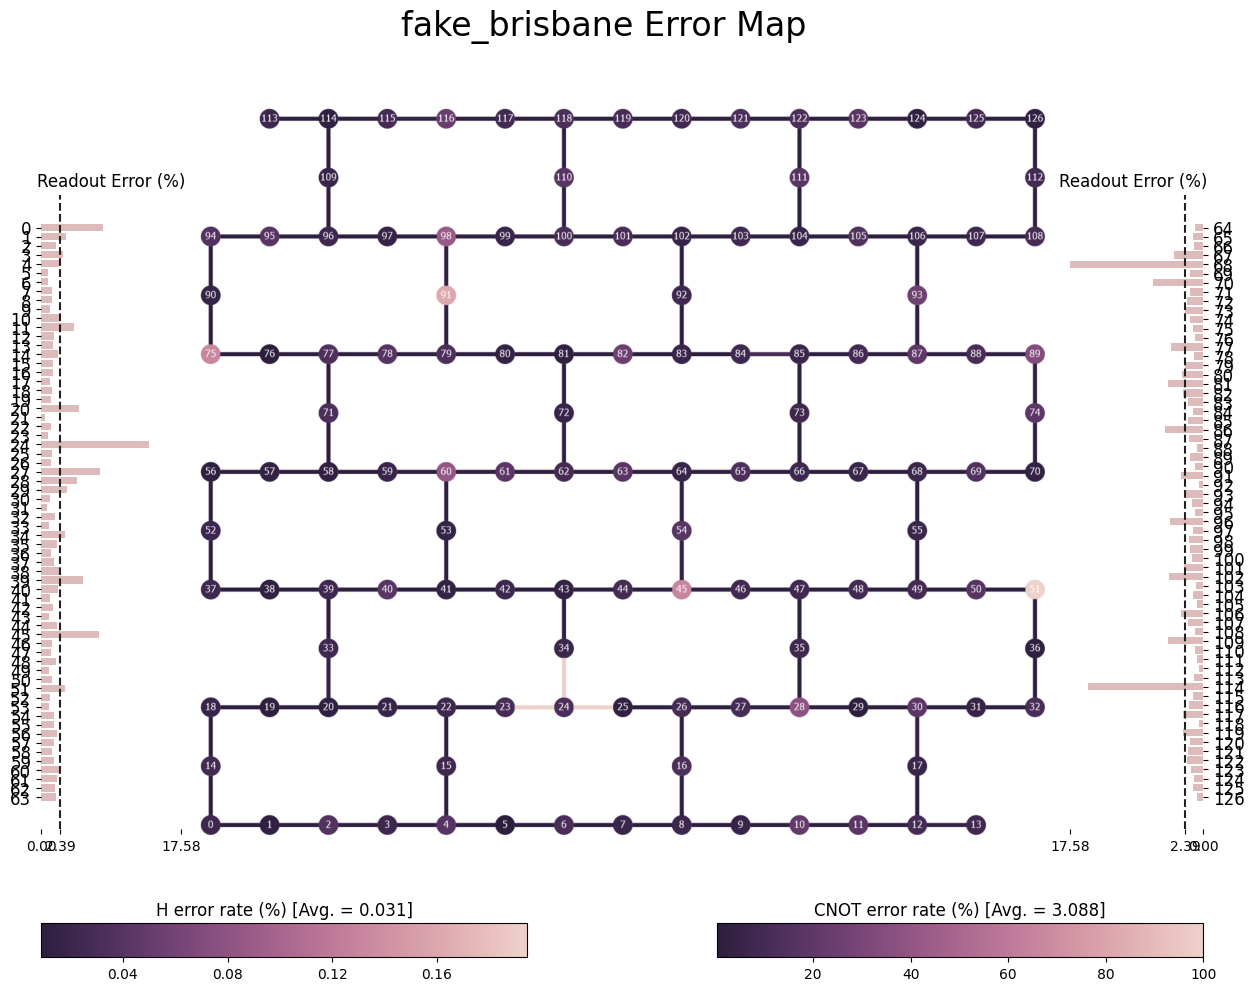

In [23]:
plot_error_map(backend)
# plot_error_map(backend, figsize=(30, 24))

## T1 - Excited State lifetime

Next we can measure T1 (the lifetime of the qubits)

In [24]:
# T1 decay function
def exp_decay(t, A, T1, B):
    return A * np.exp(-t / T1) + B

# Parallel T1 circuit generator
def parallel_t1(delay, backend, num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        qc.x(q)  # excite
        qc.delay(delay, q, unit="s")  # wait
        qc.measure(q, q)
    return qc

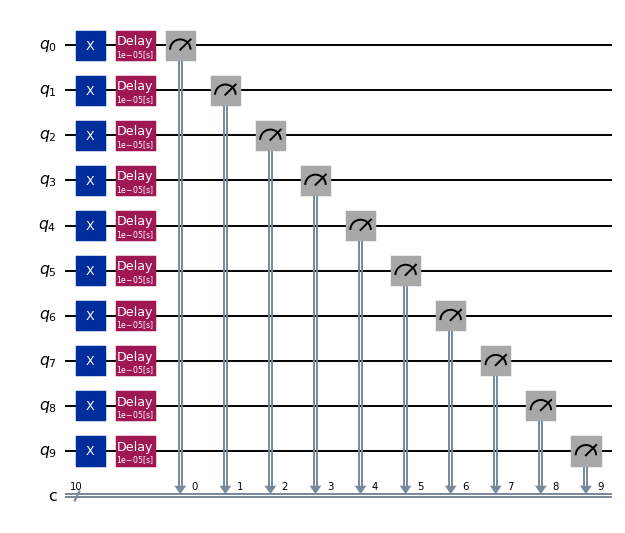

In [25]:
circuit = parallel_t1( 10e-6, backend, num_qubits=10)
circuit.draw('mpl',scale=0.7)

In [26]:
backend = FakeBrisbane()
num_qubits = 10  # or more
delays_us = [1, 50, 100, 200, 300, 400 ,500 ]  # microseconds
delay_times = [d * 1e-6 for d in delays_us]  # convert to seconds

shots = 1000
# Run circuits and collect data
probs_per_qubit = {q: [] for q in range(num_qubits)}

for delay in delay_times:
    print(round(delay,6))
    circuit = parallel_t1(delay, backend, num_qubits)
    transpiled = transpile(circuit, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()

    for qubit in range(num_qubits):
        one_count = 0
        for bitstring, count in counts.items():
            if bitstring[::-1][qubit] == '1':
                one_count += count
        probs_per_qubit[qubit].append(one_count / shots)


1e-06
5e-05
0.0001
0.0002
0.0003
0.0004
0.0005



Estimated T₁ values (in µs):
Qubit 0: T₁ ≈ 215.68 µs
Qubit 1: T₁ ≈ 272.66 µs
Qubit 2: T₁ ≈ 260.05 µs
Qubit 3: T₁ ≈ 118.55 µs
Qubit 4: T₁ ≈ 190.41 µs
Qubit 5: T₁ ≈ 256.87 µs
Qubit 6: T₁ ≈ 247.94 µs
Qubit 7: T₁ ≈ 130.57 µs
Qubit 8: T₁ ≈ 226.03 µs
Qubit 9: T₁ ≈ 176.84 µs


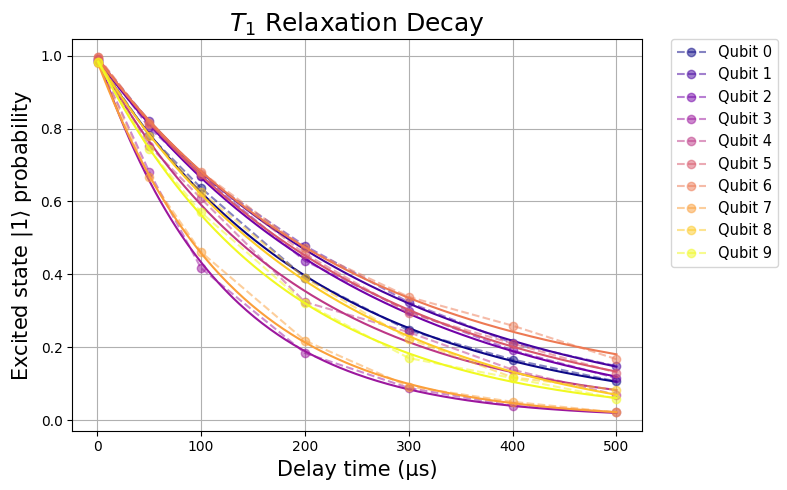

In [33]:
# Define exponential decay model
def exp_decay(t, A, T, B):
    return A * np.exp(-t / T) + B

# Fit T₁ for each qubit and store full fit parameters
t1_estimates = {}

for q in range(num_qubits):
    try:
        popt, _ = curve_fit(
            exp_decay,
            delays_us,
            probs_per_qubit[q],
            p0=[0.9, 50, 0.1]
        )
        t1_estimates[q] = popt  # Save full [A, T1, B]
    except RuntimeError:
        t1_estimates[q] = None

# Print results
print("\nEstimated T₁ values (in µs):")
for q in range(num_qubits):
    fit = t1_estimates[q]
    if fit is not None:
        print(f"Qubit {q}: T₁ ≈ {fit[1]:.2f} µs")
    else:
        print(f"Qubit {q}: Fit failed")

# Plot decay curves
plt.figure(figsize=(8, 5))
fs = 15
colors = plt.cm.plasma(np.linspace(0, 1, num_qubits))

for q in range(num_qubits):
    # Plot experimental data
    plt.plot(delays_us, probs_per_qubit[q], 'o--', label=f"Qubit {q}", color=colors[q], alpha=0.5)

    # Plot fitted decay curve if fit succeeded
    fit = t1_estimates[q]
    if fit is not None:
        A, T1, B = fit
        t_fit = np.linspace(min(delays_us), max(delays_us), 200)
        plt.plot(t_fit, exp_decay(t_fit, A, T1, B), '-', color=colors[q])

plt.xlabel("Delay time (µs)", fontsize=fs)
plt.ylabel(r'Excited state $|1\rangle$ probability', fontsize=fs)
plt.title(r"$T_1$ Relaxation Decay", fontsize=fs * 1.2)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=fs * 0.7)
plt.tight_layout()
plt.show()


# Compare T1 and T2

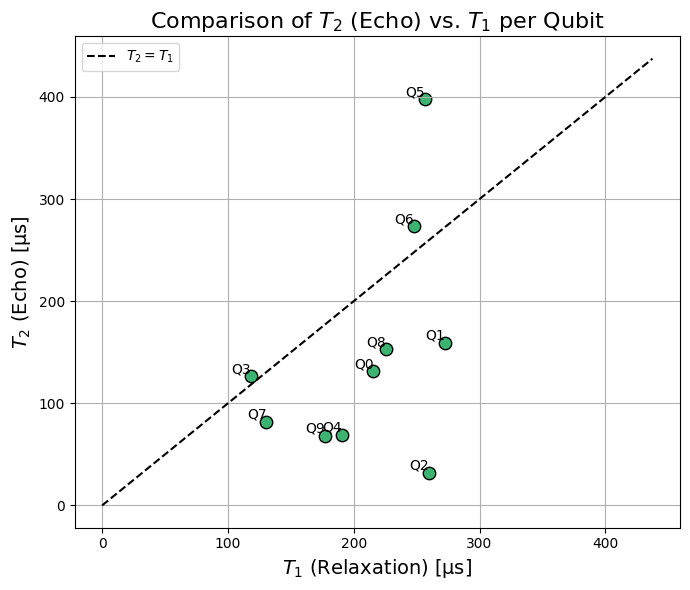

In [35]:
def plot_t2_vs_t1(t2_estimates_echo, t1_estimates):
    t2_vals = []
    t1_vals = []
    labels = []

    for q in range(len(t2_estimates_echo)):
        t2_fit = t2_estimates_echo.get(q)
        t1_fit = t1_estimates.get(q)

        if t2_fit is None or t1_fit is None:
            continue  # Skip qubits where fit failed

        t2_vals.append(t2_fit[1])  # T2 (echo)
        t1_vals.append(t1_fit[1])  # T1
        labels.append(q)

    if not t2_vals or not t1_vals:
        print("No valid data to plot.")
        return

    plt.figure(figsize=(7, 6))
    plt.scatter(t1_vals, t2_vals, c='mediumseagreen', edgecolors='k', s=80)

    max_val = max(max(t2_vals), max(t1_vals)) * 1.1
    plt.plot([0, max_val], [0, max_val], 'k--', label=r"$T_2 = T_1$")

    for x, y, q in zip(t1_vals, t2_vals, labels):
        plt.text(x, y, f"Q{q}", fontsize=10, ha='right', va='bottom')

    plt.xlabel(r"$T_1$ (Relaxation) [µs]", fontsize=14)
    plt.ylabel(r"$T_2$ (Echo) [µs]", fontsize=14)
    plt.title(r"Comparison of $T_2$ (Echo) vs. $T_1$ per Qubit", fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_t2_vs_t1(t2_estimates, t1_estimates)


### Generally T2 must be shorter than T1

# Rabi Oscillations

In [36]:
# Create Rabi circuit with Rx rotation pulse train
def rabi_circuit(reps, theta, qubit, num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    for _ in range(reps):
        qc.rx(theta, qubit)
        qc.barrier()
    qc.measure(qubit, qubit)
    return qc


In [37]:
# Setup
backend = FakeBrisbane()
num_qubits = 1
qubit = 0

theta = 0.15 * np.pi  # Small angle per step
steps = list(range(1, 30))  # Vary number of repetitions
theta_steps = [reps*theta for reps in steps]


# Run experiments
shots=1000
probs = []

for reps in steps:
    print(reps*theta/(2*pi))
    qc = rabi_circuit(reps, theta, qubit, num_qubits)
    transpiled = transpile(qc, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    probs.append(counts['1']/shots)


0.075
0.15
0.225
0.3
0.375
0.45
0.525
0.6
0.675
0.75
0.825
0.9
0.975
1.05
1.125
1.2
1.275
1.35
1.425
1.5
1.575
1.65
1.725
1.8
1.8749999999999998
1.95
2.0250000000000004
2.1
2.175


In [48]:
# Access instruction durations
inst_durations = backend.target.durations()

# Get duration for a specific gate and qubits
x_duration = inst_durations.get('x', (0))  
dt = backend.configuration().dt  # Time per 'dt' unit
x_time_sec = x_duration * dt
x_time_ns = x_time_sec * 1e9

print(f"X duration on qubits (0): {x_time_ns:.1f} ns")


X duration on qubits (0): 60.0 ns


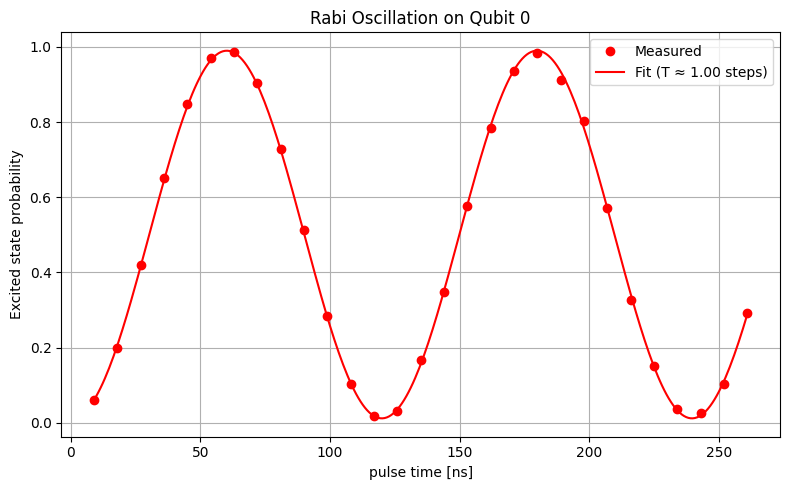

Rabi period Error (vs. calibration)=  0.3294173470944739 %


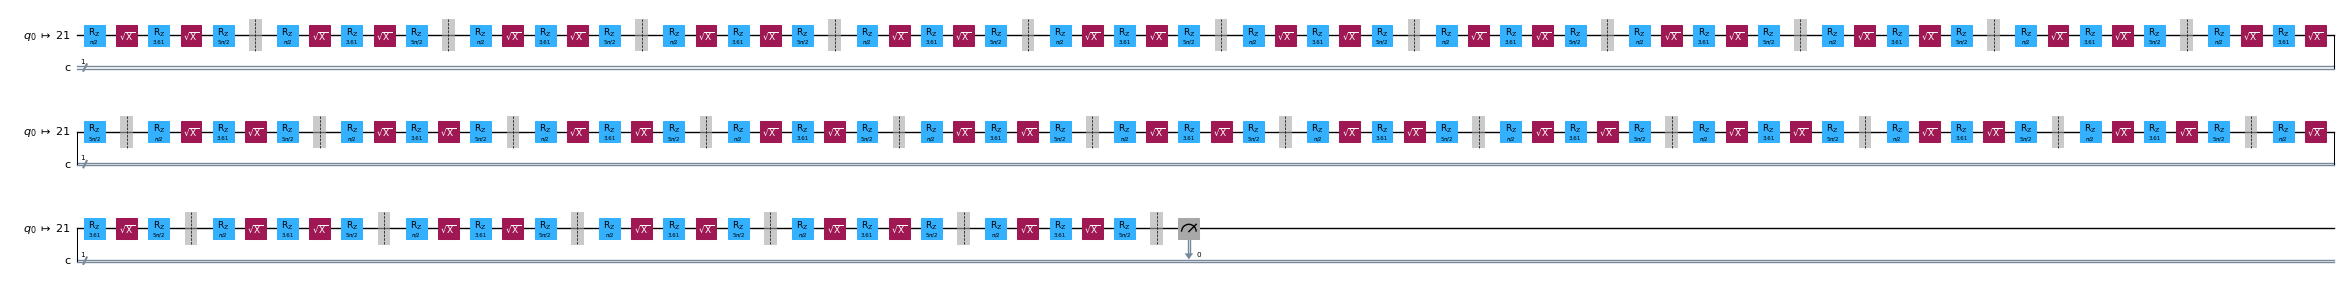

In [50]:
# Sinusoidal model for Rabi oscillation
def rabi_model(t, A, omega, phi, B):
    return A * np.cos(omega * t + phi) + B

# Fit to cosine model
try:
    popt, _ = curve_fit(rabi_model, theta_steps, probs, p0=[0.5, 1.0000, 0, 0.5])
    A, omega, phi, B = popt
    rabi_period = 1 / omega
except RuntimeError:
    rabi_period = None

# Plot
plt.figure(figsize=(8, 5))
plt.plot(np.array(theta_steps)/(pi)*x_time_ns, probs, 'or', label='Measured')
if rabi_period:
    t_fit = np.linspace(min(theta_steps), max(theta_steps), 300)
    plt.plot(t_fit/(pi)*x_time_ns, rabi_model(t_fit, *popt), '-r',label=f"Fit (T ≈ {rabi_period:.2f} steps)")

plt.xlabel("pulse time [ns]")
plt.ylabel("Excited state probability")
plt.title(f"Rabi Oscillation on Qubit {qubit}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print('Rabi period Error (vs. calibration)= ', abs(rabi_period-1)*100 ,'%')

transpiled.draw('mpl', idle_wires=False,scale=0.5, fold=70)

In [ ]:
backend = FakeBrisbane()
num_qubits = 1
qubit = 0

reps = 15
theta = np.pi  # Small angle per step
steps = list(range(1, reps))  # Number of rotations
theta_steps = [reps*theta for reps in steps]

# Run experiments
probs = []
shots=1000

for reps in steps:
    print(reps*theta/(pi))
    qc = rabi_circuit(reps, theta, qubit, num_qubits)
    transpiled = transpile(qc, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    probs.append(counts['1']/shots)

0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.499999999999999
6.0
6.500000000000001
7.0


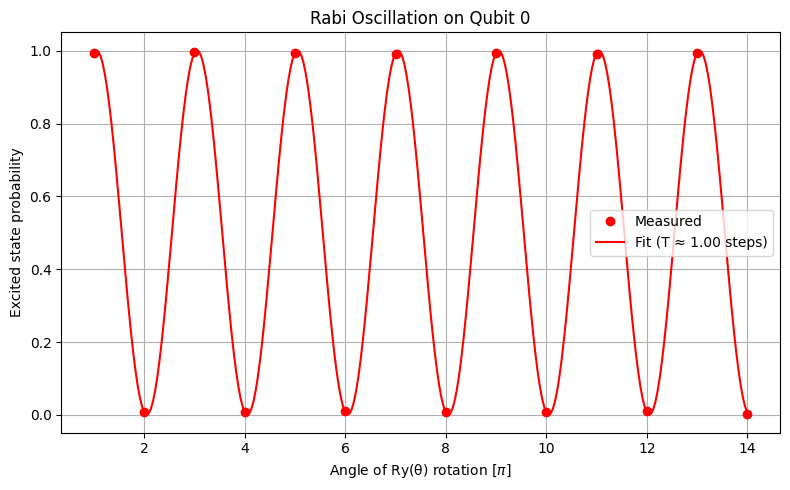

Rabi period Error (vs. calibration)=  0.013134232570255477 %


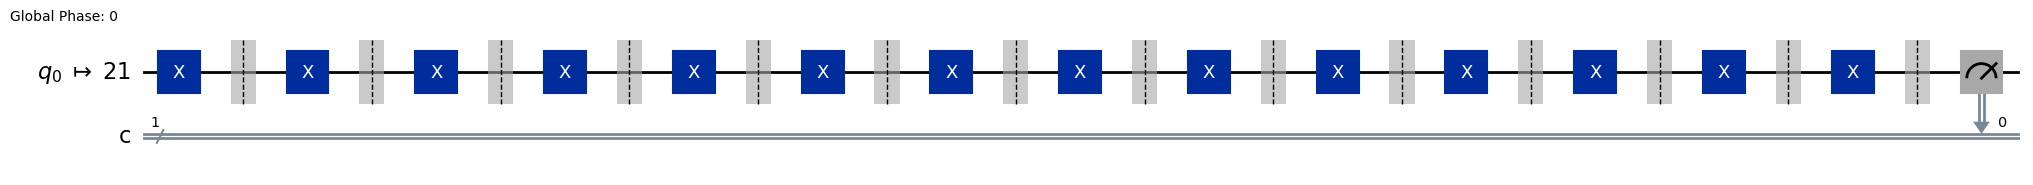

In [56]:
# Sinusoidal model for Rabi oscillation
def rabi_model(t, A, omega, phi, B):
    return A * np.cos(omega * t + phi) + B

# Fit to cosine model
try:
    popt, _ = curve_fit(rabi_model, theta_steps, probs, p0=[0.5, 1.0000, 0, 0.5], bounds=([0.49, 0.95, -np.pi, 0], [0.50, 1.05, np.pi, 0.55]))
    A, omega, phi, B = popt
    rabi_period = 1 / omega
except RuntimeError:
    rabi_period = None

# Plot
plt.figure(figsize=(8, 5))
plt.plot(np.array(theta_steps)/(pi), probs, 'or', label='Measured')
if rabi_period:
    t_fit = np.linspace(min(theta_steps), max(theta_steps), 300)
    plt.plot(t_fit/(pi), rabi_model(t_fit, *popt), '-r',label=f"Fit (T ≈ {rabi_period:.2f} steps)")

plt.xlabel(r'Angle of Ry(θ) rotation [$\pi$]')
plt.ylabel("Excited state probability")
plt.title(f"Rabi Oscillation on Qubit {qubit}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


print('Rabi period Error (vs. calibration)= ', abs(rabi_period-1)*100 ,'%')


display(transpiled.draw('mpl', idle_wires=False,fold=reps*2+1))

# Gate Benchmarking

Adding many gates in sequence can calibrate their fidelity

In [718]:
backend = FakeBrisbane()
num_qubits = 1
qubit = 0

n_gates = 500
skip = 50

shots = 1000
probs = []

# Run experiments
for gates in list(range(0, n_gates, skip)):  # Skip specified number of circuits
    print(gates)
    qc = QuantumCircuit(num_qubits)
    for _ in range(gates):
        qc.x(qubit)
        qc.barrier()
        qc.x(qubit)
        qc.barrier()

    qc.x(qubit)
    qc.barrier()
    qc.measure_all()

    transpiled = transpile(qc, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    probs.append(counts['1']/shots)

0
50
100
150
200
250
300
350
400
450


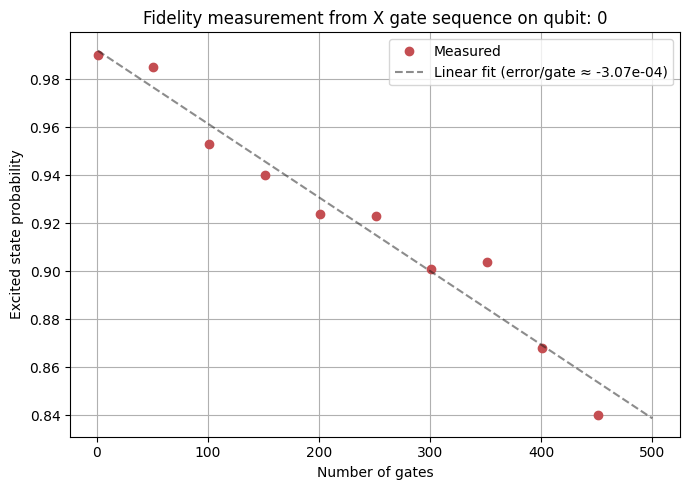

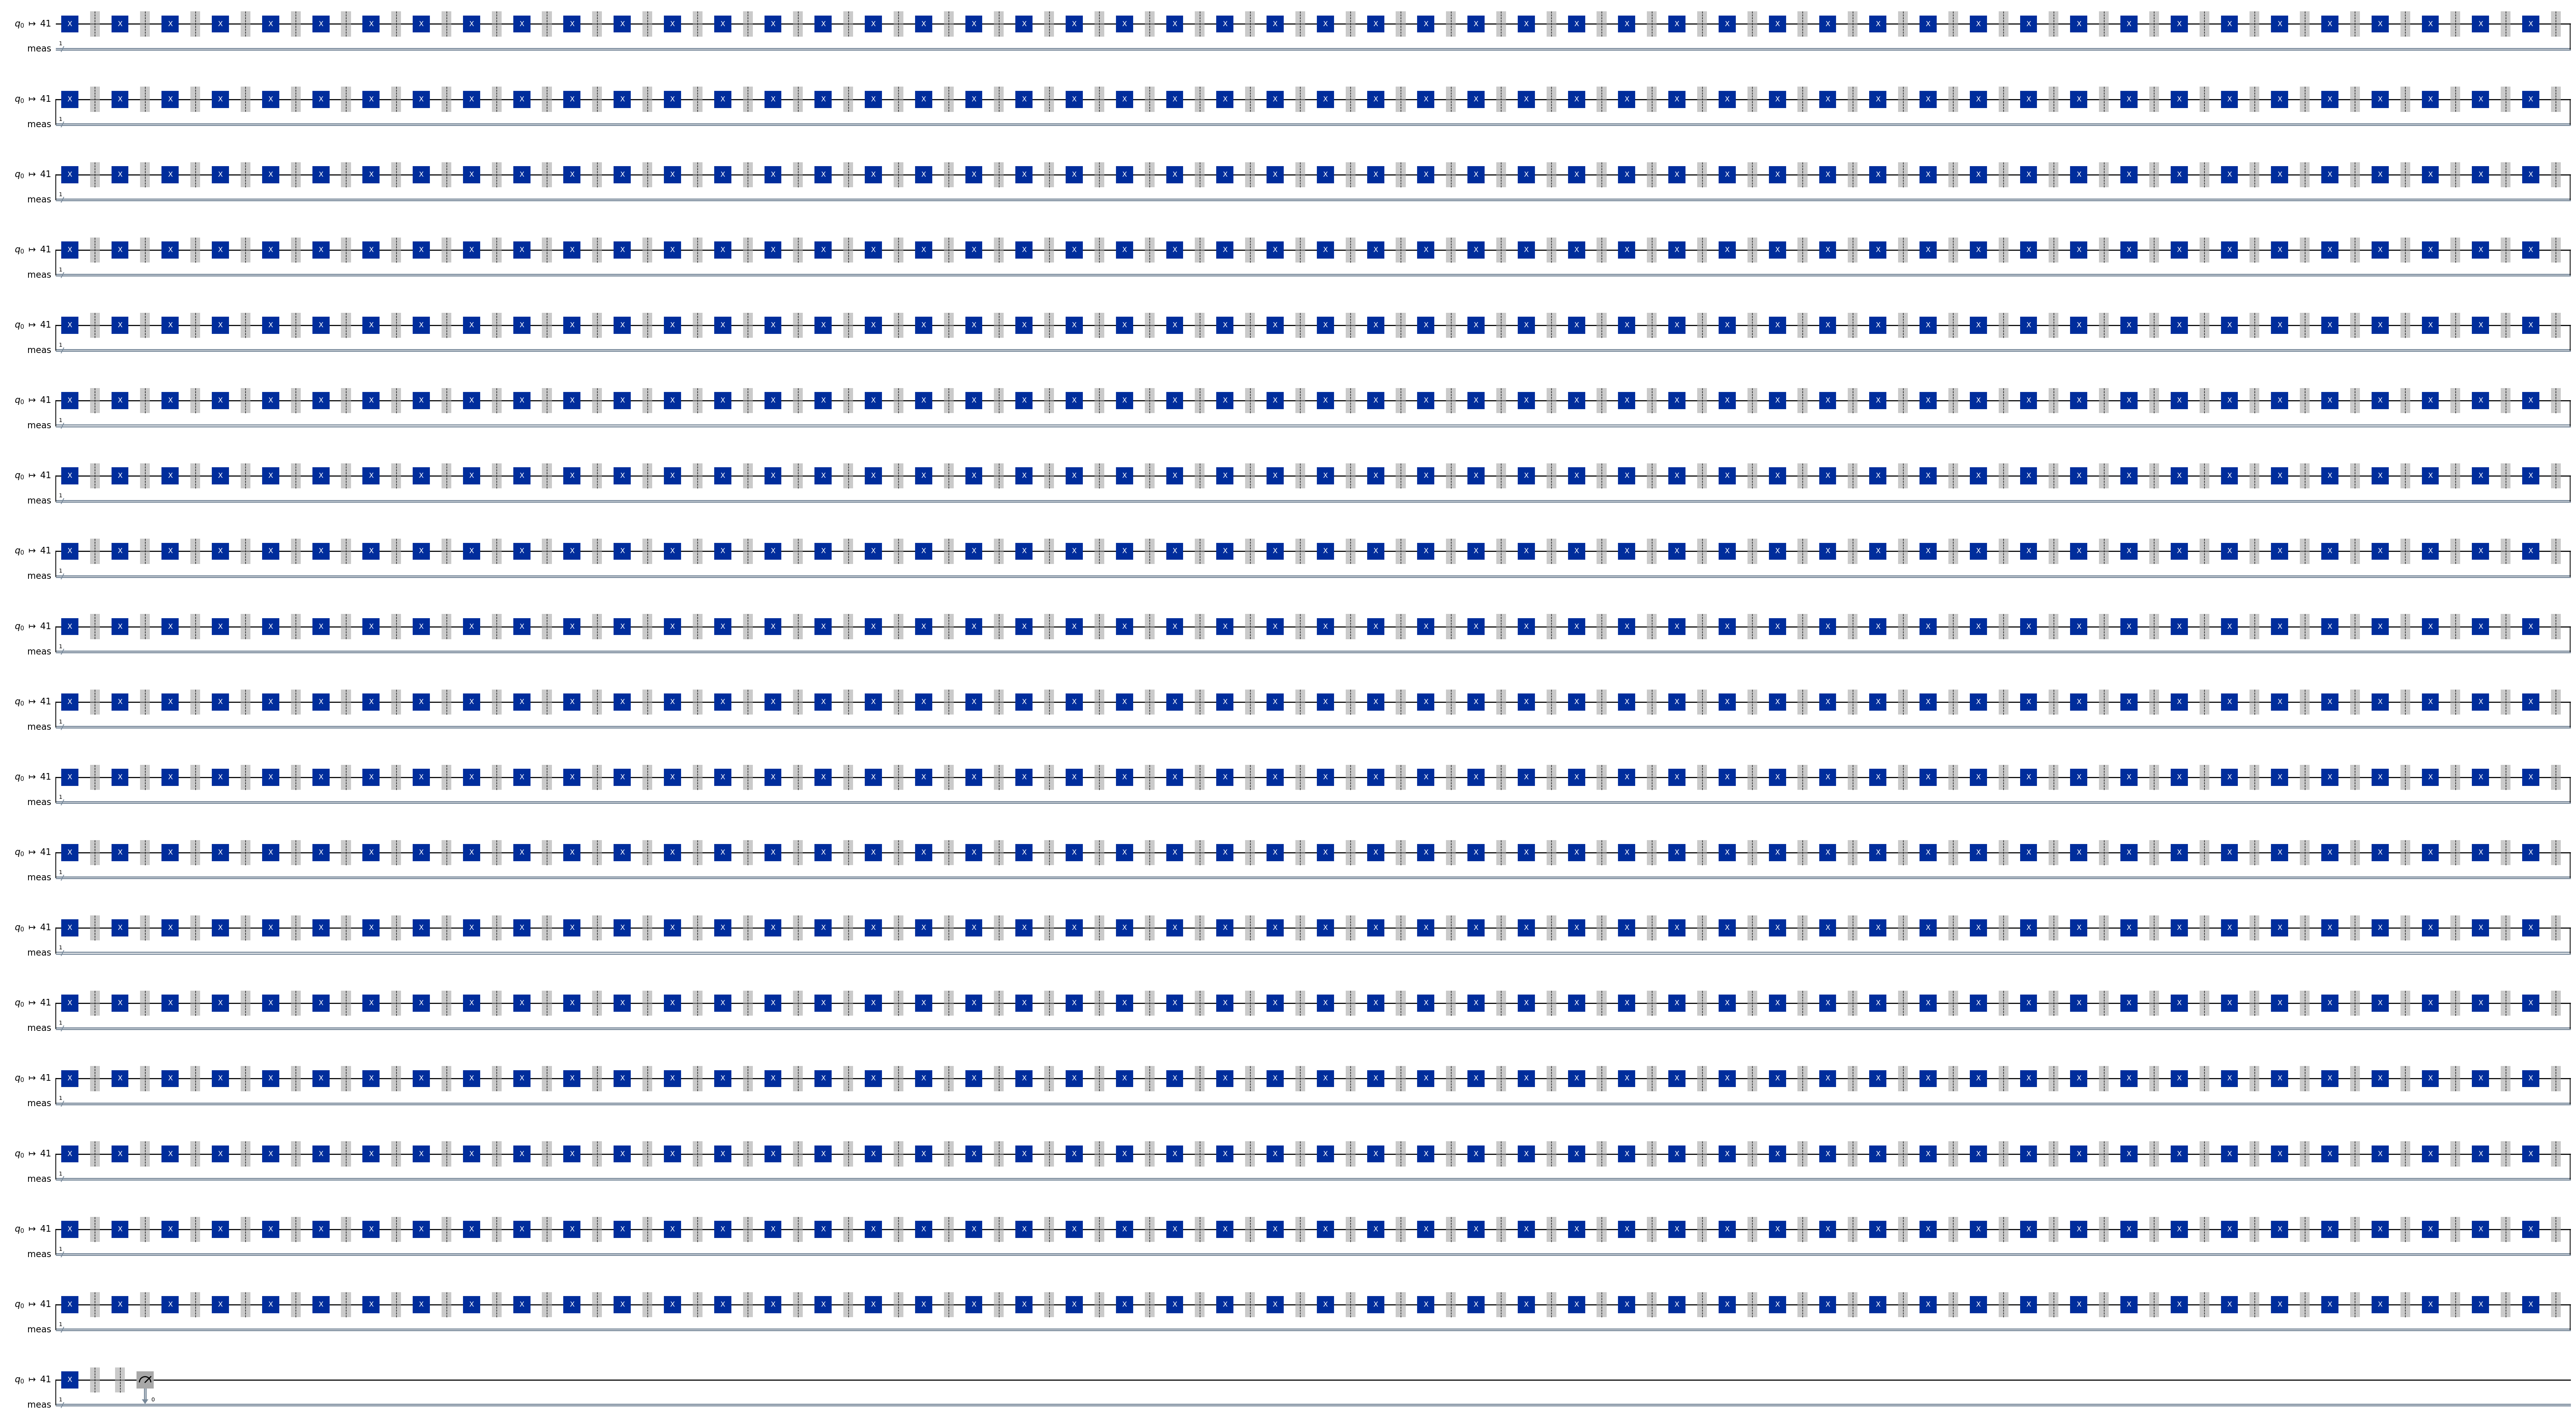

In [742]:
# Linear model
def line(t, m, b):
    return m*t + b

# Fit linear model
try:
    popt, _ = curve_fit(line, list(range(1, n_gates, skip)), np.array(probs))
    m, b = popt
except RuntimeError:
    m, b = None, None

# Plot
plt.figure(figsize=(7, 5))
plt.plot(list(range(1, n_gates, skip)), np.array(probs), 'or', label='Measured')
if m is not None:
    t_fit = np.linspace(1, n_gates, n_gates*2)
    plt.plot(t_fit, line(t_fit, *popt), '--k',
             alpha=0.5, label=f'Linear fit (error/gate ≈ {m:.2e})')

plt.xlabel('Number of gates')
plt.ylabel("Excited state probability") 
plt.title(f"Fidelity measurement from X gate sequence on qubit: {qubit}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

display(transpiled.draw('mpl', idle_wires=False,fold=100))

# Randomized Gate Benchmarking

In [682]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
from qiskit.circuit.library import RXGate, RYGate, RZGate, IGate


def random_rotation_gate(angle):
    """Return a random rotation gate (X, Y, Z, or I) with the given angle."""
    gate_type = random.choice(['x', 'y', 'z', 'i'])
    if gate_type == 'x':
        return RXGate(angle)
    elif gate_type == 'y':
        return RYGate(angle)
    elif gate_type == 'z':
        return RZGate(angle)
    else:
        return IGate()

def randomized_benchmarking_circuit(reps, qubit=0, num_qubits=1, target_final_state='1'):
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc_to_inv = QuantumCircuit(num_qubits, num_qubits)

    for _ in range(reps):
        # Random π gate
        gate_pi = random_rotation_gate(np.pi)
        qc.append(gate_pi, [qubit])
        qc_to_inv.append(gate_pi, [qubit])

        # Random π/2 gate
        gate_pio2 = random_rotation_gate(np.pi/2)
        qc.append(gate_pio2, [qubit])
        qc.barrier()
        qc_to_inv.append(gate_pio2, [qubit])

    '''
    Invert the initial gate sequence
    Then use the transpiler to simplify it and add it back to the original circuit
    '''
    qc_inv = qc_to_inv.inverse()
    qc_inv_transpiled = transpile(qc_inv, backend,initial_layout=[0])
    qc_transpiled = transpile(qc, backend,initial_layout=[0])

    # display(qc_inv_transpiled.draw(output='mpl',idle_wires=False))
    # display(qc_transpiled.draw(output='mpl',idle_wires=False))
    qc_transpiled.barrier()
    qc_transpiled.compose(qc_inv_transpiled,inplace=True)
    qc_transpiled.barrier()

    # Flip to |1⟩ 
    if target_final_state == '1':
        qc_transpiled.x(qubit)
        qc_transpiled.barrier()

    qc_transpiled.measure(qubit, qubit)
    return qc_transpiled


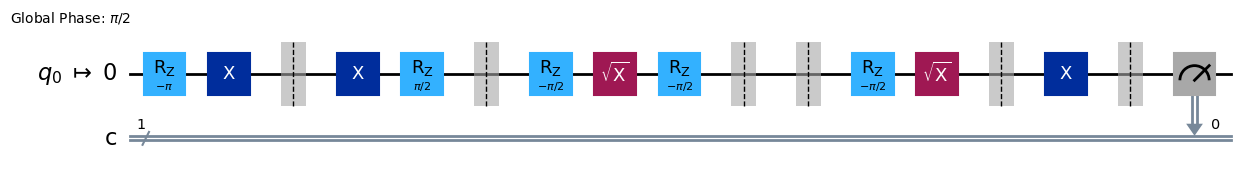

In [684]:
rbc = randomized_benchmarking_circuit(3, qubit=0, num_qubits=1)
rbc.draw('mpl',idle_wires=False)

In [ ]:
# Setup
backend = FakeBrisbane()
num_qubits = 1
qubit = 0

n_gates = 1000
skip = 100

shots = 1000
probs = []

# Run experiments
for gates in list(range(0, n_gates, skip)):  # Skip specified number of circuits
    print(gates)
    
    rbc = randomized_benchmarking_circuit(gates, qubit=0, num_qubits=1)

    transpiled = transpile(rbc, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    probs.append(counts['1']/shots)


0
100
200
300
400
500
600
700
800
900


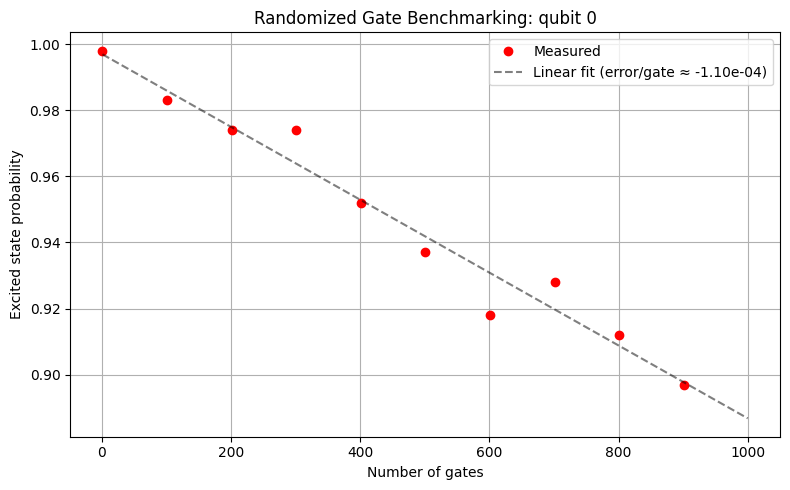

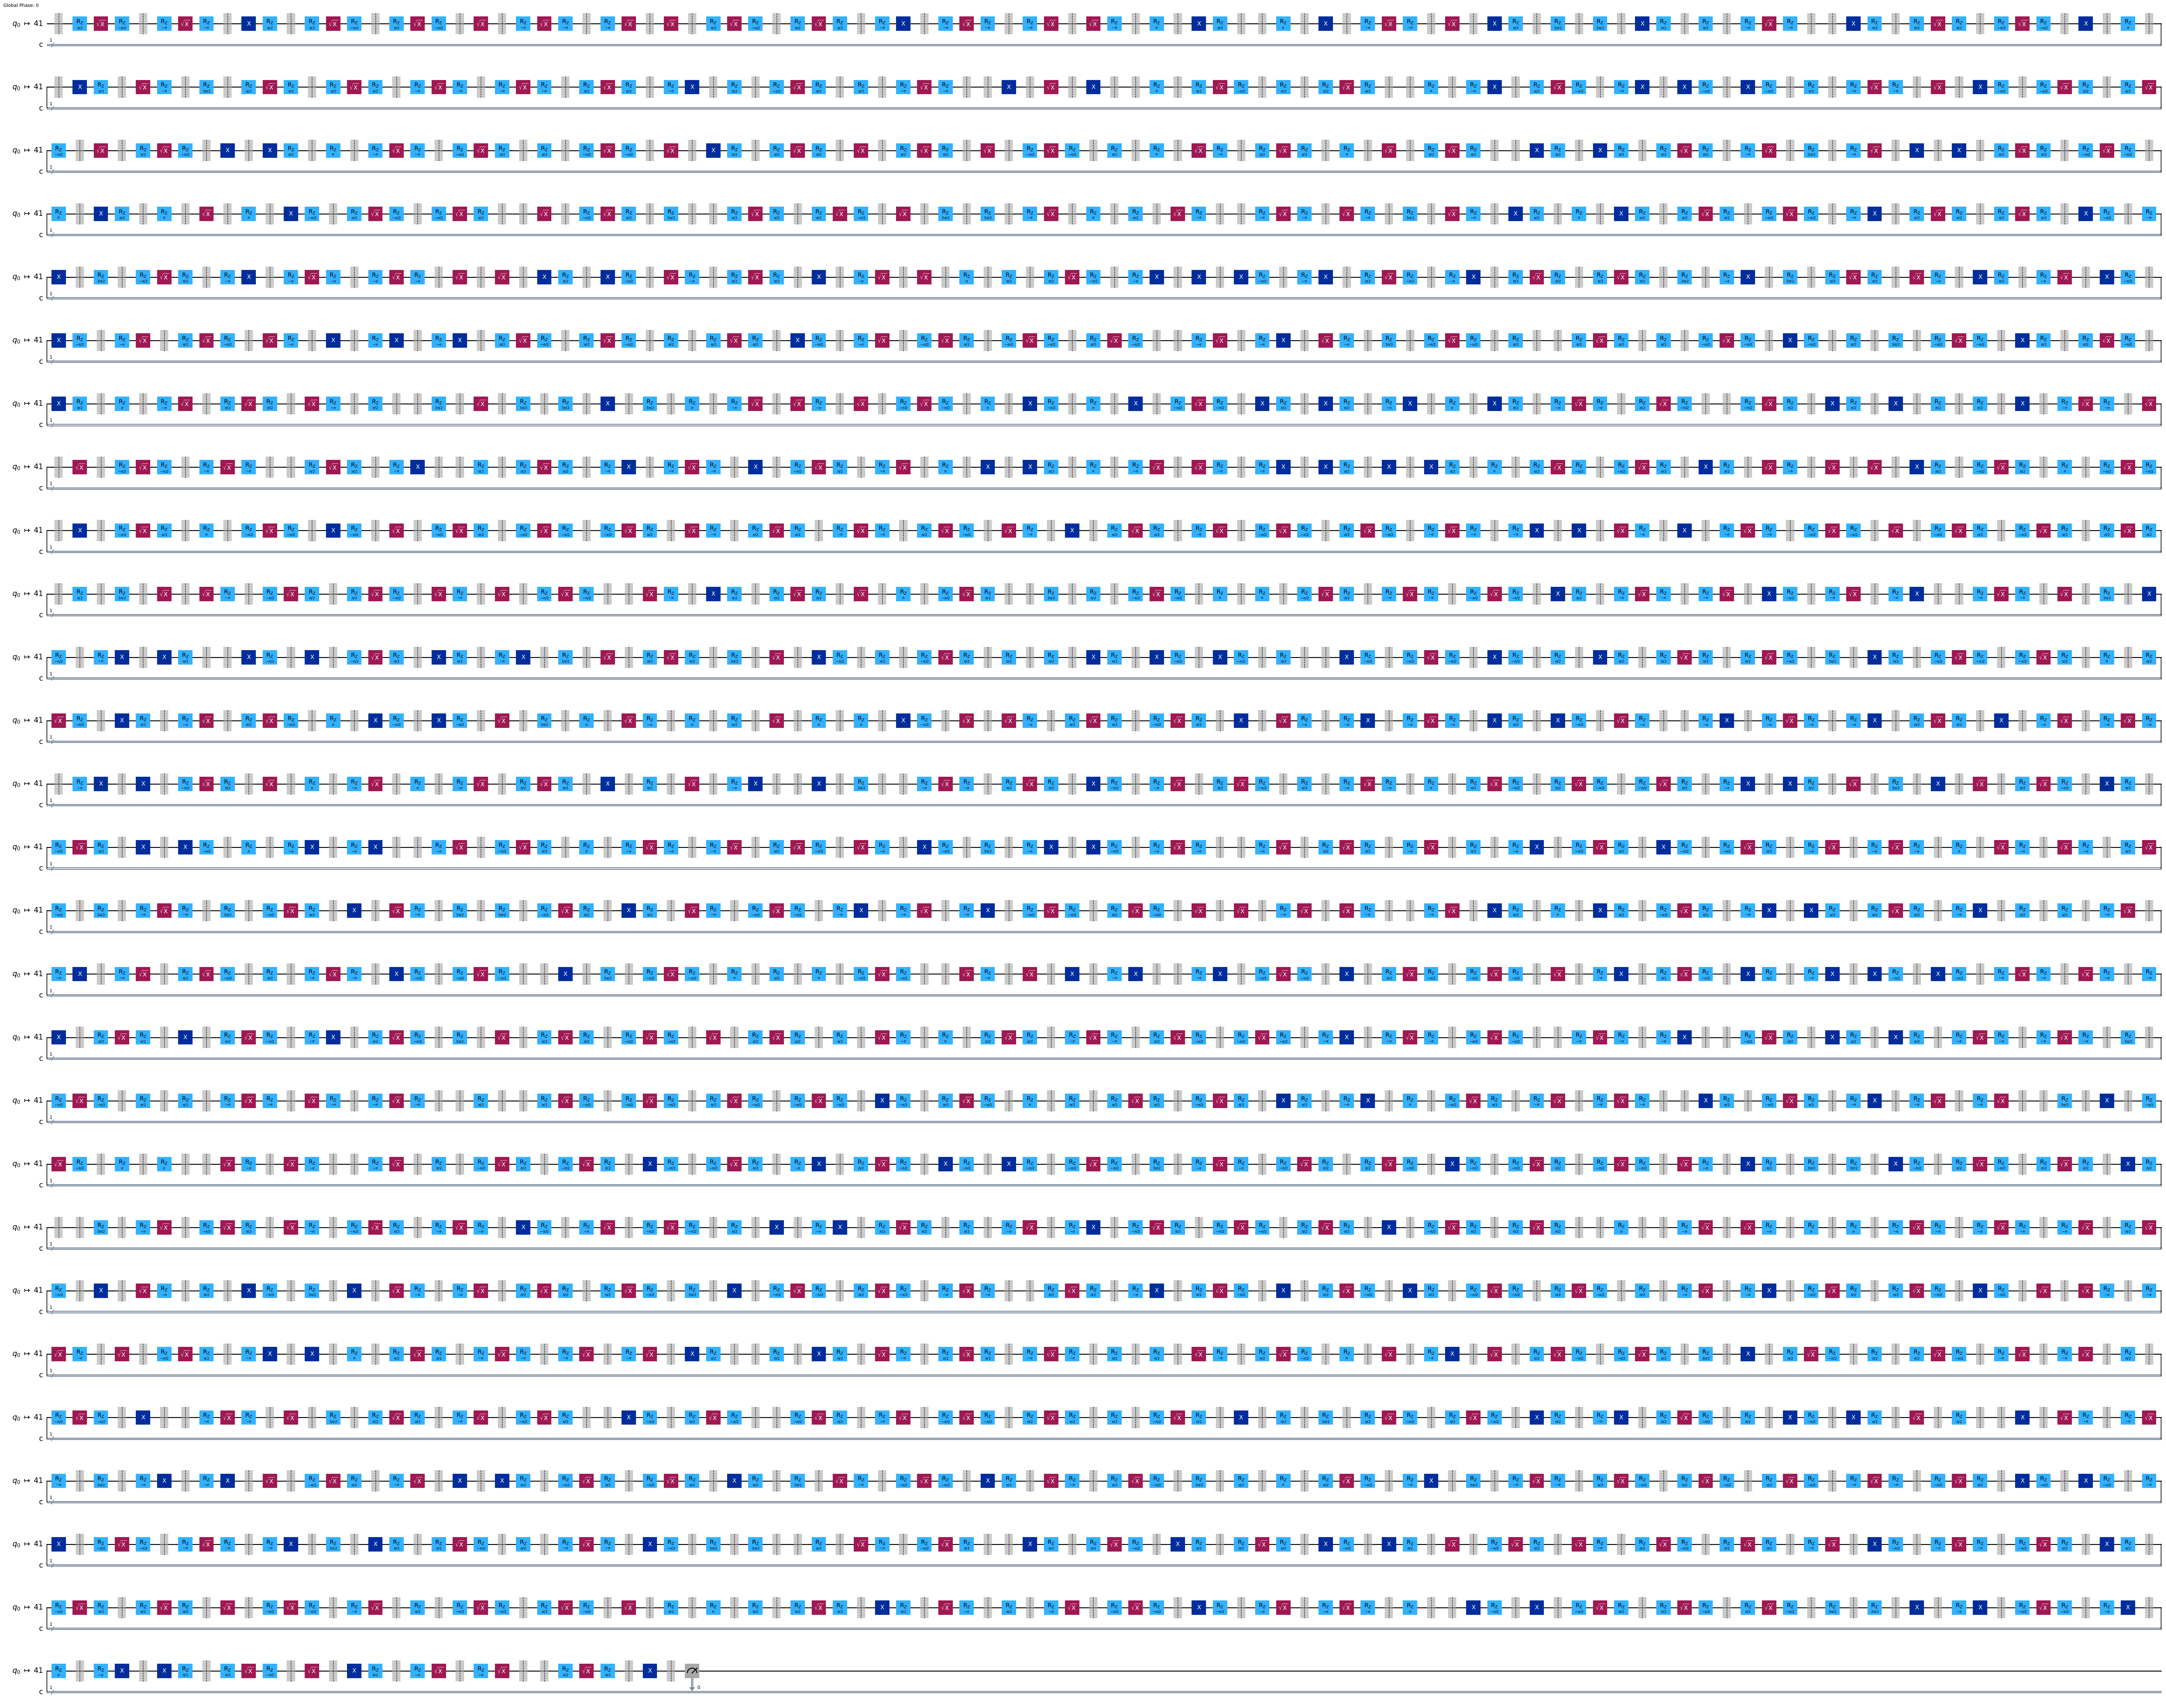

In [ ]:
def line(t, m, b):
    return m*t + b

try:
    popt, _ = curve_fit(line, list(range(1, n_gates, skip)), np.array(probs))
    m, b = popt
except RuntimeError:
    m, b = None, None

# Plot
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, n_gates, skip)), np.array(probs), 'or', label='Measured')
if m is not None:
    t_fit = np.linspace(1, n_gates, n_gates*2)
    plt.plot(t_fit, line(t_fit, *popt), '--k',
             alpha=0.5, label=f'Linear fit (error/gate ≈ {m:.2e})')

plt.xlabel('Number of gate pairs')
plt.ylabel("Excited state probability") 
plt.title(f"Randomized Gate Benchmarking: qubit {qubit}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

display(transpiled.draw('mpl', idle_wires=False,fold=100))

# GHZ states - Greenberger–Horne–Zeilinger (GHZ) states

>https://arxiv.org/abs/1807.05572 - Efficient quantum algorithms for GHZ and W states, and implementation on the IBM quantum computer

>https://arxiv.org/abs/2312.15170 - Characterization of entanglement on superconducting quantum computers of up to 414 qubits

>https://docs.quantinuum.com/systems/trainings/knowledge_articles/Quantinuum_n56_ghz_state_fidelity.html



In [7]:
def create_ghz_circuit(num_qubits, phi):
    """
    Creates a GHZ state circuit with parity rotation around Z-axis
    for parity oscillation measurement.
    
    Args:
        num_qubits (int): Number of qubits for GHZ state.
        phi (float): Phase rotation angle to apply to each qubit.
        
    Returns:
        QuantumCircuit: GHZ state with Rz(phi) gates applied.
    """
    qc = QuantumCircuit(num_qubits, num_qubits)


    '''Initial Superposition'''
    qc.h(0)
    
    '''CNOTs to generate Entanglement'''
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
        
    qc.barrier()

    '''Global rotation to generate parity oscillations'''
    for i in range(num_qubits):
        qc.u(pi/2 ,phi,-phi,i)

    qc.barrier()

    # Measurement
    qc.measure(range(num_qubits), range(num_qubits))

    return qc


## GHZ circuit with the final analysis pulse

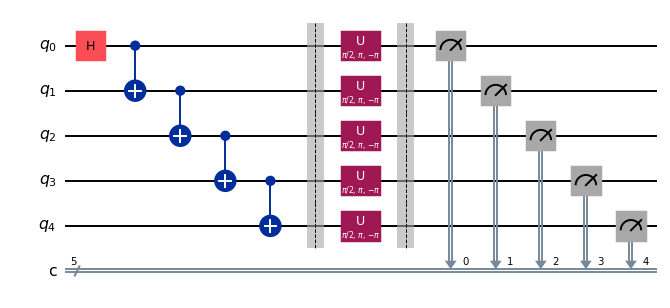

In [8]:
qc = create_ghz_circuit(5, pi)

qc.draw('mpl',scale=0.7)

In [19]:
def parity_probabilities(counts):
    """     Return even and odd parity probabilities from measurement counts.     """
    even = 0
    odd = 0
    total = 0

    for bitstring, count in counts.items():
        total += count
        if bitstring.count('1') % 2 == 0:
            even += count
        else:
            odd += count

    p_even = even / total
    p_odd = odd / total
    return p_even, p_odd


In [325]:
def run_parity_oscillations(num_qubits=3, num_shots=1024, num_points=30):
    """
    Sweep over phi values and measure parity using FakeBrisbane.
    """
    backend = FakeBrisbane()
    phi_vals = np.linspace(0, 2 * np.pi, num_points)
    p_even_vals = []
    p_odd_vals = []

    for phi in phi_vals:
        qc = create_ghz_circuit(num_qubits, phi)
        tqc = transpile(qc, backend)
        job = backend.run(tqc, shots=num_shots)
        result = job.result()
        counts = result.get_counts()
        p_even, p_odd = parity_probabilities(counts)
        p_even_vals.append(p_even)
        p_odd_vals.append(p_odd)

    return phi_vals, p_even_vals, p_odd_vals

In [18]:
def plot_parity_probabilities(phi_vals, p_even_vals, p_odd_vals, fs=14, title="GHZ Parity Oscillations"):
    """
    Plots the even and odd parity probabilities vs. rotation angle.

    Args:
        phi_vals (list or np.ndarray): Rotation angles (in radians).
        p_even_vals (list): Even parity probabilities.
        p_odd_vals (list): Odd parity probabilities.
        fs (int, optional): Font size for labels. Default is 14.
        title (str, optional): Plot title.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(phi_vals, p_even_vals, 'o-r', label='Even')
    plt.plot(phi_vals, p_odd_vals, 'o-b', label='Odd')
    plt.xlabel('Axis of analysis pulse [rad]', fontsize=fs)
    plt.ylabel('Probability', fontsize=fs)
    plt.title(title, fontsize=fs * 1.2)
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=fs * 0.7)
    plt.tight_layout()
    plt.show()

In [327]:
phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=5, num_shots=1024, num_points=30)

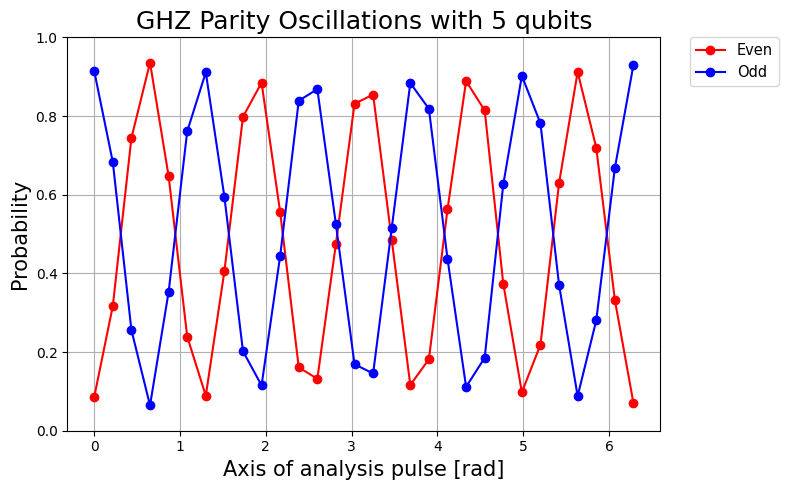

In [328]:
plot_parity_probabilities(phi_vals, p_even_vals, p_odd_vals, fs=15, title="GHZ Parity Oscillations with 5 qubits")

# Parity Contrast fit

To measure the fidelity we need to measure the contrast of the Parity oscillations

In [15]:
def _cosn_model(theta, A, theta0, B, n):
    """Cosine model with n oscillations."""
    return A * np.cos(n * theta + theta0) + B

def plot_parity_vs_theta_with_fit(theta_vals, p_even_vals, p_odd_vals, n_qubits, fs=14, title="GHZ Parity vs Axis Angle"):
    """
    Plots parity vs axis angle theta, fits even parity to extract contrast for n-qubit GHZ.

    Args:
        theta_vals (array): Rotation axis angles (radians).
        p_even_vals (array): Even parity probabilities.
        p_odd_vals (array): Odd parity probabilities.
        n_qubits (int): Number of qubits in the GHZ state.
        fs (int): Font size.
        title (str): Plot title.

    Returns:
        float: Extracted contrast.
    """
    theta_vals = np.array(theta_vals)
    p_even_vals = np.array(p_even_vals)

    # Fit to model: A * cos(n * θ + θ₀) + B
    def fit_func(theta, A, theta0, B):
        return _cosn_model(theta, A, theta0, B, n_qubits)

    p0 = [0.5, 0, 0.5]  # Initial guess: amplitude, phase offset, baseline
    popt, _ = curve_fit(fit_func, theta_vals, p_even_vals, p0=p0)
    A_fit, theta0_fit, B_fit = popt
    contrast = 2 * abs(A_fit)

    # Smooth curve for fit
    theta_smooth = np.linspace(min(theta_vals), max(theta_vals), 1000)
    fit_smooth = fit_func(theta_smooth, *popt)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(theta_smooth, fit_smooth, '-r', label=f'Fit: Contrast = {contrast:.2f}')
    plt.plot(theta_smooth, 1-fit_smooth, '-b', label=f'Fit: Contrast = {contrast:.2f}')
    plt.plot(theta_vals, p_even_vals, 'or', label='Even (data)')
    plt.plot(theta_vals, p_odd_vals, 'ob', label='Odd (data)')
    plt.xlabel('Axis angle θ (rad)', fontsize=fs)
    plt.ylabel('Probability', fontsize=fs)
    plt.title(title, fontsize=fs * 1.2)
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=fs * 0.7)
    plt.tight_layout()
    plt.show()

    return contrast


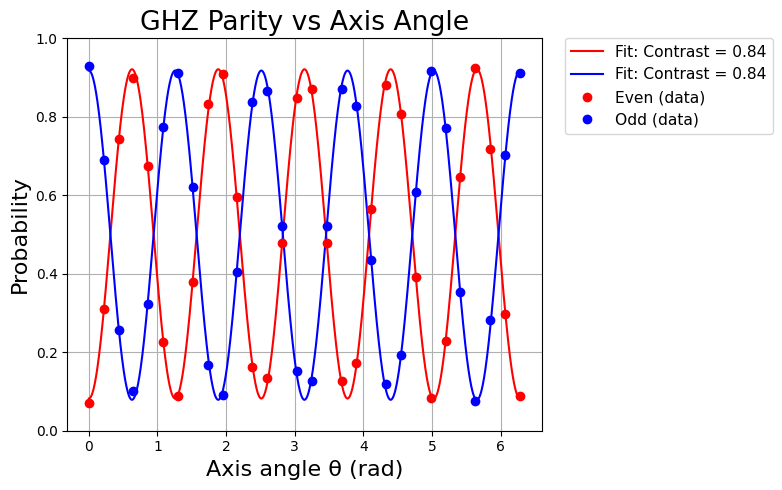

Extracted contrast: 0.839


In [182]:
num_qubits = 5

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=1024, num_points=num_qubits*6)

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")

## GHZ state of 10 qubits? Will take a minute to simulate...

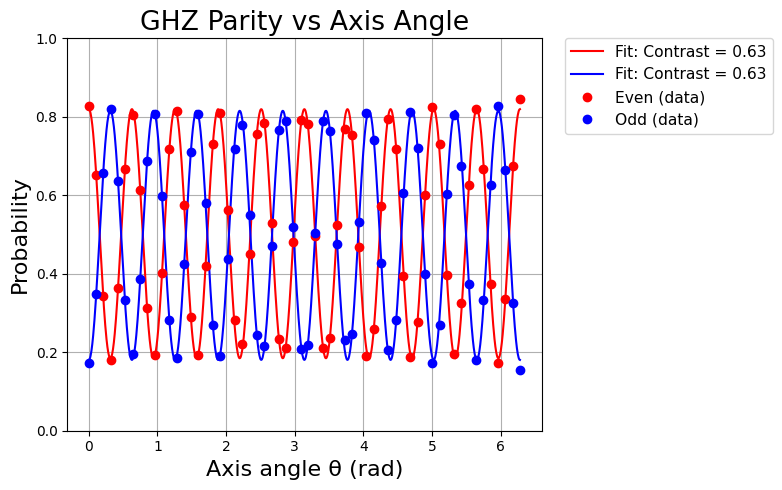

Extracted contrast: 0.635


In [183]:
num_qubits = 10

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=1024, num_points=num_qubits*6)

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")


## Parity oscillations of 15 qubit GHZ state? 

It would take a long time to simulate all of the angles of rotation...and see all of the oscillations...

Let's only scan over two fringes of the parity oscillation (a much smaller total angle) instead to save time.

In [330]:
def run_parity_oscillations(num_qubits=3, num_shots=1024, num_points=30, phi_max=2*np.pi):
    """
    Sweep over phi values from 0 to phi_max and measure parity using FakeBrisbane.

    Args:
        num_qubits (int): Number of qubits in the GHZ state.
        num_shots (int): Number of measurement shots per circuit.
        num_points (int): Number of phi values to sweep.
        phi_max (float): Final value of phi in the sweep (default: 2π).

    Returns:
        tuple: (phi_vals, p_even_vals, p_odd_vals)
    """
    backend = FakeBrisbane()
    phi_vals = np.linspace(0, phi_max, num_points)
    p_even_vals = []
    p_odd_vals = []

    for phi in phi_vals:
        qc = create_ghz_circuit(num_qubits, phi)
        tqc = transpile(qc, backend)
        job = backend.run(tqc, shots=num_shots)
        result = job.result()
        counts = result.get_counts()
        p_even, p_odd = parity_probabilities(counts)
        p_even_vals.append(p_even)
        p_odd_vals.append(p_odd)

    return phi_vals, p_even_vals, p_odd_vals


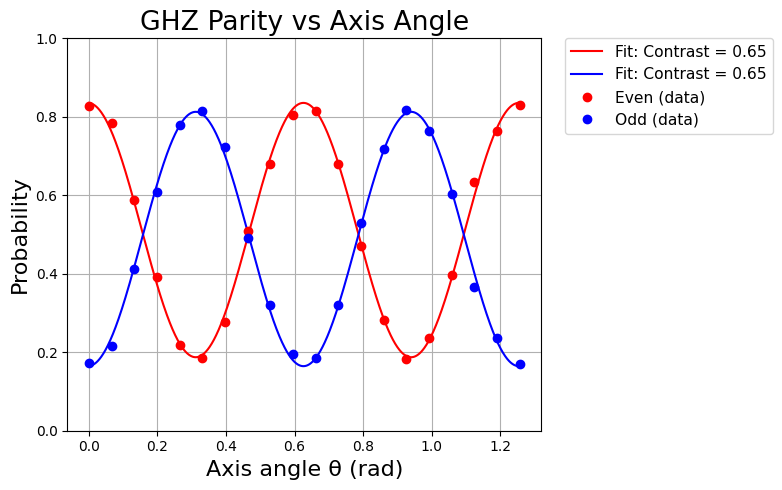

Extracted contrast: 0.648


In [49]:
num_qubits = 10

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=1024, num_points=20, phi_max=2*np.pi/(num_qubits/2))

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")

# 15 qubit GHZ state parity oscillations!

simulated in only a few minutes!

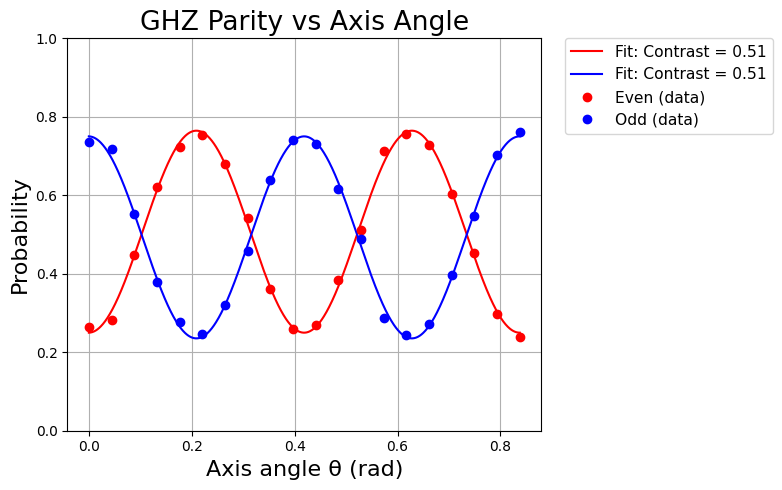

Extracted contrast: 0.515


In [196]:
num_qubits = 15

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=100, num_points=10, phi_max=2*np.pi/(num_qubits/2))

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")

This will take almost a few minutes to run:

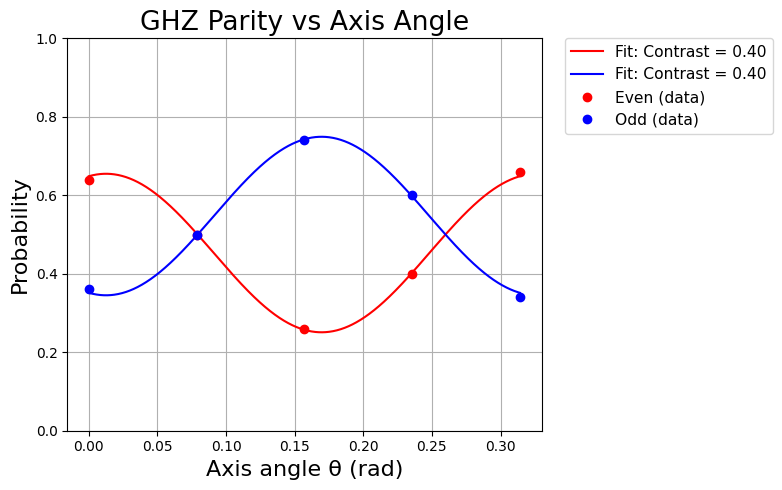

Extracted contrast: 0.404


In [ ]:
num_qubits = 20

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=100, num_points=7, phi_max=2*np.pi/(num_qubits))

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")

In [ ]:
# num_qubits = 25

# phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=100, num_points=7, phi_max=2*np.pi/(num_qubits))

# contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
# print(f"Extracted contrast: {contrast:.3f}")

# GHZ parity contrast decay vs. number of qubits

Compiling these contrasts together we can now extract the decay of the GHZ state fidelity vs. number of qubits

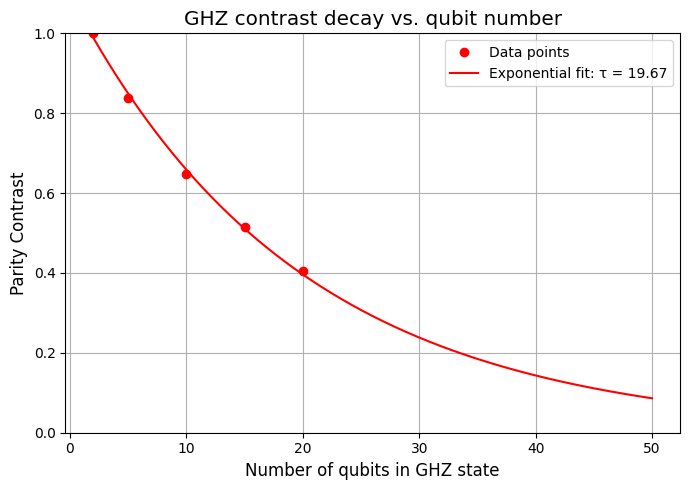

In [331]:
# Parity Contrast Data
x_vals = np.array([2, 5, 10, 15, 20])
y_vals = np.array([1.0, 0.839, 0.648, 0.515, 0.404])

def decay_model(x, A, tau):
    return A * np.exp(-x / tau)

p0_exp = [1.0, 5.0]

popt_exp, _ = curve_fit(decay_model, x_vals, y_vals, p0=p0_exp)

A_fit, tau_fit = popt_exp

x_smooth = np.linspace(2, 50, 500)
y_exp = decay_model(x_smooth, A_fit, tau_fit)

fs = 12
plt.figure(figsize=(7, 5))
plt.plot(x_vals, y_vals, 'or', label='Data points')
plt.plot(x_smooth, y_exp, '-r', label=f'Exponential fit: τ = {tau_fit:.2f}')
plt.xlabel('Number of qubits in GHZ state', fontsize=fs)
plt.ylabel('Parity Contrast', fontsize=fs)
plt.title('GHZ contrast decay vs. qubit number', fontsize=fs * 1.2)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Superdecoherence and decoherence 'free' sub-spaces


>https://arxiv.org/abs/2312.15170 - Characterization of entanglement on superconducting quantum computers of up to 414 qubits
>https://arxiv.org/abs/1807.05572 - Efficient quantum algorithms for GHZ and W states, and implementation on the IBM quantum computer




In [35]:
def create_ghz_sym_circuit(num_qubits, phi=0):
    """Creates a circuit that prepares a 010101... state and applies a controlled rotation
    Args:
        num_qubits (int): Number of qubits in the circuit
        phi (float): Angle of rotation around Z-axis
    Returns:
        QuantumCircuit: Circuit that creates the state
    """
    qc = QuantumCircuit(num_qubits)
    
    qc.h(0)

    # Create 010101... state
    for i in range(1, num_qubits, 2):
        qc.x(i)

    # Apply controlled rotations
    for i in range(num_qubits-1):
        qc.cx(i, i+1)

    qc.barrier()

    '''Global rotation to generate parity oscillations'''
    for i in range(num_qubits):
        qc.u(pi/2 ,phi,-phi,i)

    qc.barrier()


    # Add measurements
    qc.measure_all()
    
    return qc


Transpiled circuit for 2 qubits:


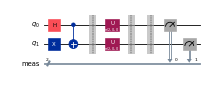


Transpiled circuit for 3 qubits:


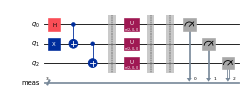


Transpiled circuit for 4 qubits:


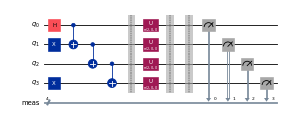


Transpiled circuit for 5 qubits:


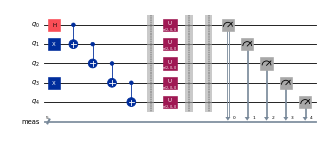


Transpiled circuit for 6 qubits:


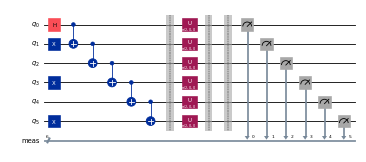

In [36]:
num_qubits =6
for n in range(2, num_qubits + 1):
    qc = create_ghz_sym_circuit(n, phi=0)
    tqc = transpile(qc, backend)
    print(f"\nTranspiled circuit for {n} qubits:")
    display(qc.draw('mpl',scale=0.3, idle_wires=False,fold=50))


Transpiled circuit for 6 qubits:


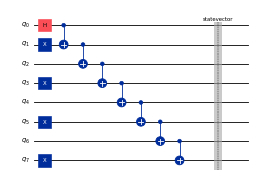

In [39]:
from qiskit_aer import AerSimulator

num_qubits=8

qc = QuantumCircuit(num_qubits)

qc.h(0)
# Create 010101... state
for i in range(1, num_qubits, 2):
    qc.x(i)
# Apply controlled rotations
for i in range(num_qubits-1):
    qc.cx(i, i+1)


qc.save_statevector() #just simulate the statevector

simulator = AerSimulator()
qc_transpiled = transpile(qc, simulator)

print(f"\nTranspiled circuit for {n} qubits:")
display(qc_transpiled.draw('mpl',scale=0.3, idle_wires=False,fold=50))

job = simulator.run(qc_transpiled, shots=1000)

{np.str_('01100110'): np.float64(0.5), np.str_('10011001'): np.float64(0.5)}


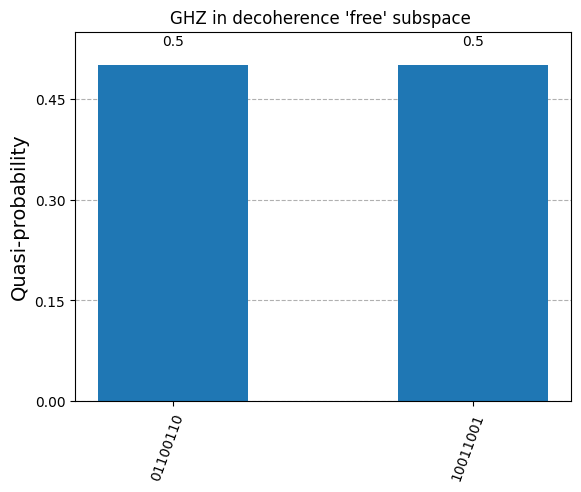

In [40]:
'''Plot results'''
counts = job.result().get_counts()
print(counts)
plot_histogram(counts , title="GHZ in decoherence 'free' subspace ")

In [41]:
def run_parity_osc_DFS(num_qubits=3, num_shots=1024, num_points=30, phi_max=2*np.pi):
    """
    Generate GHZ in decoherence free subspace and measure parity oscillations
    """
    # Initialize the backend simulator
    backend = FakeBrisbane()
    
    # Create array of phi values to sweep through
    phi_vals = np.linspace(0, phi_max, num_points)
    
    # Initialize lists to store parity measurement results
    p_even_vals = []
    p_odd_vals = []

    # Loop through each phi value
    for phi in phi_vals:
        # Create and transpile the GHZ circuit with current phi
        qc = create_ghz_sym_circuit(num_qubits, phi)
        tqc = transpile(qc, backend)
        
        # Run the circuit and get results
        job = backend.run(tqc, shots=num_shots)
        result = job.result()
        counts = result.get_counts()
        
        # Calculate parity probabilities and store results
        p_even, p_odd = parity_probabilities(counts)
        p_even_vals.append(p_even)
        p_odd_vals.append(p_odd)

    # Return arrays of phi values and corresponding parity probabilities
    return phi_vals, p_even_vals, p_odd_vals


In [24]:
def _cosn_model(theta, A, theta0, B, n):
    """Cosine model with n oscillations."""
    return A * np.cos(n * theta + theta0) + B

def plot_parity_vs_theta_with_fit_n(theta_vals, p_even_vals, p_odd_vals, n_qubits, fs=14, title="GHZ Parity vs Axis Angle"):
    """
    Plots parity vs axis angle theta, fits even parity to extract contrast for n-qubit GHZ.
    Returns: float: Extracted contrast.
    """
    theta_vals = np.array(theta_vals)
    p_even_vals = np.array(p_even_vals)

    # Fit to model: A * cos(n * θ + θ₀) + B
    def fit_func(theta, A, theta0, B, n):
        return _cosn_model(theta, A, theta0, B, n)

    p0 = [0.5, 0, 0.5, 1]  # Initial guess: amplitude, phase offset, baseline, frequency
    popt, _ = curve_fit(fit_func, theta_vals, p_even_vals, p0=p0)
    A_fit, theta0_fit, B_fit, n_fit = popt
    contrast = 2 * abs(A_fit)

    # Smooth curve for fit
    theta_smooth = np.linspace(min(theta_vals), max(theta_vals), 1000)
    fit_smooth = fit_func(theta_smooth, *popt)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(theta_smooth, fit_smooth, '-r', label=f'Fit: Contrast = {contrast:.2f}')
    plt.plot(theta_smooth, 1-fit_smooth, '-b', label=f'Fit: Contrast = {contrast:.2f}')
    plt.plot(theta_vals, p_even_vals, 'or', label='Even (data)')
    plt.plot(theta_vals, p_odd_vals, 'ob', label='Odd (data)')
    plt.xlabel('Axis angle θ (rad)', fontsize=fs)
    plt.ylabel('Probability', fontsize=fs)
    plt.title(title, fontsize=fs * 1.2)
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=fs * 0.7)
    plt.tight_layout()
    plt.show()

    return contrast


In [ ]:
num_qubits = 15
phi_vals, p_even_vals, p_odd_vals = run_parity_osc_DFS(num_qubits=num_qubits, num_shots=1024, num_points=10, phi_max=2*np.pi)


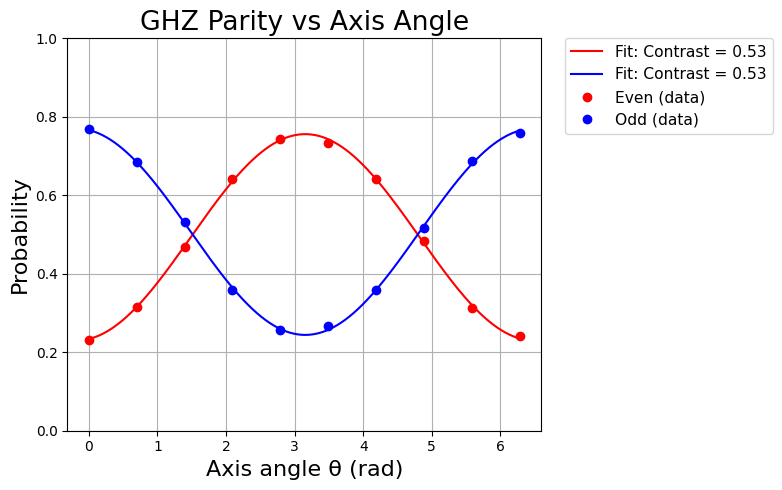

Extracted contrast: 0.526


In [57]:
contrast = plot_parity_vs_theta_with_fit_n(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")

Same as before! This suggests that there is not much correlated phase noise within the IBM quantum processor.. at least in the simulation...

In [41]:
# Access error rates for first 20 qubits
error_rates = {}
for i in range(20):
    for j in range(i+1, 20):
        try:
            error = backend.properties().gate_error('ecr', [i,j])
            error_rates[(i,j)] = error
        except:
            error_rates[(i,j)] = None

# Print error rates
print("ECR gate error rates between qubit pairs:")
for pair, error in error_rates.items():
    if error is not None:
        print(f"Qubits {pair}: {error:.3e}")



ECR gate error rates between qubit pairs:
Qubits (4, 5): 4.840e-03
Qubits (4, 15): 5.498e-03
Qubits (6, 7): 7.718e-03
Qubits (7, 8): 1.113e-02
Qubits (8, 9): 6.736e-03
Qubits (10, 11): 1.004e-02
Qubits (11, 12): 6.111e-03
Qubits (12, 17): 5.352e-03
Qubits (14, 18): 1.014e-02
Qubits (18, 19): 6.709e-03


In [42]:
(1-1.167e-02)**15

0.8385513715533337

In [43]:
# Access instruction durations
inst_durations = backend.target.durations()

# Get duration for a specific gate and qubits
cx_duration = inst_durations.get('ecr', (1,0))  
dt = backend.configuration().dt  # Time per 'dt' unit
cx_time_sec = cx_duration * dt
cx_time_ns = cx_time_sec * 1e9

print(f"CX duration on qubits (0): {cx_time_ns:.1f} ns")


CX duration on qubits (0): 660.0 ns


In [44]:
0.6e-6*15

9e-06

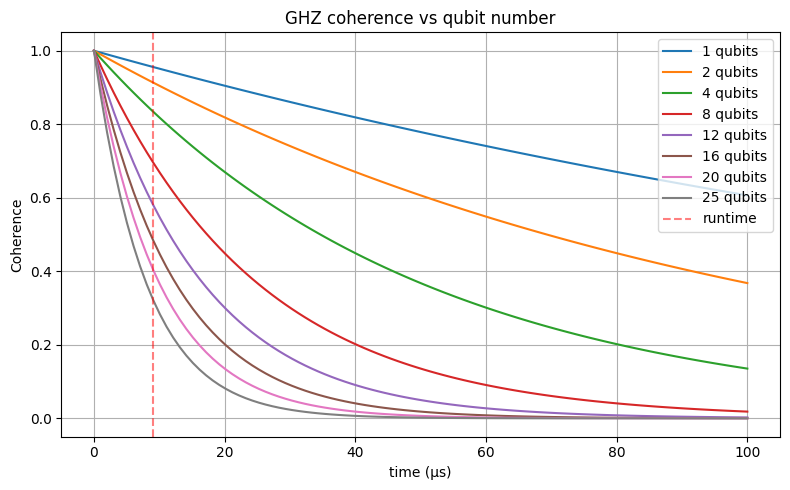

In [49]:
# Create array of T2 times
times = np.linspace(0, 100, 100)  # microseconds

# Calculate success probability vs T2 time for different numbers of qubits
# Assuming 15 gates with 0.6us duration each
gate_time = 0.6  # microseconds per gate
num_gates = 15

runtime = gate_time*num_gates

t2_time=200

# Calculate for different numbers of qubits
qubit_numbers = [1, 2, 4, 8, 12, 16, 20, 25]

plt.figure(figsize=(8,5))

for n in qubit_numbers:
    success_prob = np.exp(-times/(t2_time/(n)))
    plt.plot(times, success_prob, label=f'{n} qubits')

plt.xlabel('time (μs)')
plt.ylabel('Coherence') 
plt.title('GHZ coherence vs qubit number')
plt.grid(True)

# Add vertical line at T2=100μs for reference
plt.axvline(x=runtime, color='r', linestyle='--', alpha=0.5, label='runtime')
plt.legend()
plt.tight_layout()


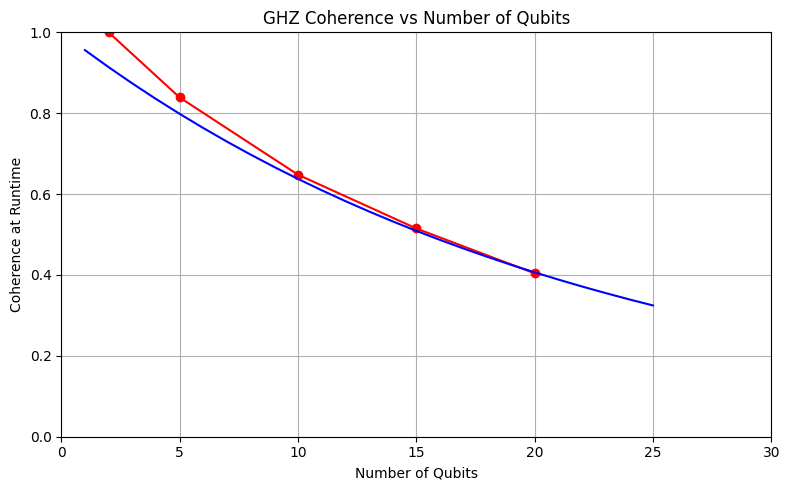

In [51]:
# Parity Contrast Data
x_vals = np.array([2, 5, 10, 15, 20])
y_vals = np.array([1.0, 0.839, 0.648, 0.515, 0.404])

plt.figure(figsize=(8,5))
plt.plot(x_vals, y_vals, 'o-r', label='Experimental Data')

# Create array of n values
n_values = np.arange(1, 26)
# Calculate success probability for each n at runtime
success_probs = np.exp(-runtime/(t2_time/(n_values)))

plt.plot(n_values, success_probs, '-b')

plt.xlabel('Number of Qubits')
plt.ylabel('Coherence at Runtime')
plt.title('GHZ Coherence vs Number of Qubits')
plt.grid(True)
plt.ylim(0, 1)
plt.xlim(0, 30)
plt.tight_layout()

In [82]:
t1s = [t1_estimates[t][1] for t in t1_estimates]
1e-6*np.array(t1s)/cx_time_sec

array([326.79315951, 413.11472361, 394.01975453, 179.62798306,
       288.4937984 , 389.20016644, 375.67018186, 197.83553409,
       342.46789854, 267.93502873])

# Branching circuit for faster GHZ state generation

We should be able to 'branch' the entanglement from the superposition of the first qubit.

We can do this with a doubling ripple circuit.

This lowers the depth from 𝒪(n) to log(n)

In [6]:
def ghz_doubling_ripple(num_qubits, phi):
    """
    Efficient GHZ circuit using a doubling ripple pattern:
    each layer uses the entangled qubits to entangle the next layer.

    Args:
        num_qubits (int): Total number of qubits in the GHZ state.
        phi (float): Phase rotation angle applied to each qubit.

    Returns:
        QuantumCircuit: The GHZ state circuit with parity oscillation phase.
    """
    qc = QuantumCircuit(num_qubits, num_qubits)

    # Step 1: Put qubit 0 into superposition
    qc.h(0)

    # Step 2: Doubling ripple entanglement
    entangled = [0]  # start with only qubit 0 entangled
    remaining = list(range(1, num_qubits))
    while remaining:
        new_entangled = []
        for ctrl, tgt in zip(entangled, remaining):
            qc.cx(ctrl, tgt)
            new_entangled.append(tgt)
        entangled += new_entangled
        remaining = remaining[len(new_entangled):]  # remove newly entangled targets

    qc.barrier()

    # Step 3: Apply parity oscillation rotation
    for i in range(num_qubits):
        qc.u(pi/2, phi, -phi, i)

    qc.barrier()

    # Step 4: Measure all qubits
    qc.measure(range(num_qubits), range(num_qubits))

    return qc


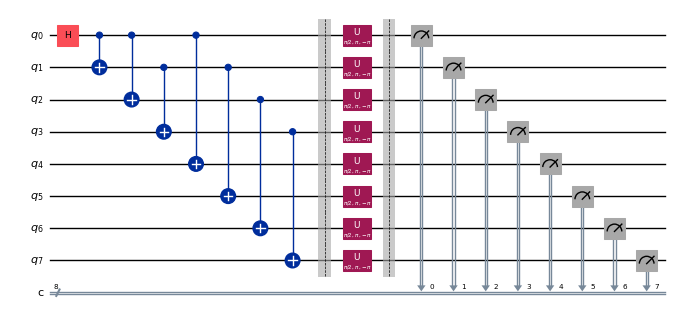

In [21]:
qc = ghz_doubling_ripple(8, pi)
qc.draw('mpl',fold=70,scale=0.5)

In [8]:
# for optimization_level in [0,1,2,3]:
#     # Using pass manager
#     pm = generate_preset_pass_manager(optimization_level, backend=backend, seed_transpiler=0)
#     t_qc_pm = pm.run(qc)
#     gate_counts_pm = t_qc_pm.count_ops()
#     print(f"Gate counts with pass manager (optimization_level={optimization_level}):")
#     for gate, count in gate_counts_pm.items():
#         print(f"  {gate}: {count}")


# # Using transpile
# t_qc_tr = transpile(qc, backend)
# gate_counts_tr = t_qc_tr.count_ops()
# print(f"\nGate counts with transpile):")
# for gate, count in gate_counts_tr.items():
#     print(f"  {gate}: {count}")


In [16]:
def run_parity_osc_branch(num_qubits=3, num_shots=1024, num_points=30, phi_max=2*np.pi):
    """    Generate GHZ with branch circuit and measure parity oscillations    """
    backend = FakeBrisbane()
    phi_vals = np.linspace(0, phi_max, num_points)
    p_even_vals = []
    p_odd_vals = []
    for phi in phi_vals:
        qc = ghz_doubling_ripple(num_qubits, phi)
        pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=0)
        tqc = pm.run(qc)
        # tqc = transpile(qc, backend)
        
        job = backend.run(tqc, shots=num_shots)
        result = job.result()
        counts = result.get_counts()
        
        p_even, p_odd = parity_probabilities(counts)
        p_even_vals.append(p_even)
        p_odd_vals.append(p_odd)
    return phi_vals, p_even_vals, p_odd_vals

In [22]:
num_qubits = 8
phi_vals, p_even_vals, p_odd_vals = run_parity_osc_branch(num_qubits=num_qubits, num_shots=1024, num_points=5, phi_max=2*np.pi/num_qubits)

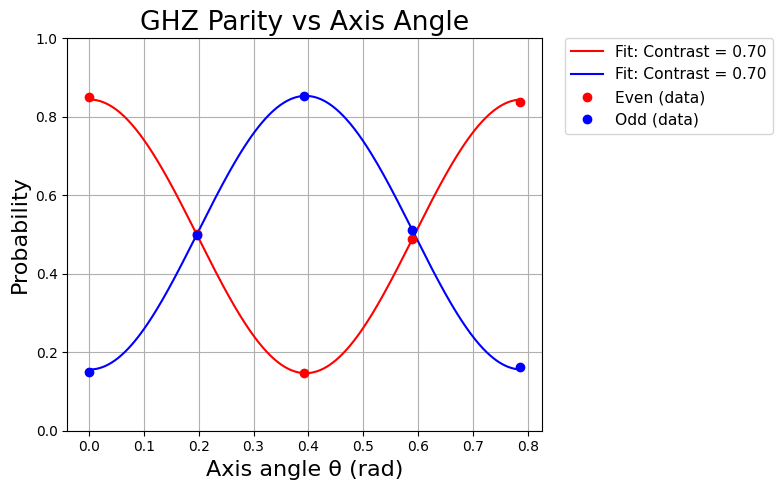

Extracted contrast: 0.697


In [25]:
contrast = plot_parity_vs_theta_with_fit_n(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")

Same same... 

## Maybe the topology of the circuit layout must be considered as well?

Original coupling map:
[[1, 0], [2, 1], [3, 2], [4, 3], [4, 5], [4, 15], [6, 5], [6, 7], [7, 8], [8, 9], [10, 9], [10, 11], [11, 12], [12, 17], [13, 12], [14, 0], [14, 18], [15, 22], [16, 8], [16, 26], [17, 30], [18, 19], [20, 19], [20, 33], [21, 20], [21, 22], [22, 23], [24, 23], [24, 34], [25, 24], [26, 25], [27, 26], [28, 27], [28, 29], [28, 35], [30, 29], [30, 31], [31, 32], [32, 36], [33, 39], [34, 43], [35, 47], [36, 51], [37, 38], [39, 38], [40, 39], [40, 41], [41, 53], [42, 41], [42, 43], [43, 44], [44, 45], [46, 45], [46, 47], [48, 47], [48, 49], [50, 49], [50, 51], [52, 37], [52, 56], [53, 60], [54, 45], [54, 64], [55, 49], [55, 68], [56, 57], [57, 58], [58, 59], [58, 71], [59, 60], [60, 61], [62, 61], [62, 63], [62, 72], [63, 64], [65, 64], [65, 66], [67, 66], [67, 68], [69, 68], [69, 70], [73, 66], [74, 70], [74, 89], [75, 90], [76, 75], [77, 71], [77, 76], [77, 78], [79, 78], [79, 80], [80, 81], [81, 72], [81, 82], [82, 83], [83, 92], [84, 83], [85, 73], [85, 84], [85, 86]

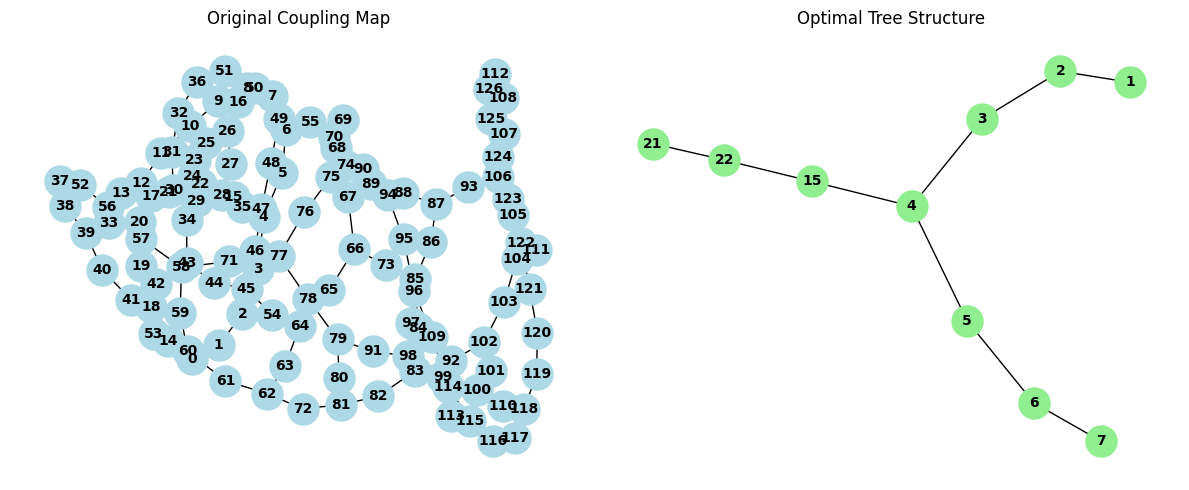

In [27]:
# Get the coupling map of the fake Brisbane device and find optimal tree
backend = FakeBrisbane()
coupling_map = backend.configuration().coupling_map

# Convert coupling map to adjacency list format
adj_list = {}
for edge in coupling_map:
    if edge[0] not in adj_list:
        adj_list[edge[0]] = []
    if edge[1] not in adj_list:
        adj_list[edge[1]] = []
    adj_list[edge[0]].append(edge[1])
    adj_list[edge[1]].append(edge[0])

# Do BFS to find tree with minimum depth
def find_min_depth_tree(start, target_size=10):
    visited = set()
    tree = {start: []}
    queue = [(start, 0)]
    visited.add(start)
    
    while queue and len(tree) < target_size:
        node, depth = queue.pop(0)
        for neighbor in adj_list[node]:
            if neighbor not in visited:
                visited.add(neighbor)
                tree[neighbor] = []
                tree[node].append(neighbor)
                queue.append((neighbor, depth + 1))
                if len(tree) == target_size:
                    break
                    
    return tree, depth

# Try each node as root and find one with minimum depth
min_depth = float('inf')
best_tree = None
for start in range(len(adj_list)):
    tree, depth = find_min_depth_tree(start)
    if depth < min_depth:
        min_depth = depth
        best_tree = tree

print("Original coupling map:")
print(coupling_map)
print("\nOptimal 10-node tree structure (parent: children):")
for node in best_tree:
    print(f"{node}: {best_tree[node]}")
print(f"\nTree depth: {min_depth}")

# Plot the graph
import networkx as nx
import matplotlib.pyplot as plt

# Create graph from coupling map
G = nx.Graph()
G.add_edges_from(coupling_map)

# Create graph from optimal tree
T = nx.Graph()
for parent, children in best_tree.items():
    for child in children:
        T.add_edge(parent, child)

# Plot both graphs side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot coupling map
pos1 = nx.spring_layout(G)
nx.draw(G, pos1, ax=ax1, with_labels=True, node_color='lightblue', 
        node_size=500, font_size=10, font_weight='bold')
ax1.set_title('Original Coupling Map')

# Plot optimal tree
pos2 = nx.spring_layout(T)
nx.draw(T, pos2, ax=ax2, with_labels=True, node_color='lightgreen',
        node_size=500, font_size=10, font_weight='bold')
ax2.set_title('Optimal Tree Structure')

plt.tight_layout()
plt.show()


[1, 2, 3, 4, 5, 6, 7, 15, 21, 22]


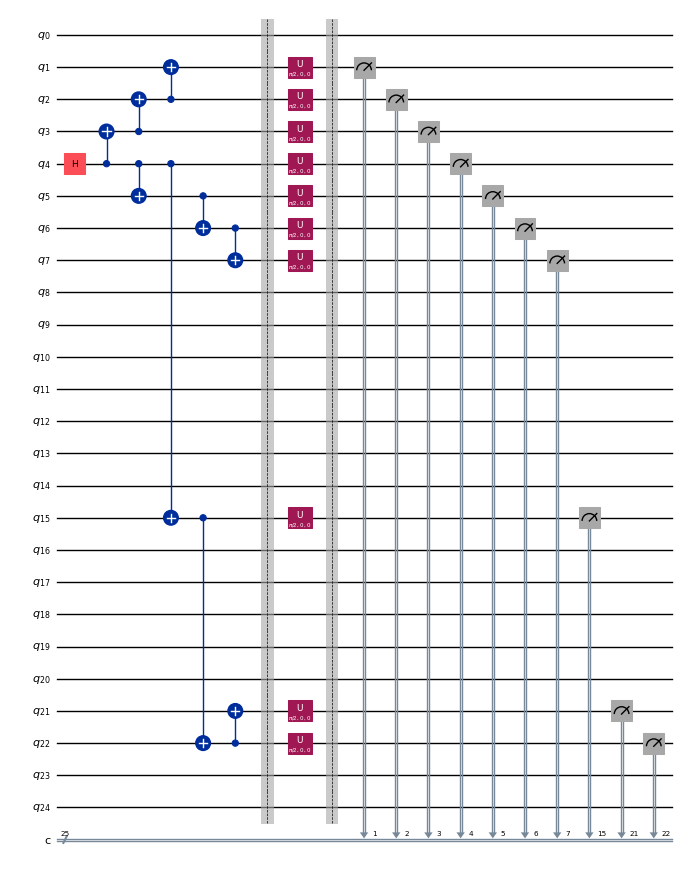

In [28]:
phi=0
# Create a quantum circuit based on the optimal tree structure
qc = QuantumCircuit(25,25)

qc.h(4)
# Add gates based on the tree connections
for parent, children in best_tree.items():
    for child in children:
        # Add CNOT gates between connected nodes
        qc.cx(parent, child)

qc.barrier()

# Step 3: Apply parity oscillation rotation
for parent, children in best_tree.items():
    qc.u(pi/2, phi, -phi, parent)

qc.barrier()


# Create array of all qubits in the tree
tree_qubits = []
for parent, children in best_tree.items():
    if parent not in tree_qubits:
        tree_qubits.append(parent)
    for child in children:
        if child not in tree_qubits:
            tree_qubits.append(child)
tree_qubits = sorted(tree_qubits)
print(tree_qubits)


# Step 4: Measure all qubits
qc.measure(tree_qubits, tree_qubits)

# qc.draw()
# Draw the circuit
qc.draw('mpl', fold=50,scale=0.5)
# plt.show()



In [29]:
def create_tree_circuit(phi, n_qubits):
    # Create a quantum circuit based on the optimal tree structure
    qc = QuantumCircuit(n_qubits, n_qubits)

    qc.h(4)
    # Add gates based on the tree connections
    for parent, children in best_tree.items():
        for child in children:
            # Add CNOT gates between connected nodes
            qc.cx(parent, child)

    qc.barrier()

    # Step 3: Apply parity oscillation rotation
    for parent, children in best_tree.items():
        qc.u(pi/2, phi, -phi, parent)

    qc.barrier()

    # Create array of all qubits in the tree
    tree_qubits = []
    for parent, children in best_tree.items():
        if parent not in tree_qubits:
            tree_qubits.append(parent)
        for child in children:
            if child not in tree_qubits:
                tree_qubits.append(child)
    tree_qubits = sorted(tree_qubits)

    # Step 4: Measure all qubits
    qc.measure(tree_qubits, tree_qubits)
    
    return qc

# qc.draw()
# Draw the circuit
# qc.draw('mpl', fold=50,scale=0.5)
# plt.show()



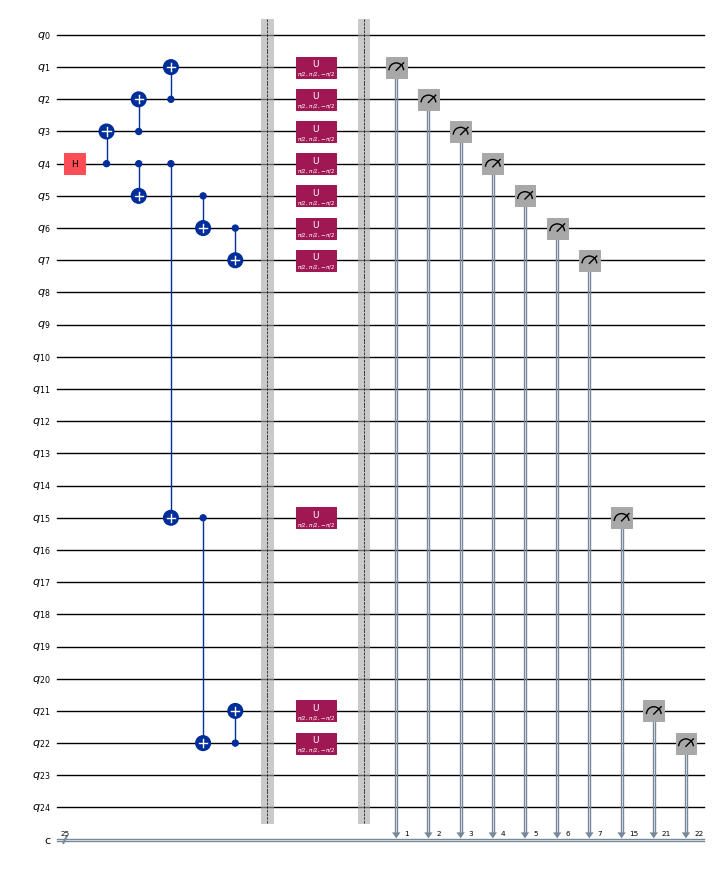

In [35]:
qc = create_tree_circuit(pi/2,25)
qc.draw('mpl', fold=50,scale=0.5)

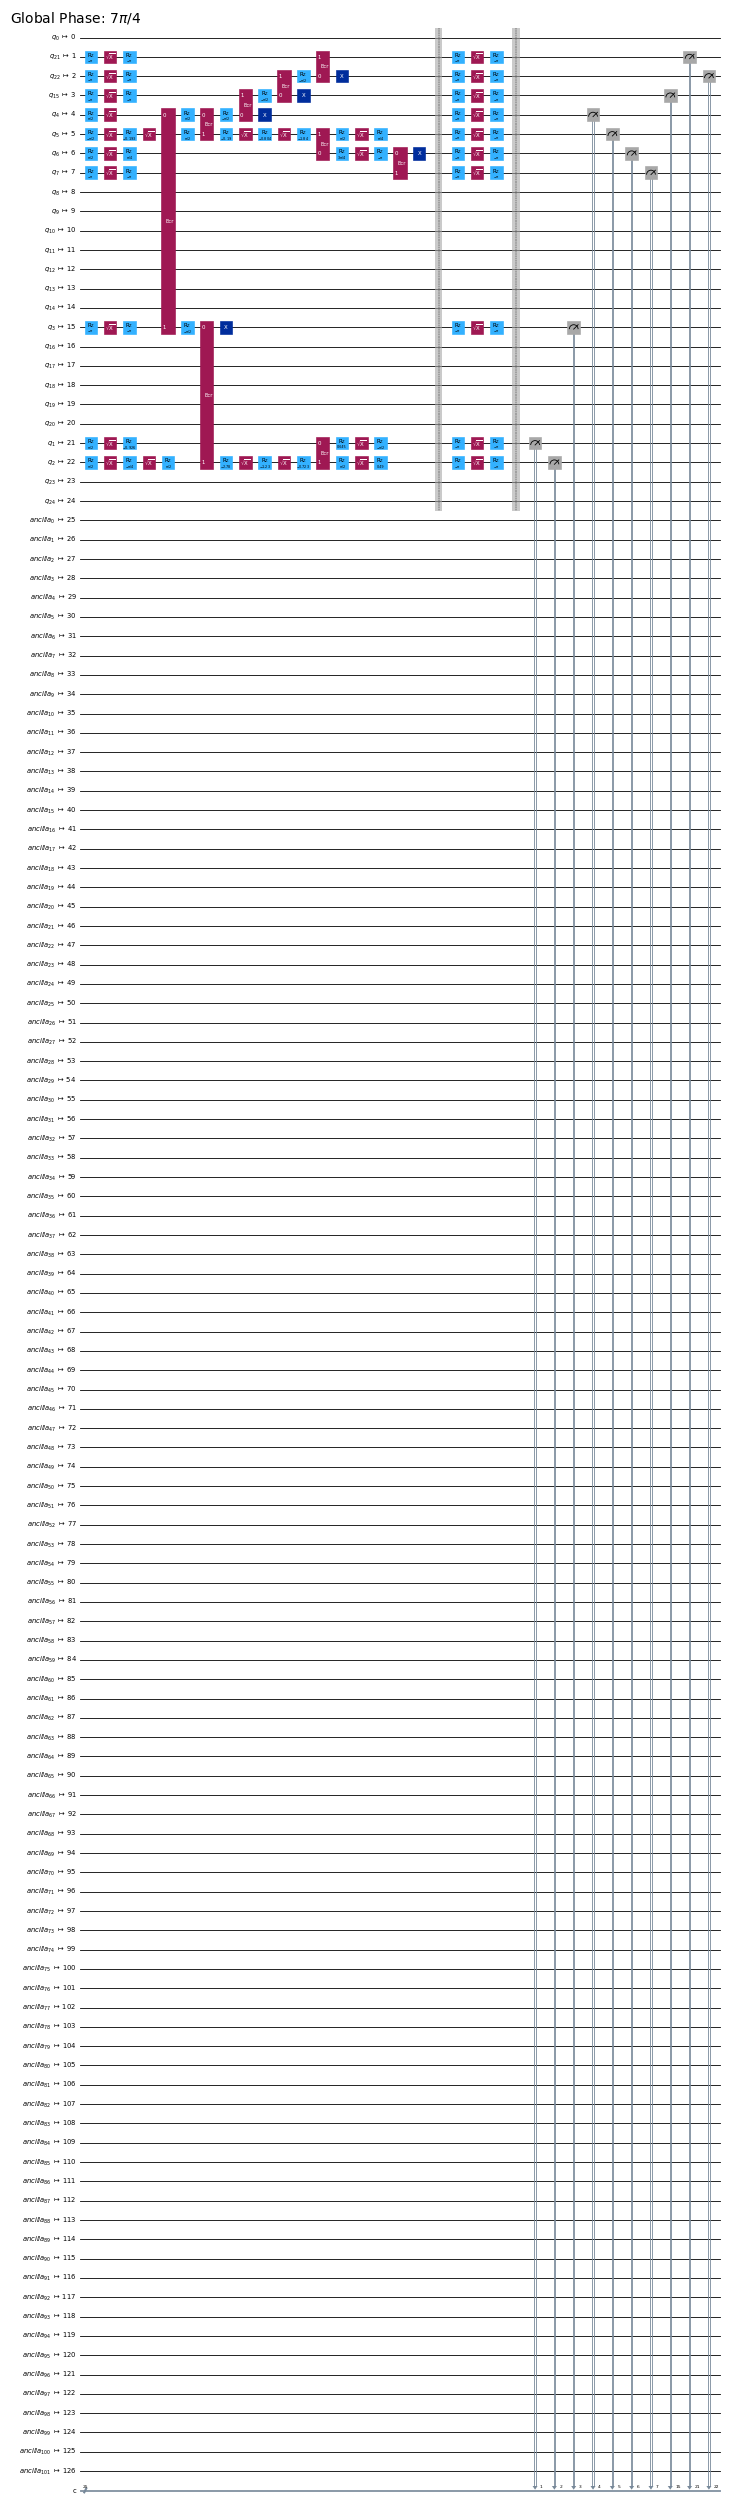

In [37]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=0)
tqc = pm.run(qc)
tqc.draw('mpl',scale=0.3,fold=70)

In [ ]:

backend = FakeBrisbane()
phi_max = pi
num_points = 10
num_shots=100
phi_vals = np.linspace(0, phi_max, num_points)
p_even_vals = []
p_odd_vals = []
for phi in phi_vals:
    qc = create_tree_circuit(pi,25)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=0)
    tqc = pm.run(qc)
    # tqc = transpile(qc, backend)
    
    job = backend.run(tqc, shots=num_shots)
    result = job.result()
    counts = result.get_counts()
    
    p_even, p_odd = parity_probabilities(counts)
    p_even_vals.append(p_even)
    p_odd_vals.append(p_odd)


SyntaxError: 'return' outside function (2064532686.py, line 21)

In [38]:
def run_parity_osc_tree(num_qubits=3, num_shots=1024, num_points=30, phi_max=2*np.pi):
    """    Generate GHZ with branch circuit and measure parity oscillations    """
    backend = FakeBrisbane()
    phi_vals = np.linspace(0, phi_max, num_points)
    p_even_vals = []
    p_odd_vals = []
    for phi in phi_vals:
        qc = create_tree_circuit(phi,25)
        pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=0)
        tqc = pm.run(qc)
        # tqc = transpile(qc, backend)
        
        job = backend.run(tqc, shots=num_shots)
        result = job.result()
        counts = result.get_counts()
        
        p_even, p_odd = parity_probabilities(counts)
        p_even_vals.append(p_even)
        p_odd_vals.append(p_odd)
    return phi_vals, p_even_vals, p_odd_vals

In [39]:
num_qubits = 10
phi_vals, p_even_vals, p_odd_vals = run_parity_osc_branch(num_qubits=num_qubits, num_shots=1024, num_points=5, phi_max=2*np.pi/num_qubits)

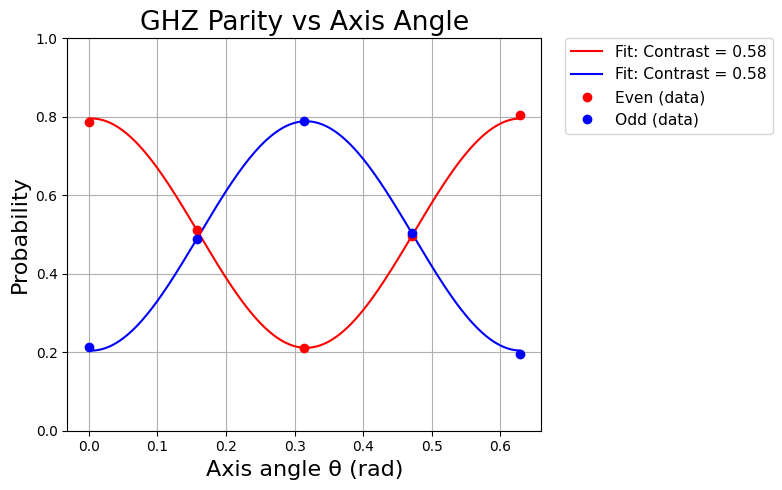

Extracted contrast: 0.584


In [40]:
contrast = plot_parity_vs_theta_with_fit_n(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")

All the same!

Let's move on.

# Quantum Volume

In [153]:
from qiskit.circuit.library import QuantumVolume

def create_quantum_volume_circuit(num_qubits, depth):
    qc = QuantumCircuit(num_qubits, num_qubits)

    qv = QuantumVolume(num_qubits, depth)
    qc.compose(qv, inplace=True)

    qc.barrier()
    qc.measure(range(num_qubits), range(num_qubits))

    return qc

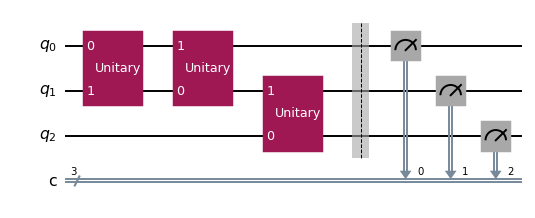

In [225]:
num_qubits=3
qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)

qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7)

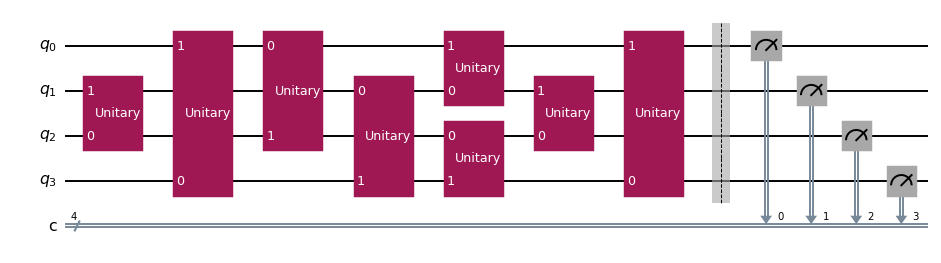

In [155]:
num_qubits=4
qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)

qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7)

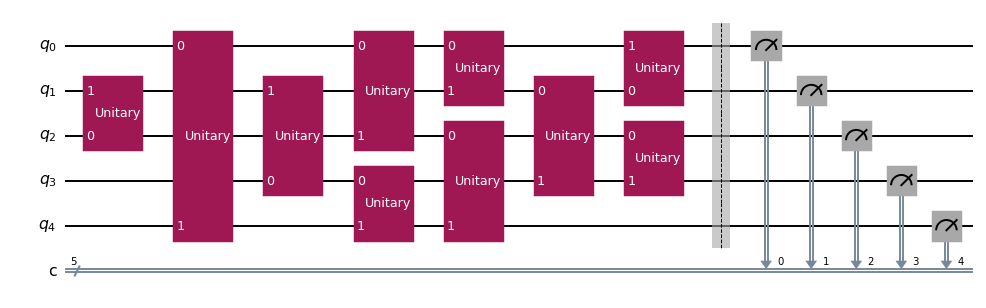

In [156]:
num_qubits=5
qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)

qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7)

# Simulate the QV on fake_brisbane

In [226]:
backend = FakeBrisbane()
backend.refresh(service)

{'000': 167, '110': 26, '010': 321, '001': 165, '101': 120, '100': 116, '011': 20, '111': 65}


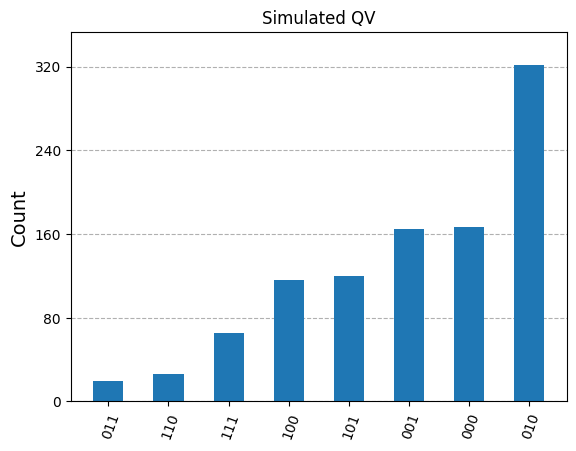

In [227]:
transpiled_circuit = transpile(qv_circuit, backend)

job = backend.run(transpiled_circuit, shots=1000)
result = job.result()

counts = result.get_counts()
print(counts)
plot_histogram(counts,title='Simulated QV' , sort = 'value', bar_labels=False)

## Now we need the 'ideal' case without noise to compare to

In [228]:
from qiskit.quantum_info import Statevector

def get_ideal_qv_distribution(circuit):
    """
    Simulates the ideal output probability distribution of a QV circuit.
    """
    # Remove measurements for pure statevector simulation
    qc = circuit.remove_final_measurements(inplace=False)

    # Simulate the statevector
    state = Statevector.from_instruction(qc)

    # Get probabilities of measuring each computational basis state
    probs = state.probabilities_dict()

    # Sort keys for consistency
    sorted_probs = {k: probs[k] for k in sorted(probs.keys())}
    return sorted_probs


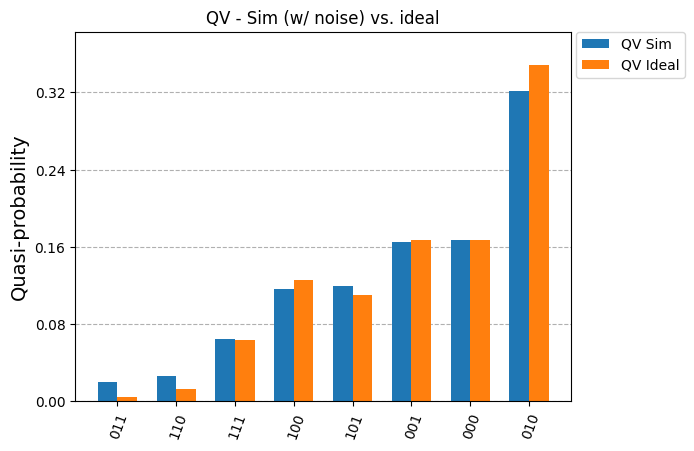

In [229]:
ideal_probs = get_ideal_qv_distribution(qv_circuit)

plot_histogram([counts, ideal_probs],title='QV - Sim (w/ noise) vs. ideal', legend=("QV Sim", "QV Ideal") , bar_labels=False, sort = 'value')


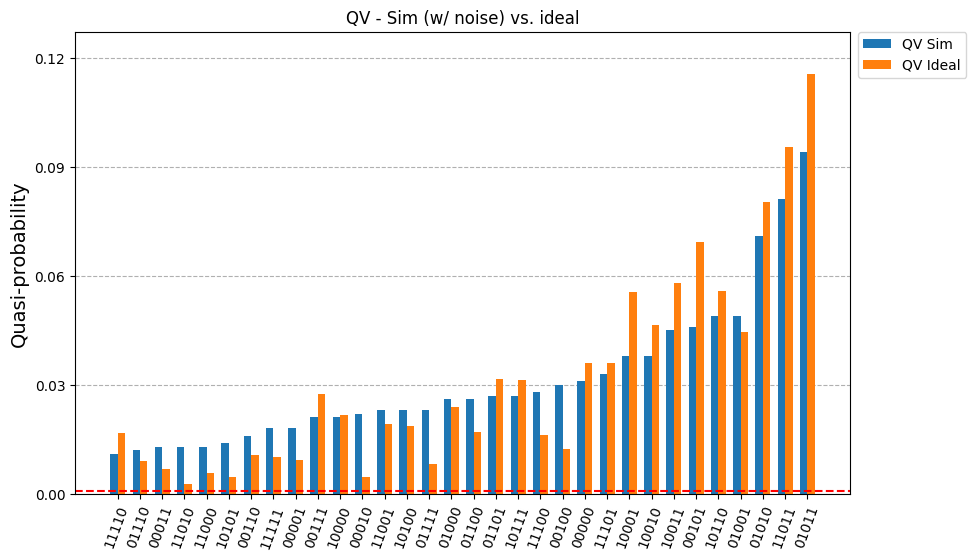

In [252]:
num_qubits=5

qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)
qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7)

shots = 1000
transpiled_circuit = transpile(qv_circuit, backend)
job = backend.run(transpiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()

ideal_probs = get_ideal_qv_distribution(qv_circuit)

# plot_histogram([counts, ideal_probs],title='QV - Sim (w/ noise) vs. ideal', legend=("QV Sim", "QV Ideal") , bar_labels=False, sort = 'value')

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111)
plot_histogram([counts, ideal_probs],
               ax=ax, 
               title='QV - Sim (w/ noise) vs. ideal',
               legend=("QV Sim", "QV Ideal"),
               bar_labels=False, sort='value')
# Add horizontal line for median
ax.axhline(y=median, color='r', linestyle='--', label='Median')

# Get sorted counts and add curve
sorted_counts = sorted(counts.values(), reverse=True)
x = range(len(sorted_counts))
ax.plot(x, sorted_counts, 'g-', linewidth=2, label='Sorted counts')

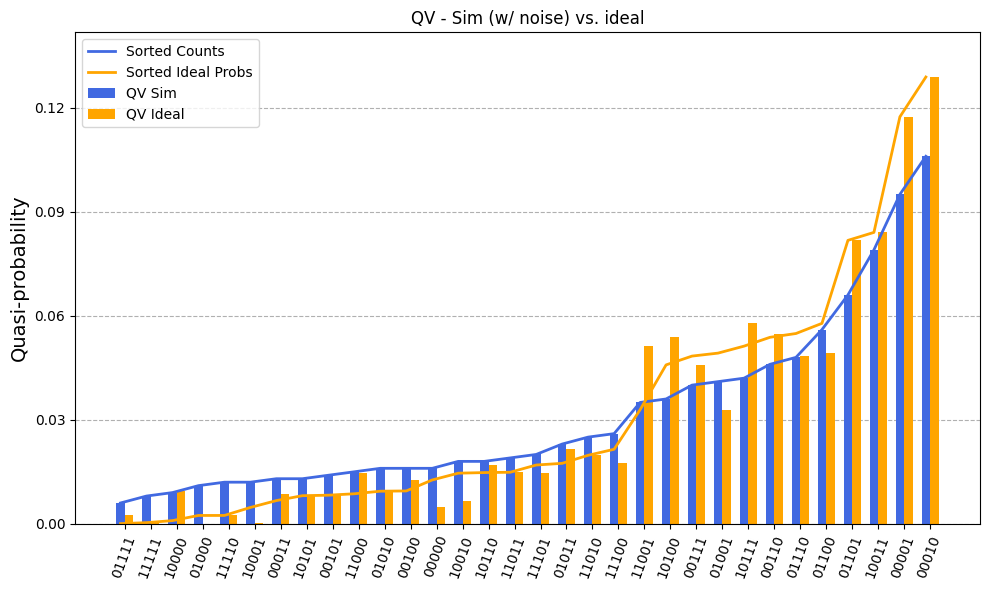

In [294]:
num_qubits=5

qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)
qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7)

shots = 1000
transpiled_circuit = transpile(qv_circuit, backend)
job = backend.run(transpiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()

ideal_probs = get_ideal_qv_distribution(qv_circuit)


# Extract and sort values
sim_probs = [v / shots for v in counts.values()]
sorted_counts_vals = sorted(sim_probs, reverse=False)
sorted_probs_vals = sorted(ideal_probs.values(), reverse=False)

x_counts = range(len(sorted_counts_vals))
x_probs = range(len(sorted_probs_vals))

# Create figure and plot histogram
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111)
plot_histogram([counts, ideal_probs],
               ax=ax, 
               title='QV - Sim (w/ noise) vs. ideal',
               legend=("QV Sim", "QV Ideal"),
               bar_labels=False, sort='value',
               color=['royalblue', 'orange'])
# Plot sorted distribution curves
ax.plot(x_counts, sorted_counts_vals, '-', color='royalblue', linewidth=2, label='Sorted Counts')
ax.plot(x_probs, sorted_probs_vals, '-', color='orange', linewidth=2, label='Sorted Ideal Probs')

ax.legend()
plt.tight_layout()
plt.show()


## Noise flattens the results

We can already see that the noisy simulation has less counts of the most likely ideal bit string and more counts of the least likely ideal bit strings...meaning that the noise is flattening the distribution

# Find the 'Heavy output' bit strings

## 1. Find median of ideal probabilities

In [295]:
probs = list(ideal_probs.values())
median = np.median(probs)
print('median of ideal probabilities = ',median)

median of ideal probabilities =  0.015906112892547945


## 2. Identify heavy output bitstrings

{np.str_('10110'), np.str_('01001'), np.str_('10111'), np.str_('00001'), np.str_('10100'), np.str_('11001'), np.str_('01100'), np.str_('01011'), np.str_('11010'), np.str_('10011'), np.str_('00110'), np.str_('11100'), np.str_('01101'), np.str_('00010'), np.str_('01110'), np.str_('00111')}


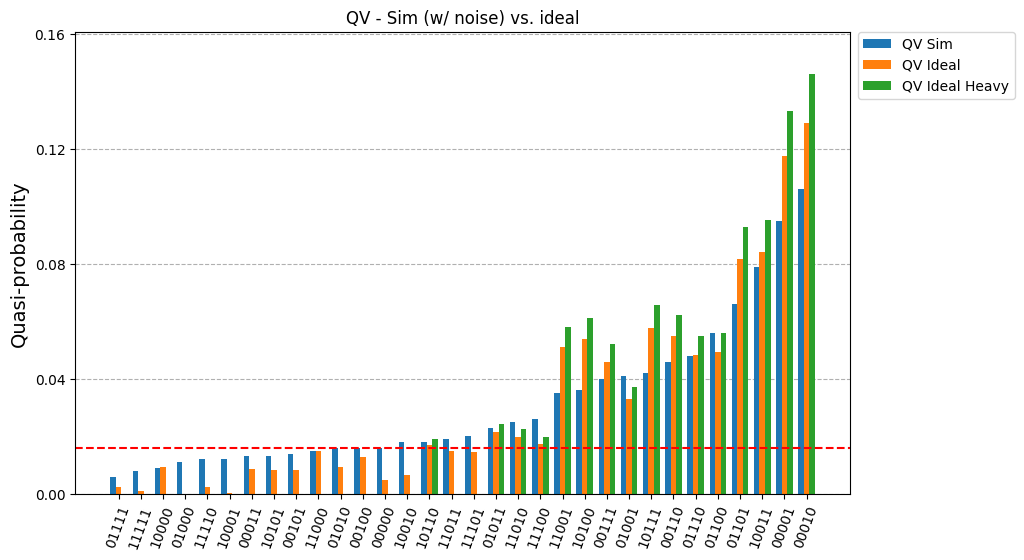

In [296]:
heavy_outputs = {bit for bit, prob in ideal_probs.items() if prob > median}
print(heavy_outputs)
heavy_ideal_probs = {bit: prob for bit, prob in ideal_probs.items() if prob > median}


fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111)
plot_histogram([counts, ideal_probs,heavy_ideal_probs],
               ax=ax, 
                title='QV - Sim (w/ noise) vs. ideal',
               legend=("QV Sim", "QV Ideal", "QV Ideal Heavy"),
               bar_labels=False, sort='value')
ax.axhline(y=median, color='r', linestyle='--', label='Median')


# # Create figure and plot histogram
# fig = plt.figure(figsize=[10, 6])
# ax = fig.add_subplot(111)
# plot_histogram([counts, ideal_probs,heavy_ideal_probs],
#                ax=ax, 
#                title='QV - Sim (w/ noise) vs. ideal',
#                legend=("QV Sim", "QV Ideal"),
#                bar_labels=False, sort='value',
#                color=['royalblue', 'orange'])
# # Plot sorted distribution curves
# ax.plot(x_counts, sorted_counts_vals, '-', color='royalblue', linewidth=2, label='Sorted Counts')
# ax.plot(x_probs, sorted_probs_vals, '-', color='orange', linewidth=2, label='Sorted Ideal Probs')
# ax.axhline(y=median, color='r', linestyle='--', label='Median')


## 3. Sum up counts of heavy outputs

In [298]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

heavy_probs = sum(ideal_probs.get(bit, 0) for bit in heavy_outputs);

print(f"Sum of ideal heavy output probabilities: {heavy_probs:.4f} ({heavy_probs*100:.1f}% of total probability)")

Sum of ideal heavy output probabilities: 0.8817 (88.2% of total probability)


In [299]:
def compute_heavy_output_prob(ideal_probs, measured_counts):
    # 1. Find median of ideal probabilities
    probs = list(ideal_probs.values())
    median = np.median(probs)

    # 2. Identify heavy output bitstrings
    heavy_outputs = {bit for bit, prob in ideal_probs.items() if prob > median}

    # 3. Sum up counts of heavy outputs 
    heavy_counts = sum(measured_counts.get(bit, 0) for bit in heavy_outputs)

    return heavy_counts / shots

In [300]:
# Compute heavy output probability
hop = compute_heavy_output_prob(ideal_probs, counts)
print(f"Heavy Output Probability of Simulation: {hop:.4f} ({hop*100:.1f}% of total probability)")


Heavy Output Probability of Simulation: 0.7820 (78.2% of total probability)


Median probability of counts in QV circuit outputs =  0.01979493252870978
Heavy Output Probability of noise simulation is= 86.9 %  which is over 67% --> Success!)


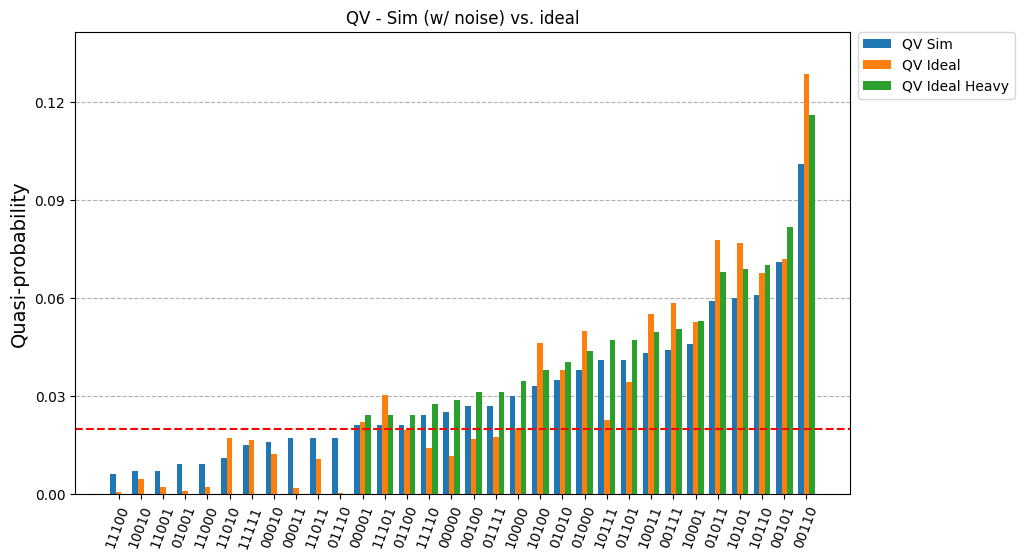

In [305]:
num_qubits=5

'''Create QV circuit'''
qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)
qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7)

'''Simulate QV circuit'''
shots = 1000
transpiled_circuit = transpile(qv_circuit, backend)
job = backend.run(transpiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()

'''Calculate ideal QV outputs'''
ideal_probs = get_ideal_qv_distribution(qv_circuit)

plot_histogram([counts, ideal_probs], legend=("QV Sim", "QV Ideal") , bar_labels=False)

'''
QV analysis of Heavy outputs
'''
probs = list(ideal_probs.values())
median = np.median(probs)
print('Median probability of counts in QV circuit outputs = ',median)
heavy_outputs = {bit for bit, count in counts.items() if count > median*shots}
heavy_count_probs = {bit: count/shots for bit, count in counts.items() if count > median*shots}

heavy_probs = sum(counts.get(bit, 0) for bit in heavy_outputs);

heavy_output_probability = heavy_probs/shots*100

if heavy_output_probability > 2/3/100:
    print('Heavy Output Probability of noise simulation is=',heavy_output_probability,'%  which is over 67% --> Success!)')
else:
    print('Heavy Output Probability of noise simulation is=',heavy_output_probability,'%  which is under 67% --> try again..)')

# plot_histogram([counts, ideal_probs,heavy_count_probs], legend=("QV Sim", "QV Ideal", "QV Sim Heavy only") , bar_labels=False)

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111)
plot_histogram([counts, ideal_probs,heavy_count_probs],
               ax=ax, 
                title='QV - Sim (w/ noise) vs. ideal',
               legend=("QV Sim", "QV Ideal", "QV Ideal Heavy"),
               bar_labels=False, sort='value')
ax.axhline(y=median, color='r', linestyle='--', label='Median')

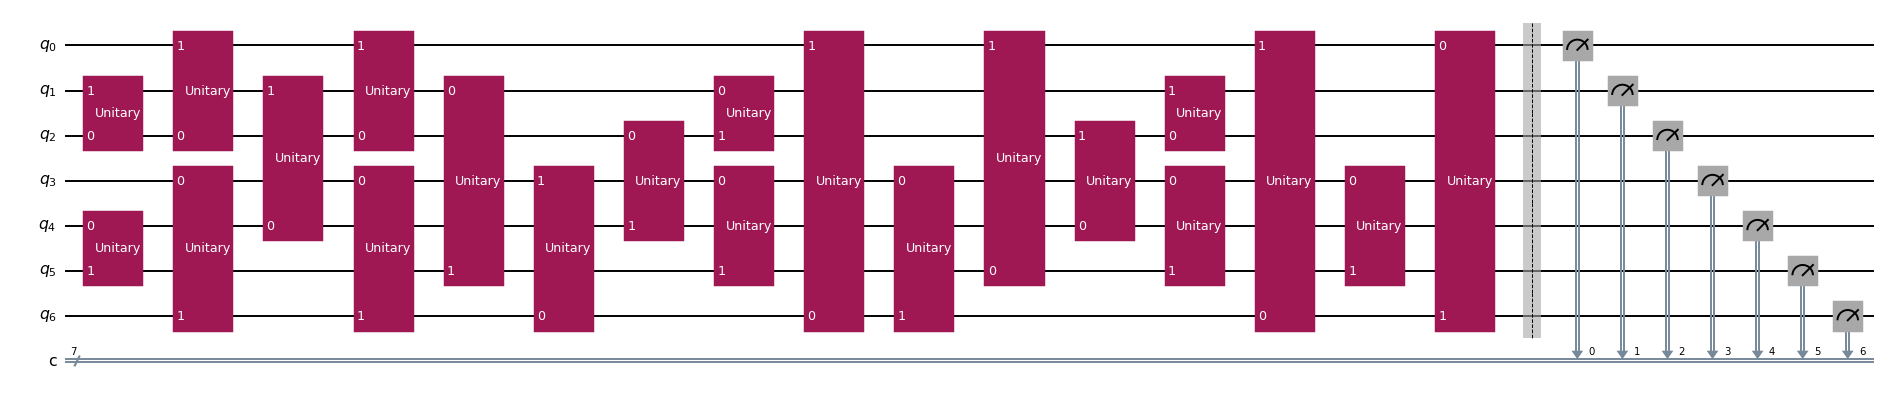

Median probability of counts in QV circuit outputs =  0.005008831975928866
Heavy Output Probability= 0.716 %  is over 67% --> Success!)


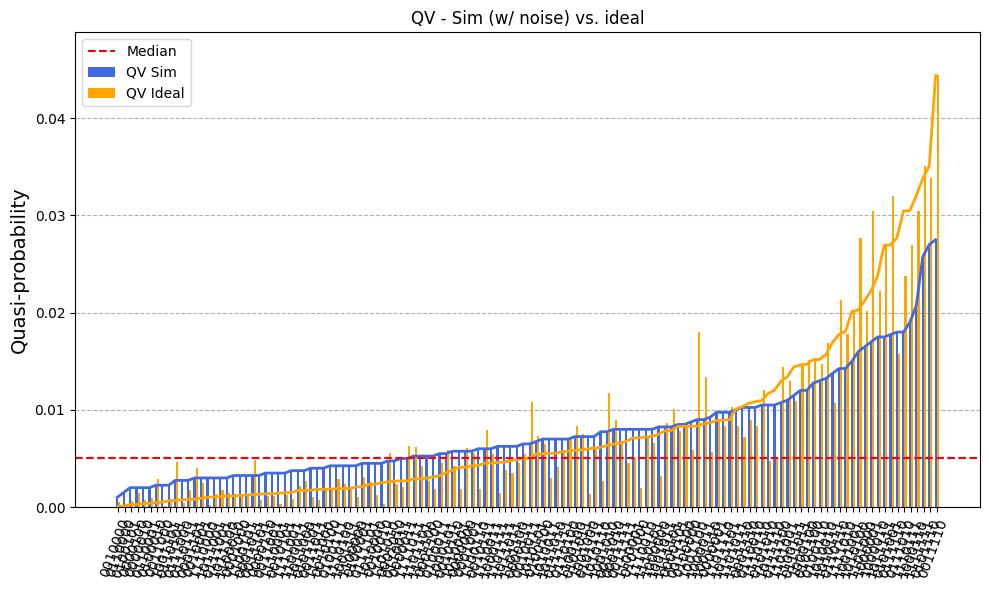

In [314]:
num_qubits=7

'''Create QV circuit'''
qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)
display(qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7))

'''Simulate QV circuit'''
shots = 4000
transpiled_circuit = transpile(qv_circuit, backend)
job = backend.run(transpiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()

'''Calculate ideal QV outputs'''
ideal_probs = get_ideal_qv_distribution(qv_circuit)

'''
QV analysis of Heavy outputs
'''
# find median of ideal circuit
median = np.median(list(ideal_probs.values()))
print('Median probability of counts in QV circuit outputs = ',median)

# filter only bits over the median
heavy_outputs = {bit for bit, prob in ideal_probs.items() if prob > median}
# count sim shots of the heavy bits
heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs)
# calculate the probability 
heavy_output_probability = heavy_counts / shots

plot_histogram([counts, ideal_probs], legend=("QV Sim", "QV Ideal") , bar_labels=False)

if heavy_output_probability > 2/3:
    print('Heavy Output Probability=',heavy_output_probability,'%  is over 67% --> Success!)')
else:
    print('Heavy Output Probability=',heavy_output_probability,'%  is under 67% --> try again..)')

# # plot_histogram([counts, ideal_probs,heavy_count_probs], legend=("QV Sim", "QV Ideal", "QV Sim Heavy only") , bar_labels=False)
# fig = plt.figure(figsize=[15, 6])
# ax = fig.add_subplot(111)
# plot_histogram([counts, ideal_probs],
#                ax=ax, 
#                 title='QV - Sim (w/ noise) vs. ideal',
#                legend=("QV Sim", "QV Ideal"),
#                bar_labels=False, sort='value')
# ax.axhline(y=median, color='r', linestyle='--', label='Median')


# Extract and sort values
sim_probs = [v / shots for v in counts.values()]
sorted_counts_vals = sorted(sim_probs, reverse=False)
sorted_probs_vals = sorted(ideal_probs.values(), reverse=False)

x_counts = range(len(sorted_counts_vals))
x_probs = range(len(sorted_probs_vals))

# Create figure and plot histogram
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111)
plot_histogram([counts, ideal_probs],
               ax=ax, 
               title='QV - Sim (w/ noise) vs. ideal',
               legend=("QV Sim", "QV Ideal"),
               bar_labels=False, sort='value',
               color=['royalblue', 'orange'])
# Plot sorted distribution curves
ax.plot(x_counts, sorted_counts_vals, '-', color='royalblue', linewidth=2)
ax.plot(x_probs, sorted_probs_vals, '-', color='orange', linewidth=2)
ax.axhline(y=median, color='r', linestyle='--', label='Median')

ax.legend()
plt.tight_layout()
plt.show()


# Quantum Volume Benchmarking (QV vs. depth/breadth)


--- Running QV for 2 qubits/depth ---
Heavy Output Probability = 0.7450 → ✅ SUCCESS

--- Running QV for 3 qubits/depth ---
Heavy Output Probability = 0.8230 → ✅ SUCCESS

--- Running QV for 4 qubits/depth ---
Heavy Output Probability = 0.8390 → ✅ SUCCESS

--- Running QV for 5 qubits/depth ---
Heavy Output Probability = 0.8040 → ✅ SUCCESS

--- Running QV for 6 qubits/depth ---
Heavy Output Probability = 0.7310 → ✅ SUCCESS

--- Running QV for 7 qubits/depth ---
Heavy Output Probability = 0.7310 → ✅ SUCCESS

--- Running QV for 8 qubits/depth ---
Heavy Output Probability = 0.5740 → ❌ FAIL

--- Running QV for 9 qubits/depth ---
Heavy Output Probability = 0.6040 → ❌ FAIL

--- Running QV for 10 qubits/depth ---
Heavy Output Probability = 0.5140 → ❌ FAIL


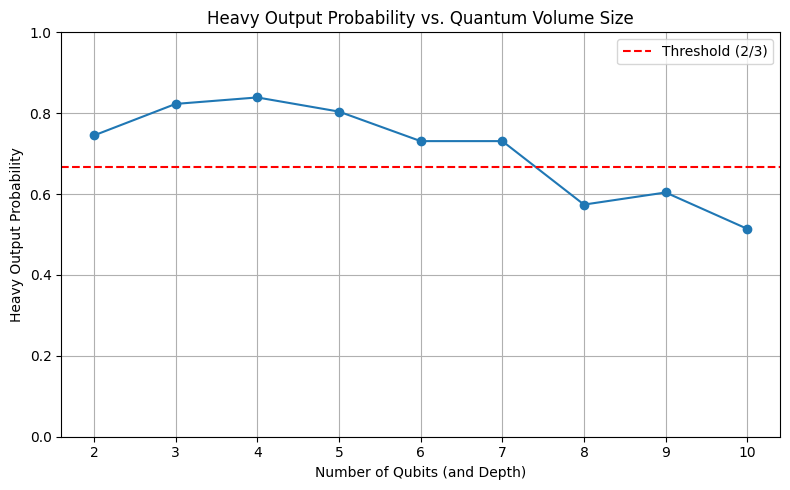

In [224]:
min_qubits=2
max_qubits=10
shots=1000

"""
Runs Quantum Volume analysis across a range of qubit sizes and depths.
Plots the Heavy Output Probability vs number of qubits.

Args:
    min_qubits (int): Starting number of qubits (and depth).
    max_qubits (int): Maximum number of qubits (and depth).
    shots (int): Number of shots per circuit.
"""
heavy_output_probs = []

for n in range(min_qubits, max_qubits + 1):
    print(f"\n--- Running QV for {n} qubits/depth ---")
    
    # Create and simulate QV circuit
    qv_circuit = create_quantum_volume_circuit(num_qubits=n, depth=n)

    '''Simulate QV circuit'''
    transpiled_circuit = transpile(qv_circuit, backend)
    job = backend.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()

    # Get ideal probabilities
    ideal_probs = get_ideal_qv_distribution(qv_circuit)

    # Compute heavy outputs
    median = np.median(list(ideal_probs.values()))
    heavy_outputs = {bit for bit, prob in ideal_probs.items() if prob > median}
    heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs)
    heavy_prob = heavy_counts / shots
    heavy_output_probs.append(heavy_prob)

    status = "✅ SUCCESS" if heavy_prob > 2/3 else "❌ FAIL"
    print(f"Heavy Output Probability = {heavy_prob:.4f} → {status}")

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(range(min_qubits, max_qubits + 1), heavy_output_probs, marker='o')
plt.axhline(2/3, color='r', linestyle='--', label='Threshold (2/3)')
plt.title("Heavy Output Probability vs. Quantum Volume Size")
plt.xlabel("Number of Qubits (and Depth)")
plt.ylabel("Heavy Output Probability")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [272]:
def run_qv_statistical_analysis(min_qubits=2, max_qubits=8, shots=1000, repeats=10):
    """
    Runs Quantum Volume analysis across a range of qubit sizes and depths,
    repeating multiple random circuits per size to gather statistics.

    Args:
        min_qubits (int): Minimum number of qubits (and depth).
        max_qubits (int): Maximum number of qubits (and depth).
        shots (int): Number of shots per QV circuit.
        repeats (int): Number of random circuits per qubit size.
    """
    avg_heavy_probs = []
    std_heavy_probs = []

    for n in range(min_qubits, max_qubits + 1):
        print(f"\n--- Running QV for {n} qubits/depth ({repeats} trials) ---")
        heavy_probs_n = []

        for rep in range(repeats):
            # Create and simulate QV circuit
            qv_circuit = create_quantum_volume_circuit(num_qubits=n, depth=n)
            transpiled = transpile(qv_circuit, backend)
            result = backend.run(transpiled, shots=shots).result()
            counts = result.get_counts()

            # Ideal distribution
            ideal_probs = get_ideal_qv_distribution(qv_circuit)
            median = np.median(list(ideal_probs.values()))
            heavy_outputs = {bit for bit, prob in ideal_probs.items() if prob > median}
            heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs)
            heavy_prob = heavy_counts / shots
            heavy_probs_n.append(heavy_prob)

        avg = np.mean(heavy_probs_n)
        std = np.std(heavy_probs_n)
        avg_heavy_probs.append(avg)
        std_heavy_probs.append(std)

        status = "✅ SUCCESS" if avg > 2/3 else "❌ FAIL"
        print(f"Avg Heavy Output Prob = {avg:.4f} ± {std:.4f} → {status}")

    # Plot results with error bars
    qubit_range = range(min_qubits, max_qubits + 1)
    plt.figure(figsize=(8, 5))
    plt.errorbar(qubit_range, avg_heavy_probs, yerr=std_heavy_probs, fmt='o-', capsize=5)
    plt.axhline(2/3, color='r', linestyle='--', label='Threshold (2/3)')
    plt.title(f"Heavy Output Probability vs. Qubit Count (shots={shots}, repeats={repeats})")
    plt.xlabel("Number of Qubits (and Depth)")
    plt.ylabel("Avg Heavy Output Probability")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



--- Running QV for 2 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.7740 ± 0.1114 → ✅ SUCCESS

--- Running QV for 3 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.8114 ± 0.0428 → ✅ SUCCESS

--- Running QV for 4 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.7807 ± 0.0668 → ✅ SUCCESS

--- Running QV for 5 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.7603 ± 0.0361 → ✅ SUCCESS

--- Running QV for 6 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.7145 ± 0.0383 → ✅ SUCCESS

--- Running QV for 7 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.6694 ± 0.0200 → ✅ SUCCESS

--- Running QV for 8 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.6189 ± 0.0307 → ❌ FAIL


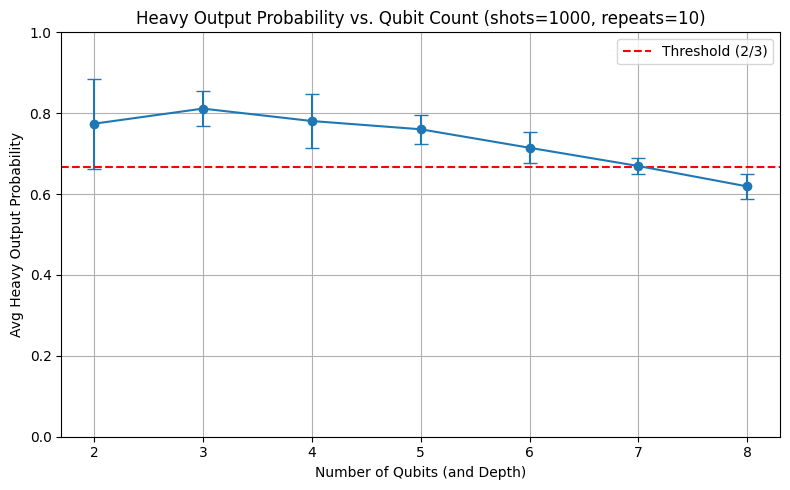

In [273]:
run_qv_statistical_analysis(min_qubits=2, max_qubits=8, shots=1000, repeats=10)

In [274]:
print(2**7)

128


## Quantum volume of about $2^7$ = 128! Not bad!

# Computational cost of simulating QV

In [288]:
import time

def measure_qv_simulation_time(min_qubits=2, max_qubits=20, repeats=3):
    """
    Measures classical simulation time (statevector) for QV circuits of increasing size,
    and plots average time with error bars.

    Args:
        min_qubits (int): Minimum number of qubits to test.
        max_qubits (int): Maximum number of qubits to test.
        repeats (int): Number of repetitions to average simulation time.
    """
    sim_times = []
    sim_stds = []
    qubit_range = range(min_qubits, max_qubits + 1)

    for n in qubit_range:
        print(f"\n⏳ Simulating QV circuit with {n} qubits x {n} depth...")

        times = []
        for _ in range(repeats):
            qv_circuit = create_quantum_volume_circuit(num_qubits=n, depth=n)

            start = time.time()
            _ = get_ideal_qv_distribution(qv_circuit)
            elapsed = time.time() - start
            times.append(elapsed)

        avg_time = np.mean(times)
        std_time = np.std(times)

        sim_times.append(avg_time)
        sim_stds.append(std_time)

        print(f"Avg simulation time for {n} qubits: {avg_time:.3f}s ± {std_time:.3f}s")

    # Plot with error bars
    plt.figure(figsize=(8, 5))
    plt.errorbar(list(qubit_range), sim_times, yerr=sim_stds, fmt='o-', capsize=5)
    plt.title("Classical Simulation Time vs. Number of Qubits")
    plt.xlabel("Number of Qubits (and Depth)")
    plt.ylabel("Avg Simulation Time (seconds)")
    plt.grid(True)
    plt.yscale("log")
    plt.tight_layout()
    plt.show()



⏳ Simulating QV circuit with 2 qubits x 2 depth...
Avg simulation time for 2 qubits: 0.002s ± 0.000s

⏳ Simulating QV circuit with 3 qubits x 3 depth...
Avg simulation time for 3 qubits: 0.002s ± 0.000s

⏳ Simulating QV circuit with 4 qubits x 4 depth...
Avg simulation time for 4 qubits: 0.003s ± 0.000s

⏳ Simulating QV circuit with 5 qubits x 5 depth...
Avg simulation time for 5 qubits: 0.003s ± 0.000s

⏳ Simulating QV circuit with 6 qubits x 6 depth...
Avg simulation time for 6 qubits: 0.003s ± 0.000s

⏳ Simulating QV circuit with 7 qubits x 7 depth...
Avg simulation time for 7 qubits: 0.003s ± 0.000s

⏳ Simulating QV circuit with 8 qubits x 8 depth...
Avg simulation time for 8 qubits: 0.006s ± 0.000s

⏳ Simulating QV circuit with 9 qubits x 9 depth...
Avg simulation time for 9 qubits: 0.006s ± 0.000s

⏳ Simulating QV circuit with 10 qubits x 10 depth...
Avg simulation time for 10 qubits: 0.008s ± 0.000s

⏳ Simulating QV circuit with 11 qubits x 11 depth...
Avg simulation time for 1

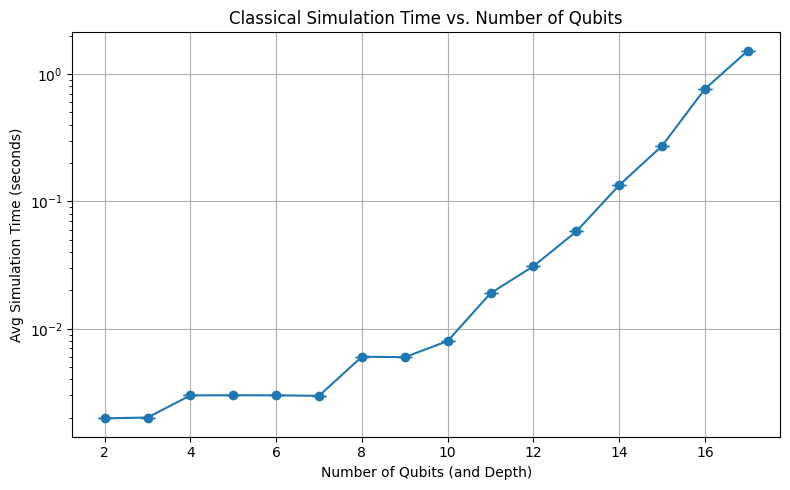

In [293]:
measure_qv_simulation_time(min_qubits=2, max_qubits=17, repeats=1)

In [ ]:
def exponential_model(n, a, b):
    return a * (2 ** (b * n))

def measure_qv_simulation_time(min_qubits=2, max_qubits=20, repeats=3, extrapolate_to=100):
    """
    Measures classical simulation time (statevector) for QV circuits of increasing size,
    and fits an exponential model to extrapolate runtime for large qubit counts.

    Args:
        min_qubits (int): Minimum number of qubits to test.
        max_qubits (int): Maximum number of qubits to test.
        repeats (int): Number of repetitions to average simulation time.
        extrapolate_to (int): Qubit count to extrapolate the runtime.
    """
    sim_times = []
    sim_stds = []
    qubit_range = range(min_qubits, max_qubits + 1)

    for n in qubit_range:
        print(f"\n⏳ Simulating QV circuit with {n} qubits x {n} depth...")

        times = []
        for _ in range(repeats):
            qv_circuit = create_quantum_volume_circuit(num_qubits=n, depth=n)

            start = time.time()
            _ = get_ideal_qv_distribution(qv_circuit)
            elapsed = time.time() - start
            times.append(elapsed)

        avg_time = np.mean(times)
        std_time = np.std(times)

        sim_times.append(avg_time)
        sim_stds.append(std_time)

        print(f"Avg simulation time for {n} qubits: {avg_time:.3f}s ± {std_time:.3f}s")

    # Fit exponential model
    x_data = np.array(list(qubit_range))
    y_data = np.array(sim_times)
    popt, _ = curve_fit(exponential_model, x_data, y_data, p0=(1e-6, 1.0))

    # Extrapolate
    extrapolated_time = exponential_model(extrapolate_to, *popt)
    print(f"\n⏩ Extrapolated simulation time for {extrapolate_to} qubits: {extrapolated_time:.3e} seconds")

    # Plot with error bars and exponential fit
    x_fit = np.linspace(min_qubits, extrapolate_to, 200)
    y_fit = exponential_model(x_fit, *popt)

    plt.figure(figsize=(9, 6))
    plt.errorbar(x_data, y_data, yerr=sim_stds, fmt='ob', capsize=5, label="Measured Times")
    plt.plot(x_fit, y_fit, '-r' , label=f"Exponential Fit: a·2^{{b·n}}, b ≈ {popt[1]:.3f}")
    plt.scatter([extrapolate_to], [extrapolated_time], color='red', label=f"Extrapolated (n={extrapolate_to})")
    plt.yscale("log")
    plt.xlabel("Number of Qubits (and Depth)")
    plt.ylabel("Avg Simulation Time (seconds, log scale)")
    plt.title("QV Simulation Time vs. Qubit Count (with Exponential Fit)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()



⏳ Simulating QV circuit with 4 qubits x 4 depth...
Avg simulation time for 4 qubits: 0.002s ± 0.000s

⏳ Simulating QV circuit with 5 qubits x 5 depth...
Avg simulation time for 5 qubits: 0.003s ± 0.000s

⏳ Simulating QV circuit with 6 qubits x 6 depth...
Avg simulation time for 6 qubits: 0.004s ± 0.001s

⏳ Simulating QV circuit with 7 qubits x 7 depth...
Avg simulation time for 7 qubits: 0.003s ± 0.000s

⏳ Simulating QV circuit with 8 qubits x 8 depth...
Avg simulation time for 8 qubits: 0.006s ± 0.002s

⏳ Simulating QV circuit with 9 qubits x 9 depth...
Avg simulation time for 9 qubits: 0.006s ± 0.000s

⏳ Simulating QV circuit with 10 qubits x 10 depth...
Avg simulation time for 10 qubits: 0.010s ± 0.001s

⏳ Simulating QV circuit with 11 qubits x 11 depth...
Avg simulation time for 11 qubits: 0.016s ± 0.000s

⏳ Simulating QV circuit with 12 qubits x 12 depth...
Avg simulation time for 12 qubits: 0.030s ± 0.000s

⏳ Simulating QV circuit with 13 qubits x 13 depth...
Avg simulation time

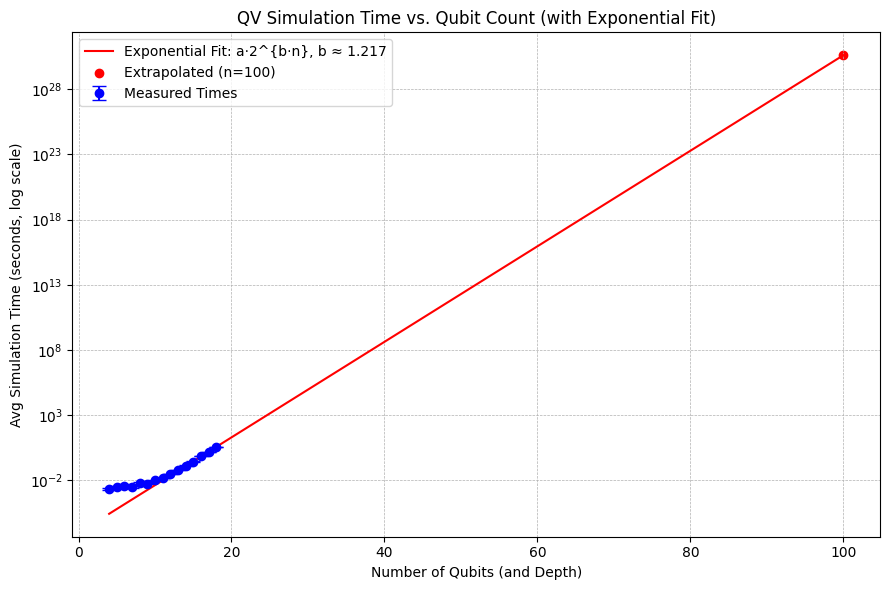

In [306]:
measure_qv_simulation_time(min_qubits=4, max_qubits=18, repeats=3, extrapolate_to=100)

### Quantum Computational limit

This simulation was run on a PC (not the cloud via colab).

If the QV simulation for 100 qubits could be run on ALL of the computers in the world...
(assuming ideal connectivity etc.) then it would run 10 orders of magnitude faster... 

reducing the runtime from ~$10^{30}$ seconds to ~$10^{20}$ seconds...

However, the age of the universe is $4\times10^{17}$ seconds... so it would still take a very very long time...

This is one example of what is interesting about quantum computers...

# QV on IBM QPUs

In [46]:
# You'll need to specify the credentials when initializing QiskitRuntimeService, if they were not previously saved.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend)

<IBMBackend('ibm_sherbrooke')>


In [125]:
print(backend)

<IBMBackend('ibm_sherbrooke')>


In [118]:
n= 3
qv_circuit = create_quantum_volume_circuit(num_qubits=n, depth=n)
transpiled = transpile(qv_circuit, backend)


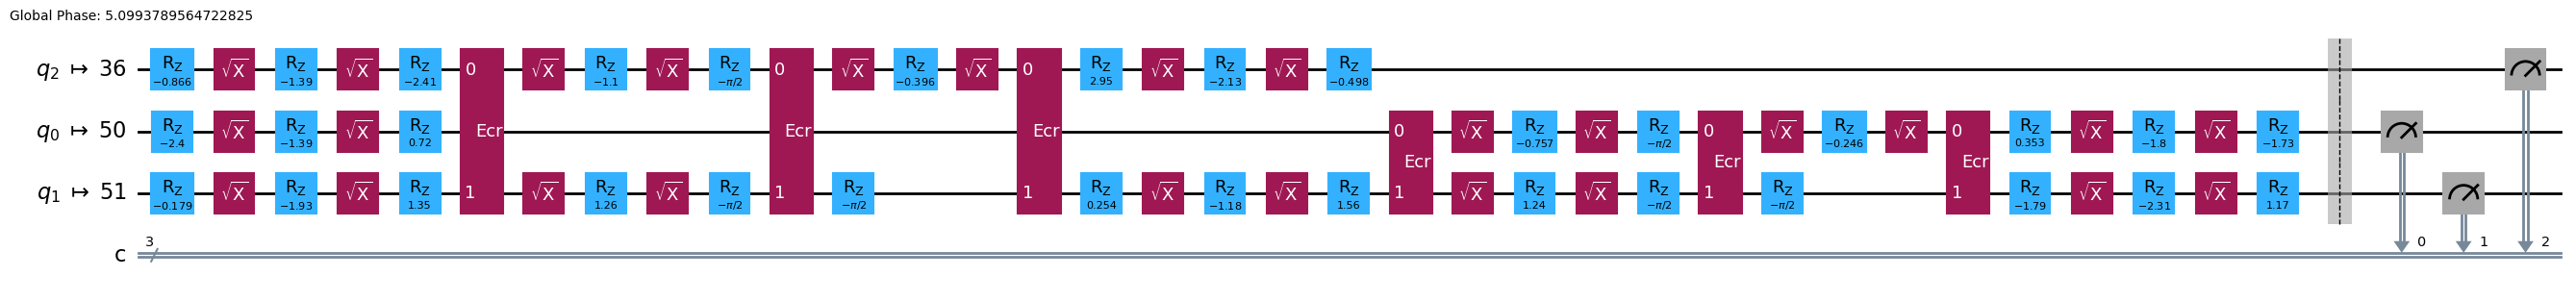

In [119]:
transpiled.draw('mpl', style="iqp",idle_wires=False,fold=50)

## Run on QPU

In [120]:
sampler = Sampler(backend)
job = sampler.run([transpiled])

In [121]:
result = job.result()
print(result)
counts = result[0].data.c.get_counts()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=3>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-02 20:56:06', stop='2025-04-02 20:56:08', size=4096>)])}, 'version': 2})


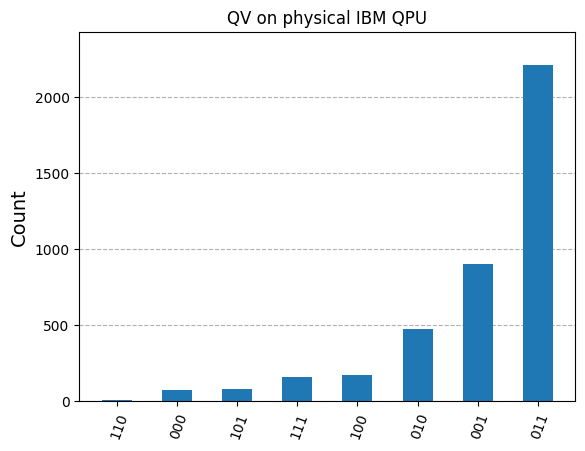

In [122]:
plot_histogram(counts,title='QV on physical IBM QPU',bar_labels=False,sort='value')

## Now simulate ideal output

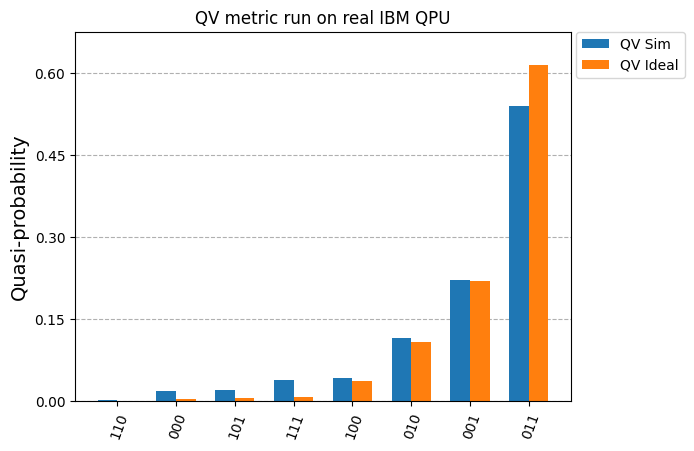

In [123]:
# Ideal distribution
ideal_probs = get_ideal_qv_distribution(qv_circuit)
median = np.median(list(ideal_probs.values()))
heavy_outputs = {bit for bit, prob in ideal_probs.items() if prob > median}
plot_histogram([counts,ideal_probs], title = 'QV metric run on real IBM QPU', legend=("QV Sim", "QV Ideal") ,  bar_labels=False, sort='value')

In [124]:
shots=4096
heavy_probs_n = []
heavy_counts = np.sum(np.fromiter((counts.get(bit, 0) for bit in heavy_outputs), dtype=int))
heavy_prob = heavy_counts / shots
if heavy_prob > 2/3:
    print("success",heavy_prob)
else:
    print('failure',heavy_prob)


success 0.919677734375


## Success!!!

Now let's try a larger circuit

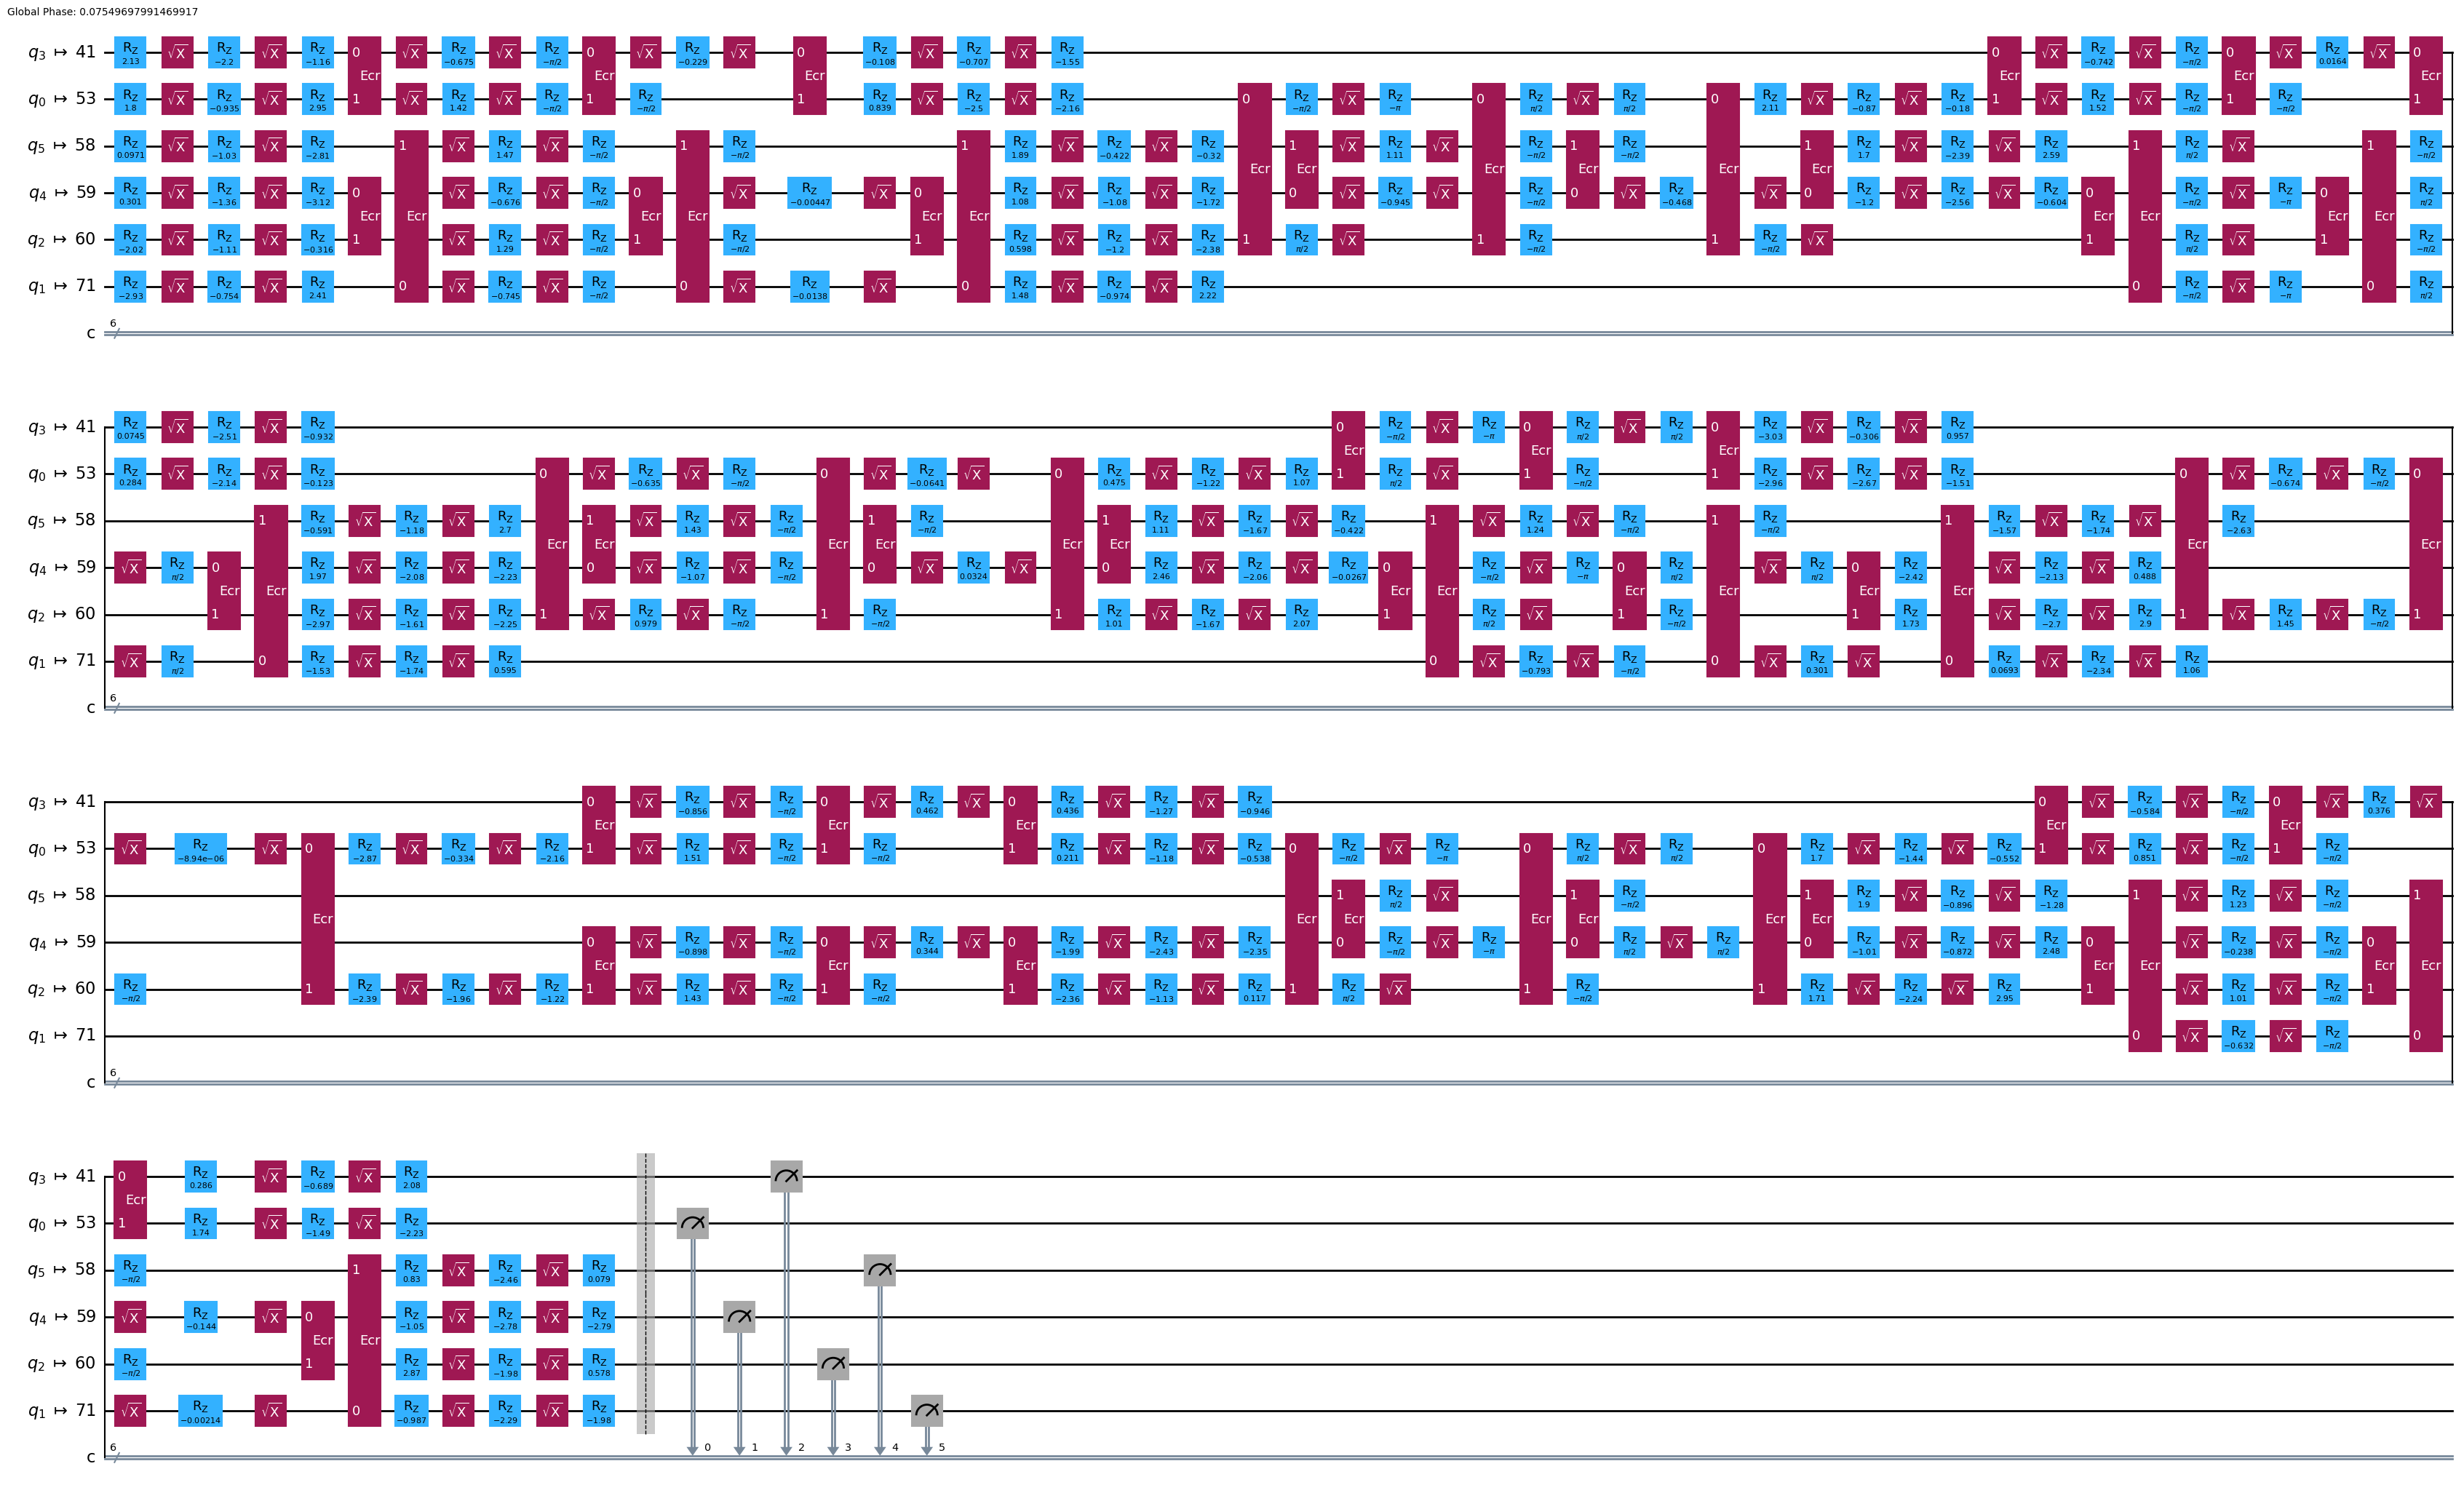

In [143]:
n= 6
qv_circuit = create_quantum_volume_circuit(num_qubits=n, depth=n)
transpiled = transpile(qv_circuit, backend)
transpiled.draw('mpl', style="iqp",idle_wires=False,fold=50)

In [ ]:
shots=1000
sampler = Sampler(backend)
job = sampler.run([transpiled],shots=shots)
result = job.result()
print(result)
counts = result[0].data.c.get_counts()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=6>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-02 23:34:03', stop='2025-04-02 23:34:11', size=4096>)])}, 'version': 2})


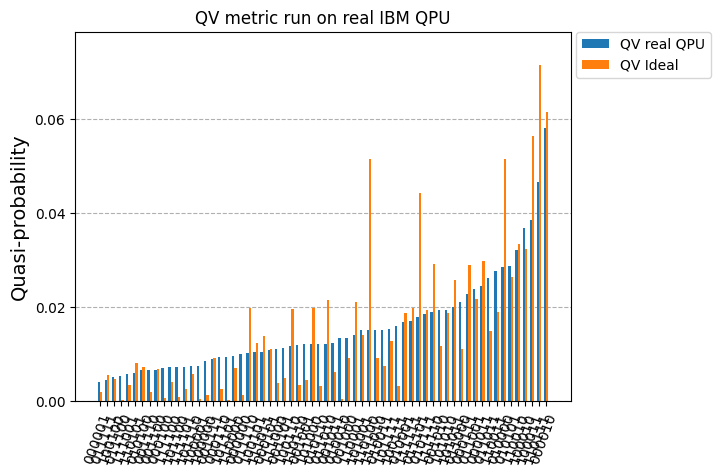

Success!! 0.70361328125


In [ ]:
# Ideal distribution
ideal_probs = get_ideal_qv_distribution(qv_circuit)
median = np.median(list(ideal_probs.values()))
heavy_outputs = {bit for bit, prob in ideal_probs.items() if prob > median}
display(plot_histogram([counts,ideal_probs], title = 'QV metric run on real IBM QPU', legend=("QV real QPU", "QV Ideal") ,  bar_labels=False, sort='value'))

heavy_probs_n = []
heavy_counts = np.sum(np.fromiter((counts.get(bit, 0) for bit in heavy_outputs), dtype=int))
heavy_prob = heavy_counts / shots
if heavy_prob > 2/3:
    print("Success!!",heavy_prob)
else:
    print('failure',heavy_prob)


## Works for 5 qubits! Run on a real QPU!!! Neat!

Let's try 7 qubits next..

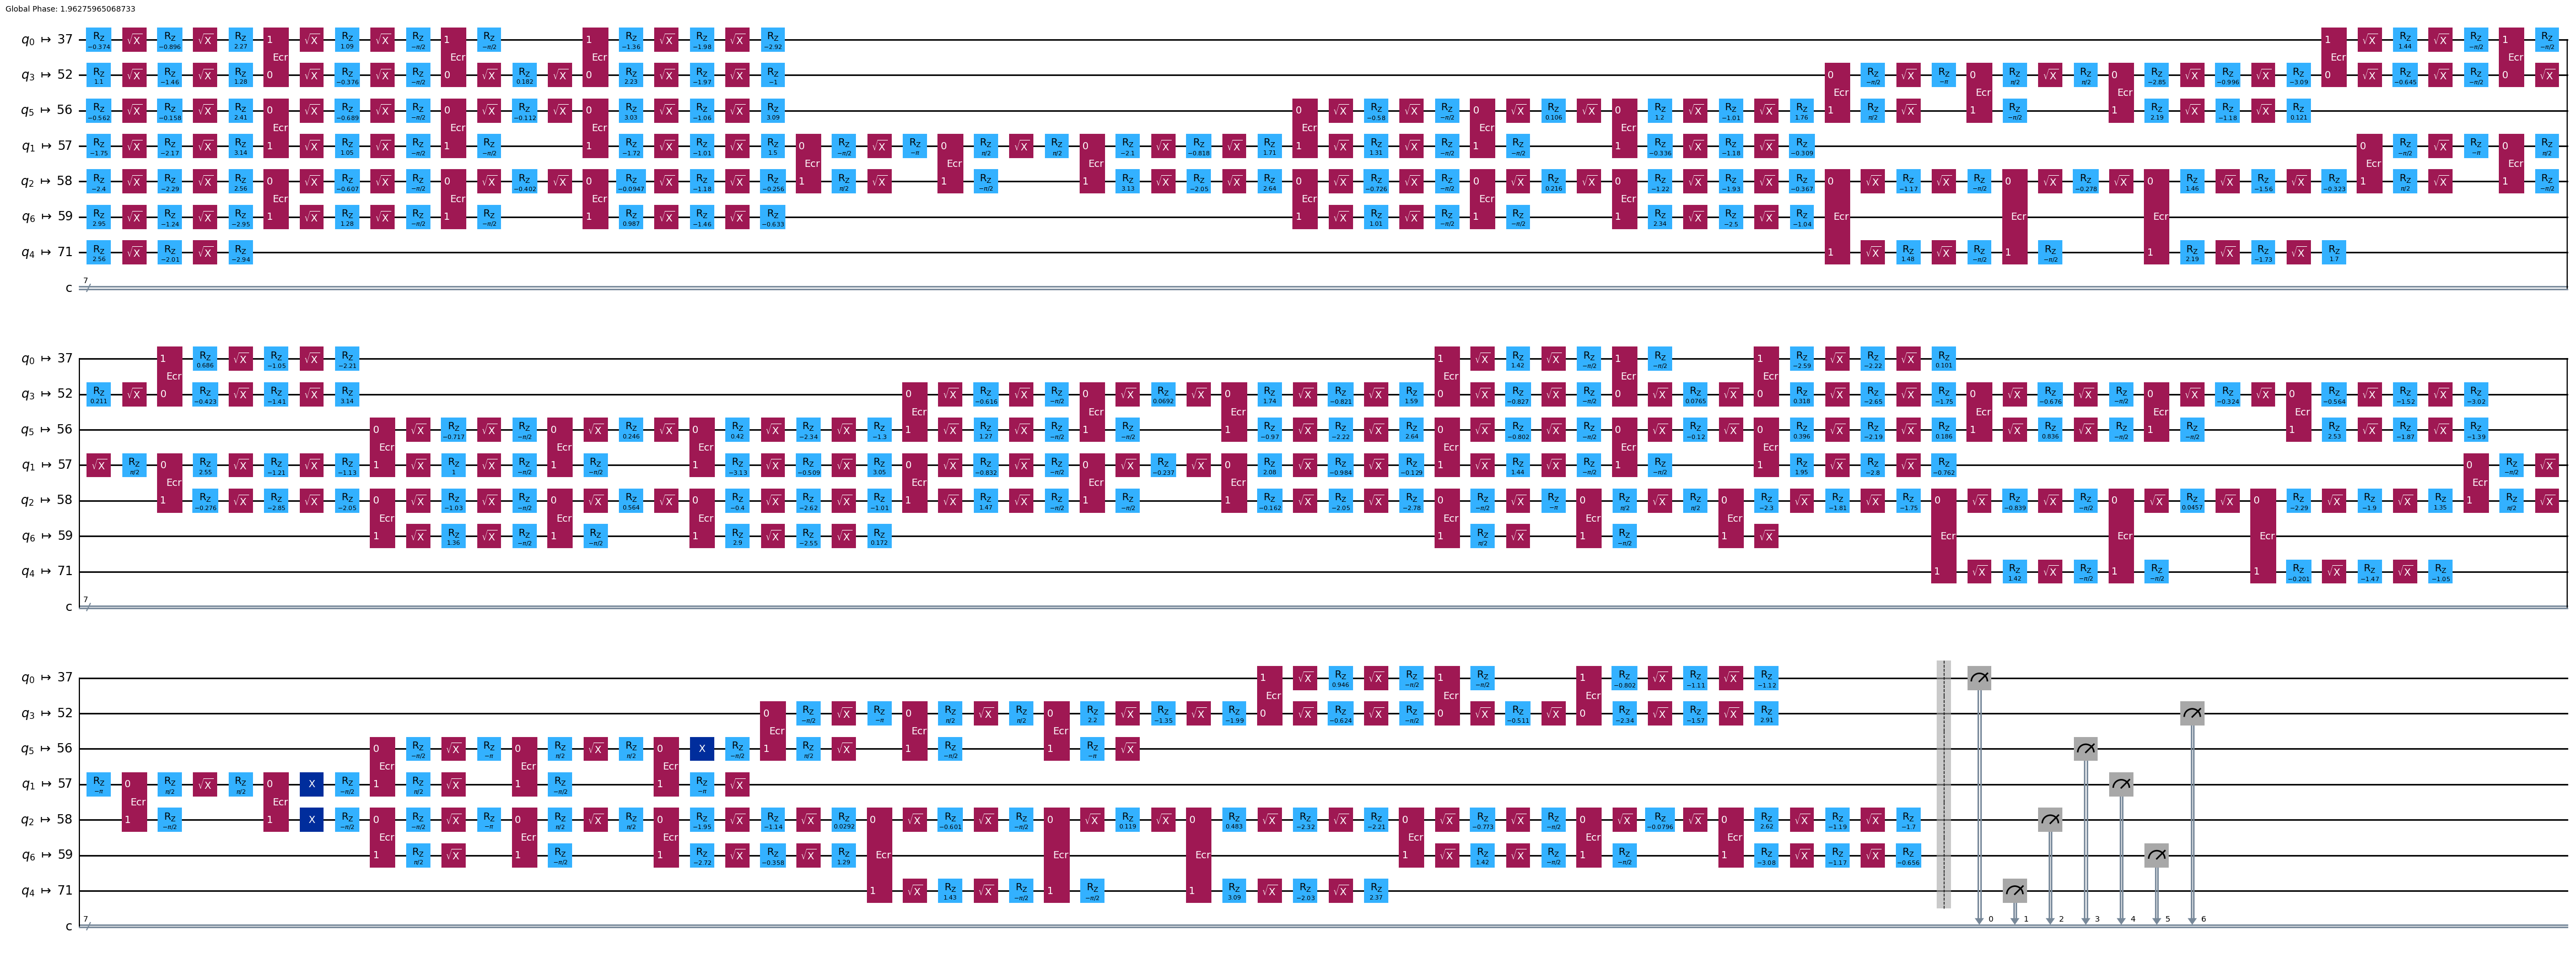

In [315]:
n= 7
qv_circuit = create_quantum_volume_circuit(num_qubits=n, depth=n)
transpiled = transpile(qv_circuit, backend)
transpiled.draw('mpl', style="iqp",idle_wires=False,fold=70)

In [316]:
shots = 4000
sampler = Sampler(backend)
job = sampler.run([transpiled],shots=shots)
result = job.result()
print(result)
counts = result[0].data.c.get_counts()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4000, num_bits=7>)), metadata={'shots': 4000, 'circuit_metadata': {}})], metadata={'version': 2})


Failure: Heavy output probability 0.654 below 2/3 threshold


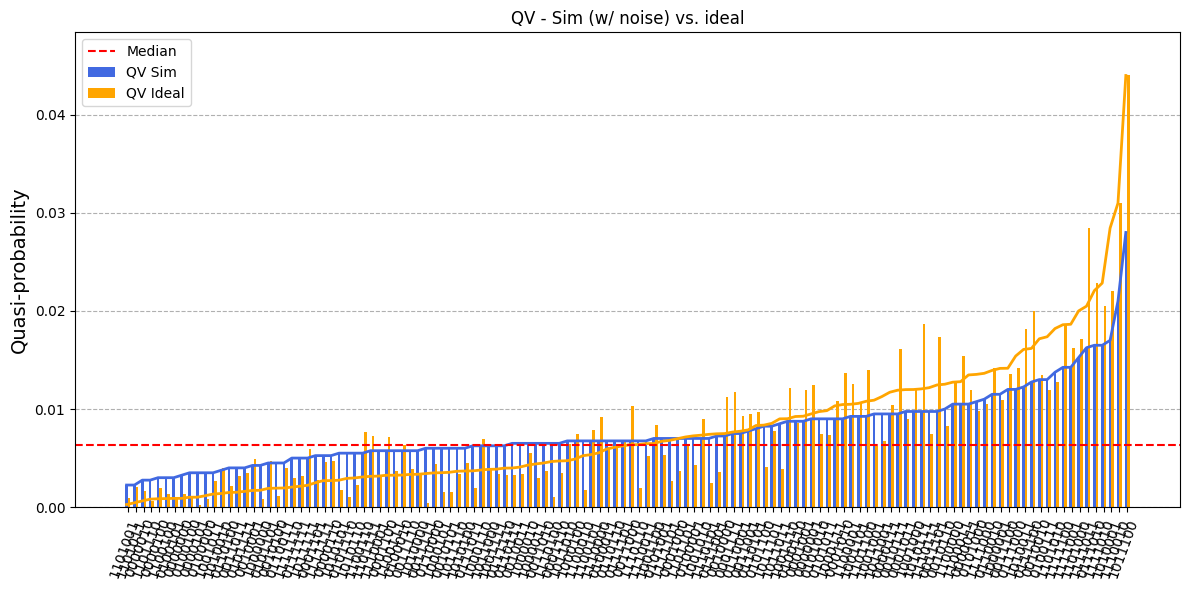

In [321]:
# Ideal distribution
ideal_probs = get_ideal_qv_distribution(qv_circuit)
median = np.median(list(ideal_probs.values()))
heavy_outputs = {bit for bit, prob in ideal_probs.items() if prob > median}
# display(plot_histogram([counts,ideal_probs], title = 'QV metric run on real IBM QPU', legend=("QV real QPU", "QV Ideal") ,  bar_labels=False, sort='value'))

heavy_probs_n = []
heavy_counts = np.sum(np.fromiter((counts.get(bit, 0) for bit in heavy_outputs), dtype=int))
heavy_prob = heavy_counts / shots
if heavy_prob > 2/3:
    print(f"Success!! Heavy output probability {heavy_prob:.3f} exceeds 2/3 threshold")
else:
    print(f"Failure: Heavy output probability {heavy_prob:.3f} below 2/3 threshold")

# Extract and sort values
sim_probs = [v / shots for v in counts.values()]
sorted_counts_vals = sorted(sim_probs, reverse=False)
sorted_probs_vals = sorted(ideal_probs.values(), reverse=False)

x_counts = range(len(sorted_counts_vals))
x_probs = range(len(sorted_probs_vals))

# Create figure and plot histogram
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(111)
plot_histogram([counts, ideal_probs],
               ax=ax, 
               title='QV - Sim (w/ noise) vs. ideal',
               legend=("QV Sim", "QV Ideal"),
               bar_labels=False, sort='value',
               color=['royalblue', 'orange'])
# Plot sorted distribution curves
ax.plot(x_counts, sorted_counts_vals, '-', color='royalblue', linewidth=2)
ax.plot(x_probs, sorted_probs_vals, '-', color='orange', linewidth=2)
ax.axhline(y=median, color='r', linestyle='--', label='Median')

ax.legend()
plt.tight_layout()
plt.show()

### Just at the threshold of consistently running QV 7 on physical IBM QPUs! Neat!

### Further reading:

Application-Oriented Performance Benchmarks for Quantum Computing - https://arxiv.org/abs/2110.03137

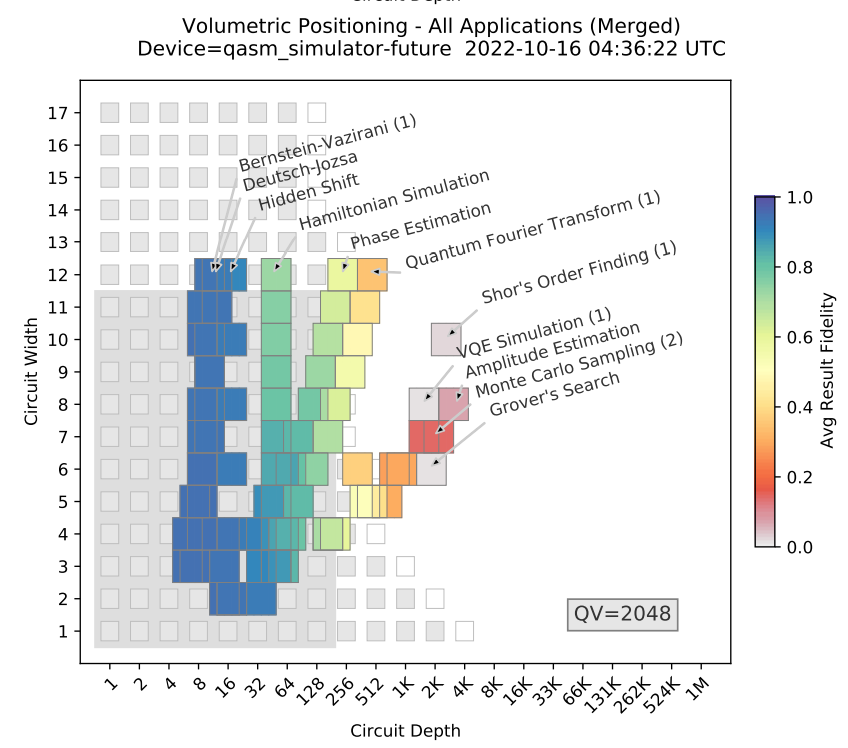

# Exercises

  1. What is the max T1 on ibm_brisbane? Verify it yourself.

  1. What is the maximum T2 on ibm_brisbane? Verify it.

  1. What is the expected largest GHZ state that can be made on ibm_brisbane? How can you estimate this?

  1. Can you increase the quantum volume by using different qubits? What is the largest quantum volume you can simulate on ibm_brisbane?

  1. What is the largest quantum volume you can simulate on a classical computer???

  1. Compare the runtime of QV simulated vs. run on a real quantum computer vs. number of qubits (and depth). Project the runtime out to 100 qubits.
  


In [ ]:
'''
Exercise 1
'''


In [ ]:
'''
Exercise 2
'''
